In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras import models
from keras import callbacks
from keras import backend as K
from keras.datasets import mnist
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score,log_loss, mean_absolute_error,median_absolute_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tqdm import tqdm
import pickle
def makefile(what,filename):
    with open(filename,"wb") as f3:
        pickle.dump(what,f3)

def readfile(filename):
    with open(filename,"rb") as f4:
        ans=pickle.load(f4)
    return ans

In [3]:
from keras.datasets import cifar10

In [107]:
from keras.datasets import cifar100

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

In [5]:
images=["Lenna.png"]

In [6]:
from keras.backend import clear_session

In [7]:
import numpy as np
import random
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf

In [8]:
y2=Image.open("Lenna.png").resize([32,32])

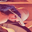

In [83]:
y2.rotate(270)

In [131]:
np.random.seed(seed=1)

os.environ['PYTHONHASHSEED'] = '0'
random.seed(0)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
tf.random.set_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
degree=[0,90,180,270]
values=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4]
convo=[6]
for goal in images:
    y2=Image.open(goal).resize([32,32])
    data2=cifar100.load_data()[0][0]
    label2=cifar100.load_data()[0][1]
    label2=label2.reshape(len(label2))
    x_test=cifar100.load_data()[1][0]
    y_test=cifar100.load_data()[1][1]
    y_test=y_test.reshape(len(y_test))
    data3=np.zeros([len(data2),32,32,3])
    for n in range(len(data2)):
        data3[n]=Image.fromarray(data2[n].astype("uint8"))
    data2=data3
    
    outputs=[]
    outputs4=[]
    outputs5=[]
    for c in range(len(convo)):
        outputs2=[]
        outputs3=[]
        for e in range(5):
            ensemble=[]
            for rot in degree:
                error_record=[]
                clear_session()
                unseen_score=np.zeros([20,9])
                AUC_score=np.zeros(20)
                for i in range(20):
                    x_train=data2[label2==i]
                    y_train=np.zeros([len(x_train),32,32,3])
                    for n in range(len(x_train)):
                        y_train[n]=y2.rotate(rot)
                    #x_train=x_train/255
                    y_train=y_train
                    #x_test=data2[label2!=i]
                    #x_test=x_test/255
                    x_test=x_test.reshape(len(x_test),32,32,3)
                    y_label=np.zeros(len(y_test))
                    y_label[y_test==i]=1
                    #(x_train, train), (x_test, y_test) = mnist.load_data()
                    image_height, image_width = 32, 32
                    # バックエンドに依存したチャネルの位置を調整する
                    if K.image_data_format() == 'channels_last':
                        x_train = x_train.reshape(x_train.shape[0],
                                                  image_height, image_width,3)
                        #x_test = x_test.reshape(x_test.shape[0],image_height, image_width, 1)
                        y_train = y_train.reshape(y_train.shape[0],
                                                  32, 32,3)
                        input_shape = (image_height, image_width,3)
                    else:
                        x_train = x_train.reshape(x_train.shape[0],
                                                  1, image_height, image_width)
                        x_test = x_test.reshape(x_test.shape[0],1, image_height, image_width)
                        input_shape = (1, image_height, image_width)

                    # Min-Max Normalization (0. ~ 1. の範囲に値を収める)
                    x_train = x_train.astype('float32')
                    y_train = y_train.astype('float32')
                    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=e)
                    x_valid, x_valid2, y_valid, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.3, random_state=e)
                    #x_test = x_test.astype('float32')
                    #x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
                    #x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
                    # 畳み込み演算を用いた AutoEncoder のネットワーク (Sequential API)
                    model = models.Sequential()
                    # 28 x 28 x 1
                    model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',input_shape=input_shape))
                    for n in range(convo[c]):
                        model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
                    model.add(layers.Conv2D(3, kernel_size=(3, 3),activation='relu', padding='same'))
                    # 28 x 28 x 1
                    model.compile(optimizer='adam',
                                  loss='mean_absolute_error')
                    # モデルの構造を確認する
                    fit_callbacks = [
                        callbacks.EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                mode='min')
                    ]
                    # モデルを学習させる
                    model.fit(x_train, y_train,
                              epochs=100,
                              batch_size=16,
                              shuffle=True,
                              validation_data=(x_valid, y_valid),callbacks=fit_callbacks)
                    result=model.predict(x_valid2)
                    result2=model.predict(x_test)
                    y_train=y_train.reshape(y_train.shape[0],1024,3)
                    result=result.reshape(result.shape[0],1024,3)
                    result2=result2.reshape(result2.shape[0],1024,3)
                    loss=np.zeros(len(result))
                    for n in range(len(result)):
                        loss[n]=mean_absolute_error(y_train[0],result[n])
                    loss_outlier=np.zeros(len(result2))
                    for n in range(len(result2)):
                        loss_outlier[n]=mean_absolute_error(y_train[0],result2[n])
                    error_record.append(loss_outlier)
                    #y_one=np.ones(len(loss))
                    #y_outlier=np.zeros(len(loss_outlier))
                    #data=np.concatenate([loss,loss_outlier])
                    #label=np.concatenate([y_one,y_outlier])
                    #plt.scatter(data,label)
                    #plt.hist([loss,loss_outlier],range=(0,0.3),stacked=False,bins=10)
                    m=0
                    AUC_score[i]=roc_auc_score(y_label,(-1)*loss_outlier)
                    for p in values:
                        y_pred=np.zeros(len(y_label))
                        threshold=int(len(loss)*p)+1
                        #print(loss[loss.argsort()[-threshold]])
                        y_pred[loss_outlier<=loss[loss.argsort()[-threshold]]]=1
                        #loss_outlier[loss_outlier>loss[loss.argsort()[-threshold]]
                        unseen_score[i][m]=balanced_accuracy_score(y_label,y_pred)
                        m+=1
                #print(unseen_score)
                #outputs.append(unseen_score)
                outputs2.append(AUC_score)
                outputs3.append(unseen_score)
                ensemble.append(error_record)
            outputs5.append(ensemble)
            outputs.append(outputs2)
            outputs4.append(outputs3)
    #makefile(outputs,"result_ocitn/cifar10_"+str(goal)+".pkl")

Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 69.4964 - val_loss: 47.0583
Epoch 2/100
350/350 [==============================] - 0s 666us/step - loss: 44.6931 - val_loss: 41.3572
Epoch 3/100
350/350 [==============================] - 0s 664us/step - loss: 40.9610 - val_loss: 40.0628
Epoch 4/100
350/350 [==============================] - 0s 676us/step - loss: 38.7518 - val_loss: 39.1128
Epoch 5/100
350/350 [==============================] - 0s 670us/step - loss: 38.5250 - val_loss: 40.3225
Epoch 6/100
350/350 [==============================] - 0s 664us/step - loss: 37.4665 - val_loss: 37.4738
Epoch 7/100
350/350 [==============================] - 0s 677us/step - loss: 36.0504 - val_loss: 36.4793
Epoch 8/100
350/350 [==============================] - 0s 674us/step - loss: 35.8873 - val_loss: 36.9803
Epoch 9/100
350/350 [==============================] - 0s 661us/step - loss: 36.2102 - val_loss: 38.3420
Epoch 10/10

350/350 [==============================] - 0s 612us/step - loss: 31.6931 - val_loss: 32.8612
Epoch 30/100
350/350 [==============================] - 0s 615us/step - loss: 34.4439 - val_loss: 37.4472
Epoch 31/100
350/350 [==============================] - 0s 600us/step - loss: 33.7877 - val_loss: 32.7057
Epoch 32/100
350/350 [==============================] - 0s 598us/step - loss: 31.7591 - val_loss: 31.9938
Epoch 33/100
350/350 [==============================] - 0s 585us/step - loss: 31.5457 - val_loss: 34.0077
Epoch 34/100
350/350 [==============================] - 0s 610us/step - loss: 32.0232 - val_loss: 32.6654
Epoch 35/100
350/350 [==============================] - 0s 618us/step - loss: 31.4961 - val_loss: 33.4356
Epoch 36/100
350/350 [==============================] - 0s 606us/step - loss: 31.0155 - val_loss: 31.3530
Epoch 37/100
350/350 [==============================] - 0s 619us/step - loss: 33.0596 - val_loss: 34.5069
Epoch 38/100
350/350 [==============================] - 0s 

Epoch 36/100
350/350 [==============================] - 0s 659us/step - loss: 29.3452 - val_loss: 30.6085
Epoch 37/100
350/350 [==============================] - 0s 841us/step - loss: 29.4067 - val_loss: 29.7635
Epoch 38/100
350/350 [==============================] - 0s 690us/step - loss: 29.0684 - val_loss: 30.1343
Epoch 39/100
350/350 [==============================] - 0s 604us/step - loss: 27.5543 - val_loss: 28.5292
Epoch 40/100
350/350 [==============================] - 0s 599us/step - loss: 26.9494 - val_loss: 27.5371
Epoch 41/100
350/350 [==============================] - 0s 595us/step - loss: 26.2985 - val_loss: 26.7771
Epoch 42/100
350/350 [==============================] - 0s 601us/step - loss: 25.6516 - val_loss: 26.3348
Epoch 43/100
350/350 [==============================] - 0s 605us/step - loss: 25.2598 - val_loss: 25.5102
Epoch 44/100
350/350 [==============================] - 0s 592us/step - loss: 24.6733 - val_loss: 25.2794
Epoch 45/100
350/350 [========================

350/350 [==============================] - 0s 648us/step - loss: 32.0600 - val_loss: 32.8453
Epoch 47/100
350/350 [==============================] - 0s 613us/step - loss: 33.6856 - val_loss: 35.1565
Epoch 48/100
350/350 [==============================] - 0s 643us/step - loss: 31.6936 - val_loss: 30.4813
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 81.6107 - val_loss: 65.7512
Epoch 2/100
350/350 [==============================] - 0s 618us/step - loss: 51.5229 - val_loss: 45.2118
Epoch 3/100
350/350 [==============================] - 0s 624us/step - loss: 43.5921 - val_loss: 41.6998
Epoch 4/100
350/350 [==============================] - 0s 614us/step - loss: 41.3667 - val_loss: 40.2260
Epoch 5/100
350/350 [==============================] - 0s 611us/step - loss: 41.0481 - val_loss: 39.9661
Epoch 6/100
350/350 [==============================] - 0s 598us/step - loss: 39.3389 - val_loss: 38.7257
Epoch 7/100
350/350 [

350/350 [==============================] - 0s 617us/step - loss: 22.7466 - val_loss: 23.9557
Epoch 68/100
350/350 [==============================] - 0s 619us/step - loss: 22.5191 - val_loss: 23.6681
Epoch 69/100
350/350 [==============================] - 0s 628us/step - loss: 22.4951 - val_loss: 23.6671
Epoch 70/100
350/350 [==============================] - 0s 621us/step - loss: 22.5351 - val_loss: 23.7925
Epoch 71/100
350/350 [==============================] - 0s 625us/step - loss: 23.3032 - val_loss: 23.6627
Epoch 72/100
350/350 [==============================] - 0s 607us/step - loss: 22.5855 - val_loss: 23.5643
Epoch 73/100
350/350 [==============================] - 0s 632us/step - loss: 22.3035 - val_loss: 23.6979
Epoch 74/100
350/350 [==============================] - 0s 613us/step - loss: 22.1446 - val_loss: 23.3417
Epoch 75/100
350/350 [==============================] - 0s 628us/step - loss: 22.0877 - val_loss: 23.5339
Epoch 76/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 641us/step - loss: 26.7288 - val_loss: 26.0659
Epoch 53/100
350/350 [==============================] - 0s 635us/step - loss: 25.7195 - val_loss: 26.4030
Epoch 54/100
350/350 [==============================] - 0s 624us/step - loss: 25.2053 - val_loss: 25.1886
Epoch 55/100
350/350 [==============================] - 0s 631us/step - loss: 24.4021 - val_loss: 25.1571
Epoch 56/100
350/350 [==============================] - 0s 641us/step - loss: 24.7746 - val_loss: 26.0884
Epoch 57/100
350/350 [==============================] - 0s 632us/step - loss: 24.2633 - val_loss: 24.4004
Epoch 58/100
350/350 [==============================] - 0s 639us/step - loss: 23.4586 - val_loss: 24.3129
Epoch 59/100
350/350 [==============================] - 0s 633us/step - loss: 23.4042 - val_loss: 23.8708
Epoch 60/100
350/350 [==============================] - 0s 628us/step - loss: 23.1003 - val_loss: 23.7315
Epoch 61/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 624us/step - loss: 23.7043 - val_loss: 25.2759
Epoch 50/100
350/350 [==============================] - 0s 633us/step - loss: 23.6330 - val_loss: 25.1779
Epoch 51/100
350/350 [==============================] - 0s 600us/step - loss: 23.2687 - val_loss: 25.0074
Epoch 52/100
350/350 [==============================] - 0s 621us/step - loss: 23.1486 - val_loss: 24.9341
Epoch 53/100
350/350 [==============================] - 0s 599us/step - loss: 23.0791 - val_loss: 25.9903
Epoch 54/100
350/350 [==============================] - 0s 571us/step - loss: 22.8929 - val_loss: 24.6708
Epoch 55/100
350/350 [==============================] - 0s 609us/step - loss: 22.7377 - val_loss: 24.8574
Epoch 56/100
350/350 [==============================] - 0s 612us/step - loss: 22.7651 - val_loss: 24.9209
Epoch 57/100
350/350 [==============================] - 0s 605us/step - loss: 22.7349 - val_loss: 24.5563
Epoch 58/100
350/350 [==============================] - 0s 

Epoch 25/100
350/350 [==============================] - 0s 629us/step - loss: 33.1904 - val_loss: 31.4017
Epoch 26/100
350/350 [==============================] - 0s 591us/step - loss: 31.6239 - val_loss: 35.5273
Epoch 27/100
350/350 [==============================] - 0s 615us/step - loss: 34.4570 - val_loss: 32.1617
Epoch 28/100
350/350 [==============================] - 0s 612us/step - loss: 32.3651 - val_loss: 30.8920
Epoch 29/100
350/350 [==============================] - 0s 611us/step - loss: 31.5450 - val_loss: 30.7253
Epoch 30/100
350/350 [==============================] - 0s 616us/step - loss: 31.8701 - val_loss: 32.3346
Epoch 31/100
350/350 [==============================] - 0s 615us/step - loss: 31.6666 - val_loss: 30.4634
Epoch 32/100
350/350 [==============================] - 0s 605us/step - loss: 31.1908 - val_loss: 30.1579
Epoch 33/100
350/350 [==============================] - 0s 597us/step - loss: 30.5343 - val_loss: 30.4059
Epoch 34/100
350/350 [========================

Epoch 2/100
350/350 [==============================] - 0s 618us/step - loss: 46.4149 - val_loss: 44.1118
Epoch 3/100
350/350 [==============================] - 0s 591us/step - loss: 41.9401 - val_loss: 40.3110
Epoch 4/100
350/350 [==============================] - 0s 606us/step - loss: 39.8417 - val_loss: 38.9438
Epoch 5/100
350/350 [==============================] - 0s 618us/step - loss: 38.8590 - val_loss: 38.0213
Epoch 6/100
350/350 [==============================] - 0s 601us/step - loss: 38.8076 - val_loss: 38.1299
Epoch 7/100
350/350 [==============================] - 0s 593us/step - loss: 38.4330 - val_loss: 38.3592
Epoch 8/100
350/350 [==============================] - 0s 597us/step - loss: 38.1825 - val_loss: 37.2919
Epoch 9/100
350/350 [==============================] - 0s 613us/step - loss: 38.0264 - val_loss: 36.4307
Epoch 10/100
350/350 [==============================] - 0s 577us/step - loss: 36.0538 - val_loss: 35.6370
Epoch 11/100
350/350 [==============================] 

350/350 [==============================] - 0s 660us/step - loss: 33.3184 - val_loss: 36.0222
Epoch 19/100
350/350 [==============================] - 0s 663us/step - loss: 34.0937 - val_loss: 34.1067
Epoch 20/100
350/350 [==============================] - 0s 657us/step - loss: 32.5241 - val_loss: 33.6381
Epoch 21/100
350/350 [==============================] - 0s 651us/step - loss: 32.4208 - val_loss: 36.2373
Epoch 22/100
350/350 [==============================] - 0s 652us/step - loss: 32.5048 - val_loss: 37.5385
Epoch 23/100
350/350 [==============================] - 0s 692us/step - loss: 33.1990 - val_loss: 33.9313
Epoch 24/100
350/350 [==============================] - 0s 650us/step - loss: 31.9544 - val_loss: 33.1522
Epoch 25/100
350/350 [==============================] - 0s 664us/step - loss: 31.5981 - val_loss: 33.4325
Epoch 26/100
350/350 [==============================] - 0s 665us/step - loss: 31.4149 - val_loss: 32.6867
Epoch 27/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 634us/step - loss: 35.4600 - val_loss: 35.0793
Epoch 8/100
350/350 [==============================] - 0s 650us/step - loss: 35.5735 - val_loss: 36.3682
Epoch 9/100
350/350 [==============================] - 0s 614us/step - loss: 34.7106 - val_loss: 34.4919
Epoch 10/100
350/350 [==============================] - 0s 627us/step - loss: 35.1349 - val_loss: 35.7540
Epoch 11/100
350/350 [==============================] - 0s 609us/step - loss: 36.2023 - val_loss: 34.2228
Epoch 12/100
350/350 [==============================] - 0s 624us/step - loss: 33.7789 - val_loss: 33.2972
Epoch 13/100
350/350 [==============================] - 0s 620us/step - loss: 33.1599 - val_loss: 33.7896
Epoch 14/100
350/350 [==============================] - 0s 614us/step - loss: 32.6364 - val_loss: 32.3586
Epoch 15/100
350/350 [==============================] - 0s 617us/step - loss: 31.7735 - val_loss: 31.7543
Epoch 16/100
350/350 [==============================] - 0s 59

350/350 [==============================] - 0s 628us/step - loss: 24.9280 - val_loss: 25.4662
Epoch 42/100
350/350 [==============================] - 0s 632us/step - loss: 24.7258 - val_loss: 25.1225
Epoch 43/100
350/350 [==============================] - 0s 621us/step - loss: 24.4882 - val_loss: 25.0685
Epoch 44/100
350/350 [==============================] - 0s 616us/step - loss: 24.3815 - val_loss: 24.8953
Epoch 45/100
350/350 [==============================] - 0s 639us/step - loss: 23.9226 - val_loss: 24.6170
Epoch 46/100
350/350 [==============================] - 0s 619us/step - loss: 23.8046 - val_loss: 24.6769
Epoch 47/100
350/350 [==============================] - 0s 623us/step - loss: 23.7235 - val_loss: 24.3474
Epoch 48/100
350/350 [==============================] - 0s 630us/step - loss: 23.4766 - val_loss: 24.4311
Epoch 49/100
350/350 [==============================] - 0s 623us/step - loss: 23.3999 - val_loss: 24.2121
Epoch 50/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 615us/step - loss: 34.7411 - val_loss: 35.9502
Epoch 22/100
350/350 [==============================] - 0s 604us/step - loss: 34.4496 - val_loss: 37.8024
Epoch 23/100
350/350 [==============================] - 0s 619us/step - loss: 33.8233 - val_loss: 33.3719
Epoch 24/100
350/350 [==============================] - 0s 619us/step - loss: 32.8395 - val_loss: 33.2316
Epoch 25/100
350/350 [==============================] - 0s 638us/step - loss: 33.2776 - val_loss: 37.5736
Epoch 26/100
350/350 [==============================] - 0s 597us/step - loss: 34.5203 - val_loss: 36.1505
Epoch 27/100
350/350 [==============================] - 0s 619us/step - loss: 33.4190 - val_loss: 32.6516
Epoch 28/100
350/350 [==============================] - 0s 613us/step - loss: 31.9848 - val_loss: 33.2438
Epoch 29/100
350/350 [==============================] - 0s 610us/step - loss: 33.0834 - val_loss: 32.9529
Epoch 30/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 619us/step - loss: 23.0596 - val_loss: 23.6156
Epoch 55/100
350/350 [==============================] - 0s 655us/step - loss: 22.8116 - val_loss: 23.7521
Epoch 56/100
350/350 [==============================] - 0s 626us/step - loss: 22.7666 - val_loss: 23.4267
Epoch 57/100
350/350 [==============================] - 0s 660us/step - loss: 22.5288 - val_loss: 23.3996
Epoch 58/100
350/350 [==============================] - 0s 648us/step - loss: 22.3881 - val_loss: 23.2597
Epoch 59/100
350/350 [==============================] - 0s 636us/step - loss: 22.3448 - val_loss: 23.3406
Epoch 60/100
350/350 [==============================] - 0s 627us/step - loss: 22.4241 - val_loss: 23.2326
Epoch 61/100
350/350 [==============================] - 0s 633us/step - loss: 22.2055 - val_loss: 23.1362
Epoch 62/100
350/350 [==============================] - 0s 634us/step - loss: 22.1792 - val_loss: 23.2133
Epoch 63/100
350/350 [==============================] - 0s 

Epoch 30/100
350/350 [==============================] - 0s 601us/step - loss: 31.9015 - val_loss: 32.7320
Epoch 31/100
350/350 [==============================] - 0s 588us/step - loss: 30.8294 - val_loss: 31.1792
Epoch 32/100
350/350 [==============================] - 0s 607us/step - loss: 30.8147 - val_loss: 31.0309
Epoch 33/100
350/350 [==============================] - 0s 600us/step - loss: 30.1727 - val_loss: 32.6849
Epoch 34/100
350/350 [==============================] - 0s 599us/step - loss: 30.8076 - val_loss: 31.9435
Epoch 35/100
350/350 [==============================] - 0s 593us/step - loss: 29.6814 - val_loss: 29.6551
Epoch 36/100
350/350 [==============================] - 0s 599us/step - loss: 30.5883 - val_loss: 30.2273
Epoch 37/100
350/350 [==============================] - 0s 606us/step - loss: 29.8870 - val_loss: 31.7773
Epoch 38/100
350/350 [==============================] - 0s 593us/step - loss: 30.9522 - val_loss: 32.5836
Epoch 39/100
350/350 [========================

350/350 [==============================] - 0s 617us/step - loss: 21.0852 - val_loss: 22.8421
Epoch 64/100
350/350 [==============================] - 0s 580us/step - loss: 20.8119 - val_loss: 22.6981
Epoch 65/100
350/350 [==============================] - 0s 622us/step - loss: 20.6505 - val_loss: 22.6759
Epoch 66/100
350/350 [==============================] - 0s 623us/step - loss: 20.6244 - val_loss: 22.7693
Epoch 67/100
350/350 [==============================] - 0s 577us/step - loss: 20.6539 - val_loss: 22.9405
Epoch 68/100
350/350 [==============================] - 0s 605us/step - loss: 20.7911 - val_loss: 22.6482
Epoch 69/100
350/350 [==============================] - 0s 593us/step - loss: 20.4597 - val_loss: 22.7227
Epoch 70/100
350/350 [==============================] - 0s 576us/step - loss: 20.3910 - val_loss: 22.5392
Epoch 71/100
350/350 [==============================] - 0s 599us/step - loss: 20.3333 - val_loss: 22.6632
Epoch 72/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 636us/step - loss: 22.2769 - val_loss: 23.1793
Epoch 66/100
350/350 [==============================] - 0s 603us/step - loss: 21.7112 - val_loss: 23.1163
Epoch 67/100
350/350 [==============================] - 0s 615us/step - loss: 21.6226 - val_loss: 23.0448
Epoch 68/100
350/350 [==============================] - 0s 607us/step - loss: 21.5298 - val_loss: 22.9273
Epoch 69/100
350/350 [==============================] - 0s 619us/step - loss: 21.4754 - val_loss: 22.9422
Epoch 70/100
350/350 [==============================] - 0s 611us/step - loss: 21.4268 - val_loss: 22.7981
Epoch 71/100
350/350 [==============================] - 0s 606us/step - loss: 21.2226 - val_loss: 23.1177
Epoch 72/100
350/350 [==============================] - 0s 621us/step - loss: 21.2095 - val_loss: 22.7425
Epoch 73/100
350/350 [==============================] - 0s 596us/step - loss: 21.3775 - val_loss: 23.0187
Epoch 74/100
350/350 [==============================] - 0s 

Epoch 17/100
350/350 [==============================] - 0s 649us/step - loss: 34.6076 - val_loss: 33.6373
Epoch 18/100
350/350 [==============================] - 0s 624us/step - loss: 34.2566 - val_loss: 33.3913
Epoch 19/100
350/350 [==============================] - 0s 655us/step - loss: 34.0247 - val_loss: 33.3442
Epoch 20/100
350/350 [==============================] - 0s 619us/step - loss: 34.1474 - val_loss: 32.9559
Epoch 21/100
350/350 [==============================] - 0s 651us/step - loss: 33.3459 - val_loss: 35.4614
Epoch 22/100
350/350 [==============================] - 0s 648us/step - loss: 33.3351 - val_loss: 32.8291
Epoch 23/100
350/350 [==============================] - 0s 643us/step - loss: 32.5531 - val_loss: 34.8133
Epoch 24/100
350/350 [==============================] - 0s 626us/step - loss: 32.4073 - val_loss: 32.5085
Epoch 25/100
350/350 [==============================] - 0s 653us/step - loss: 31.4996 - val_loss: 31.7689
Epoch 26/100
350/350 [========================

Epoch 59/100
350/350 [==============================] - 0s 599us/step - loss: 22.9411 - val_loss: 23.9343
Epoch 60/100
350/350 [==============================] - 0s 603us/step - loss: 22.8163 - val_loss: 24.3213
Epoch 61/100
350/350 [==============================] - 0s 608us/step - loss: 22.7030 - val_loss: 23.8025
Epoch 62/100
350/350 [==============================] - 0s 607us/step - loss: 22.7586 - val_loss: 23.8219
Epoch 63/100
350/350 [==============================] - 0s 610us/step - loss: 22.6701 - val_loss: 23.8158
Epoch 64/100
350/350 [==============================] - 0s 571us/step - loss: 22.5951 - val_loss: 23.8229
Epoch 65/100
350/350 [==============================] - 0s 585us/step - loss: 22.4844 - val_loss: 23.5571
Epoch 66/100
350/350 [==============================] - 0s 593us/step - loss: 22.2938 - val_loss: 23.4724
Epoch 67/100
350/350 [==============================] - 0s 594us/step - loss: 22.1518 - val_loss: 23.4854
Epoch 68/100
350/350 [========================

Epoch 54/100
350/350 [==============================] - 0s 622us/step - loss: 22.9835 - val_loss: 23.9748
Epoch 55/100
350/350 [==============================] - 0s 605us/step - loss: 22.7558 - val_loss: 24.4964
Epoch 56/100
350/350 [==============================] - 0s 609us/step - loss: 22.7617 - val_loss: 23.8705
Epoch 57/100
350/350 [==============================] - 0s 604us/step - loss: 22.4966 - val_loss: 23.6407
Epoch 58/100
350/350 [==============================] - 0s 624us/step - loss: 22.4126 - val_loss: 23.6467
Epoch 59/100
350/350 [==============================] - 0s 597us/step - loss: 22.2778 - val_loss: 23.5800
Epoch 60/100
350/350 [==============================] - 0s 614us/step - loss: 22.2224 - val_loss: 23.6394
Epoch 61/100
350/350 [==============================] - 0s 617us/step - loss: 22.2778 - val_loss: 24.7691
Epoch 62/100
350/350 [==============================] - 0s 653us/step - loss: 22.3780 - val_loss: 23.5369
Epoch 63/100
350/350 [========================

350/350 [==============================] - 0s 614us/step - loss: 39.7006 - val_loss: 43.9528
Epoch 7/100
350/350 [==============================] - 0s 597us/step - loss: 39.5046 - val_loss: 40.9756
Epoch 8/100
350/350 [==============================] - 0s 615us/step - loss: 38.3006 - val_loss: 39.8456
Epoch 9/100
350/350 [==============================] - 0s 617us/step - loss: 37.2855 - val_loss: 38.6188
Epoch 10/100
350/350 [==============================] - 0s 599us/step - loss: 37.2454 - val_loss: 38.8038
Epoch 11/100
350/350 [==============================] - 0s 586us/step - loss: 37.9974 - val_loss: 38.3411
Epoch 12/100
350/350 [==============================] - 0s 582us/step - loss: 37.4749 - val_loss: 39.9695
Epoch 13/100
350/350 [==============================] - 0s 583us/step - loss: 37.6706 - val_loss: 60.2921
Epoch 14/100
350/350 [==============================] - 0s 615us/step - loss: 40.4392 - val_loss: 38.9657
Epoch 15/100
350/350 [==============================] - 0s 590

350/350 [==============================] - 0s 604us/step - loss: 22.3402 - val_loss: 23.4307
Epoch 68/100
350/350 [==============================] - 0s 583us/step - loss: 22.3050 - val_loss: 23.4954
Epoch 69/100
350/350 [==============================] - 0s 571us/step - loss: 22.6091 - val_loss: 23.3540
Epoch 70/100
350/350 [==============================] - 0s 590us/step - loss: 22.2282 - val_loss: 23.3171
Epoch 71/100
350/350 [==============================] - 0s 621us/step - loss: 22.0339 - val_loss: 23.1220
Epoch 72/100
350/350 [==============================] - 0s 601us/step - loss: 21.9700 - val_loss: 23.1373
Epoch 73/100
350/350 [==============================] - 0s 624us/step - loss: 21.9111 - val_loss: 23.0716
Epoch 74/100
350/350 [==============================] - 0s 597us/step - loss: 21.8757 - val_loss: 23.2073
Epoch 75/100
350/350 [==============================] - 0s 577us/step - loss: 21.8600 - val_loss: 23.0399
Epoch 76/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 628us/step - loss: 27.0146 - val_loss: 27.6623
Epoch 46/100
350/350 [==============================] - 0s 609us/step - loss: 26.4794 - val_loss: 28.6015
Epoch 47/100
350/350 [==============================] - 0s 631us/step - loss: 27.7982 - val_loss: 29.5140
Epoch 48/100
350/350 [==============================] - 0s 623us/step - loss: 27.9700 - val_loss: 27.9561
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 71.8439 - val_loss: 58.8220
Epoch 2/100
350/350 [==============================] - 0s 812us/step - loss: 50.3939 - val_loss: 51.5348
Epoch 3/100
350/350 [==============================] - 0s 608us/step - loss: 45.5165 - val_loss: 47.5471
Epoch 4/100
350/350 [==============================] - 0s 627us/step - loss: 44.2887 - val_loss: 44.2818
Epoch 5/100
350/350 [==============================] - 0s 608us/step - loss: 41.3085 - val_loss: 42.4528
Epoch 6/100
350/350 

350/350 [==============================] - 0s 649us/step - loss: 21.4748 - val_loss: 22.6848
Epoch 75/100
350/350 [==============================] - 0s 622us/step - loss: 21.3060 - val_loss: 22.6385
Epoch 76/100
350/350 [==============================] - 0s 612us/step - loss: 21.4434 - val_loss: 22.5770
Epoch 77/100
350/350 [==============================] - 0s 613us/step - loss: 21.1799 - val_loss: 22.7249
Epoch 78/100
350/350 [==============================] - 0s 610us/step - loss: 21.2367 - val_loss: 22.5795
Epoch 79/100
350/350 [==============================] - 0s 610us/step - loss: 21.1416 - val_loss: 22.4768
Epoch 80/100
350/350 [==============================] - 0s 629us/step - loss: 21.0829 - val_loss: 22.5811
Epoch 81/100
350/350 [==============================] - 0s 631us/step - loss: 21.1898 - val_loss: 22.4554
Epoch 82/100
350/350 [==============================] - 0s 621us/step - loss: 20.9133 - val_loss: 22.3945
Epoch 83/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 606us/step - loss: 22.9585 - val_loss: 23.7991
Epoch 52/100
350/350 [==============================] - 0s 577us/step - loss: 22.6925 - val_loss: 23.8608
Epoch 53/100
350/350 [==============================] - 0s 618us/step - loss: 22.5617 - val_loss: 23.8076
Epoch 54/100
350/350 [==============================] - 0s 604us/step - loss: 22.4212 - val_loss: 23.6495
Epoch 55/100
350/350 [==============================] - 0s 590us/step - loss: 22.5854 - val_loss: 23.5928
Epoch 56/100
350/350 [==============================] - 0s 616us/step - loss: 22.4411 - val_loss: 23.5716
Epoch 57/100
350/350 [==============================] - 0s 609us/step - loss: 22.2452 - val_loss: 23.4481
Epoch 58/100
350/350 [==============================] - 0s 620us/step - loss: 22.2666 - val_loss: 23.6737
Epoch 59/100
350/350 [==============================] - 0s 601us/step - loss: 22.0919 - val_loss: 23.5017
Epoch 60/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 627us/step - loss: 31.1793 - val_loss: 31.5118
Epoch 35/100
350/350 [==============================] - 0s 632us/step - loss: 31.5313 - val_loss: 31.6981
Epoch 36/100
350/350 [==============================] - 0s 628us/step - loss: 30.8721 - val_loss: 31.1437
Epoch 37/100
350/350 [==============================] - 0s 627us/step - loss: 30.2722 - val_loss: 30.3915
Epoch 38/100
350/350 [==============================] - 0s 597us/step - loss: 30.0821 - val_loss: 30.7361
Epoch 39/100
350/350 [==============================] - 0s 628us/step - loss: 31.8638 - val_loss: 30.7328
Epoch 40/100
350/350 [==============================] - 0s 607us/step - loss: 29.6621 - val_loss: 29.8610
Epoch 41/100
350/350 [==============================] - 0s 631us/step - loss: 30.2517 - val_loss: 31.0473
Epoch 42/100
350/350 [==============================] - 0s 622us/step - loss: 30.5626 - val_loss: 31.0146
Epoch 43/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 590us/step - loss: 38.7781 - val_loss: 40.2687
Epoch 12/100
350/350 [==============================] - 0s 615us/step - loss: 38.7758 - val_loss: 40.2637
Epoch 13/100
350/350 [==============================] - 0s 599us/step - loss: 39.6158 - val_loss: 40.9291
Epoch 14/100
350/350 [==============================] - 0s 482us/step - loss: 38.4725 - val_loss: 41.0777
Epoch 15/100
350/350 [==============================] - 0s 658us/step - loss: 39.1768 - val_loss: 41.0031
Epoch 16/100
350/350 [==============================] - 0s 975us/step - loss: 37.9452 - val_loss: 38.6610
Epoch 17/100
350/350 [==============================] - 0s 914us/step - loss: 37.2040 - val_loss: 37.4686
Epoch 18/100
350/350 [==============================] - 0s 885us/step - loss: 37.4798 - val_loss: 39.0035
Epoch 19/100
350/350 [==============================] - 0s 897us/step - loss: 40.0817 - val_loss: 38.0278
Epoch 20/100
350/350 [==============================] - 0s 

Epoch 24/100
350/350 [==============================] - 0s 613us/step - loss: 31.1465 - val_loss: 33.6069
Epoch 25/100
350/350 [==============================] - 0s 628us/step - loss: 32.6044 - val_loss: 31.5492
Epoch 26/100
350/350 [==============================] - 0s 593us/step - loss: 30.6926 - val_loss: 30.8958
Epoch 27/100
350/350 [==============================] - 0s 590us/step - loss: 30.4464 - val_loss: 31.2550
Epoch 28/100
350/350 [==============================] - 0s 616us/step - loss: 29.7712 - val_loss: 30.8022
Epoch 29/100
350/350 [==============================] - 0s 613us/step - loss: 29.3537 - val_loss: 30.4227
Epoch 30/100
350/350 [==============================] - 0s 601us/step - loss: 29.1229 - val_loss: 30.0136
Epoch 31/100
350/350 [==============================] - 0s 632us/step - loss: 28.8620 - val_loss: 29.4784
Epoch 32/100
350/350 [==============================] - 0s 639us/step - loss: 27.9994 - val_loss: 29.3073
Epoch 33/100
350/350 [========================

Epoch 11/100
350/350 [==============================] - 0s 622us/step - loss: 37.5756 - val_loss: 35.9430
Epoch 12/100
350/350 [==============================] - 0s 619us/step - loss: 36.5191 - val_loss: 48.4896
Epoch 13/100
350/350 [==============================] - 0s 611us/step - loss: 38.4831 - val_loss: 35.5919
Epoch 14/100
350/350 [==============================] - 0s 653us/step - loss: 37.5356 - val_loss: 34.6220
Epoch 15/100
350/350 [==============================] - 0s 610us/step - loss: 36.7331 - val_loss: 44.3449
Epoch 16/100
350/350 [==============================] - 0s 611us/step - loss: 38.0255 - val_loss: 34.4511
Epoch 17/100
350/350 [==============================] - 0s 622us/step - loss: 36.2000 - val_loss: 37.5116
Epoch 18/100
350/350 [==============================] - 0s 581us/step - loss: 37.3641 - val_loss: 35.0639
Epoch 19/100
350/350 [==============================] - 0s 646us/step - loss: 35.9982 - val_loss: 38.0010
Epoch 20/100
350/350 [========================

350/350 [==============================] - 0s 631us/step - loss: 21.4070 - val_loss: 22.2257
Epoch 66/100
350/350 [==============================] - 0s 614us/step - loss: 21.2931 - val_loss: 22.2195
Epoch 67/100
350/350 [==============================] - 0s 594us/step - loss: 21.2579 - val_loss: 22.2541
Epoch 68/100
350/350 [==============================] - 0s 609us/step - loss: 21.3212 - val_loss: 22.3490
Epoch 69/100
350/350 [==============================] - 0s 614us/step - loss: 21.4185 - val_loss: 22.2829
Epoch 70/100
350/350 [==============================] - 0s 608us/step - loss: 21.0693 - val_loss: 22.1479
Epoch 71/100
350/350 [==============================] - 0s 606us/step - loss: 21.0165 - val_loss: 22.1087
Epoch 72/100
350/350 [==============================] - 0s 606us/step - loss: 21.0232 - val_loss: 22.1841
Epoch 73/100
350/350 [==============================] - 0s 603us/step - loss: 21.0858 - val_loss: 22.0748
Epoch 74/100
350/350 [==============================] - 0s 

Epoch 12/100
350/350 [==============================] - 0s 595us/step - loss: 37.2204 - val_loss: 35.5053
Epoch 13/100
350/350 [==============================] - 0s 709us/step - loss: 36.8718 - val_loss: 36.1271
Epoch 14/100
350/350 [==============================] - 0s 821us/step - loss: 36.9216 - val_loss: 35.8989
Epoch 15/100
350/350 [==============================] - 0s 650us/step - loss: 35.8612 - val_loss: 34.5140
Epoch 16/100
350/350 [==============================] - 0s 624us/step - loss: 35.6043 - val_loss: 34.6777
Epoch 17/100
350/350 [==============================] - 0s 624us/step - loss: 35.1622 - val_loss: 35.4083
Epoch 18/100
350/350 [==============================] - 0s 630us/step - loss: 36.0957 - val_loss: 35.2545
Epoch 19/100
350/350 [==============================] - 0s 632us/step - loss: 35.0556 - val_loss: 33.7858
Epoch 20/100
350/350 [==============================] - 0s 607us/step - loss: 33.7950 - val_loss: 35.3802
Epoch 21/100
350/350 [========================

350/350 [==============================] - 0s 596us/step - loss: 31.6343 - val_loss: 31.8802
Epoch 37/100
350/350 [==============================] - 0s 606us/step - loss: 31.3289 - val_loss: 30.4976
Epoch 38/100
350/350 [==============================] - 0s 598us/step - loss: 30.8827 - val_loss: 31.7317
Epoch 39/100
350/350 [==============================] - 0s 604us/step - loss: 31.4499 - val_loss: 31.3561
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 98.4120 - val_loss: 83.1658
Epoch 2/100
350/350 [==============================] - 0s 610us/step - loss: 53.6589 - val_loss: 46.7296
Epoch 3/100
350/350 [==============================] - 0s 632us/step - loss: 43.2559 - val_loss: 41.9194
Epoch 4/100
350/350 [==============================] - 0s 617us/step - loss: 40.1707 - val_loss: 41.0368
Epoch 5/100
350/350 [==============================] - 0s 643us/step - loss: 40.8254 - val_loss: 41.9922
Epoch 6/100
350/350 

350/350 [==============================] - 0s 639us/step - loss: 21.0552 - val_loss: 22.9828
Epoch 75/100
350/350 [==============================] - 0s 604us/step - loss: 21.4131 - val_loss: 22.9066
Epoch 76/100
350/350 [==============================] - 0s 610us/step - loss: 21.1446 - val_loss: 22.7918
Epoch 77/100
350/350 [==============================] - 0s 626us/step - loss: 21.2544 - val_loss: 23.9865
Epoch 78/100
350/350 [==============================] - 0s 617us/step - loss: 21.4227 - val_loss: 23.5201
Epoch 79/100
350/350 [==============================] - 0s 620us/step - loss: 21.1011 - val_loss: 22.8066
Epoch 80/100
350/350 [==============================] - 0s 586us/step - loss: 20.8763 - val_loss: 22.7551
Epoch 81/100
350/350 [==============================] - 0s 637us/step - loss: 20.8967 - val_loss: 22.7484
Epoch 82/100
350/350 [==============================] - 0s 640us/step - loss: 20.8535 - val_loss: 22.9723
Epoch 83/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 647us/step - loss: 22.7506 - val_loss: 23.7603
Epoch 66/100
350/350 [==============================] - 0s 646us/step - loss: 22.5160 - val_loss: 23.7817
Epoch 67/100
350/350 [==============================] - 0s 615us/step - loss: 22.4838 - val_loss: 23.8749
Epoch 68/100
350/350 [==============================] - 0s 658us/step - loss: 22.4699 - val_loss: 23.5278
Epoch 69/100
350/350 [==============================] - 0s 633us/step - loss: 22.2467 - val_loss: 23.4402
Epoch 70/100
350/350 [==============================] - 0s 643us/step - loss: 22.0979 - val_loss: 23.5349
Epoch 71/100
350/350 [==============================] - 0s 626us/step - loss: 22.0416 - val_loss: 23.2798
Epoch 72/100
350/350 [==============================] - 0s 652us/step - loss: 21.8669 - val_loss: 23.2136
Epoch 73/100
350/350 [==============================] - 0s 645us/step - loss: 21.9672 - val_loss: 23.6788
Epoch 74/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 627us/step - loss: 26.9776 - val_loss: 27.5123
Epoch 45/100
350/350 [==============================] - 0s 614us/step - loss: 25.8790 - val_loss: 25.6391
Epoch 46/100
350/350 [==============================] - 0s 611us/step - loss: 25.1419 - val_loss: 25.4411
Epoch 47/100
350/350 [==============================] - 0s 615us/step - loss: 24.6708 - val_loss: 24.8228
Epoch 48/100
350/350 [==============================] - 0s 597us/step - loss: 24.0938 - val_loss: 25.0009
Epoch 49/100
350/350 [==============================] - 0s 622us/step - loss: 24.0796 - val_loss: 24.2797
Epoch 50/100
350/350 [==============================] - 0s 615us/step - loss: 23.5994 - val_loss: 24.1794
Epoch 51/100
350/350 [==============================] - 0s 618us/step - loss: 23.5304 - val_loss: 23.8049
Epoch 52/100
350/350 [==============================] - 0s 608us/step - loss: 23.2702 - val_loss: 24.6983
Epoch 53/100
350/350 [==============================] - 0s 

Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 72.5519 - val_loss: 52.3122
Epoch 2/100
350/350 [==============================] - 0s 607us/step - loss: 49.0183 - val_loss: 50.9850
Epoch 3/100
350/350 [==============================] - 0s 600us/step - loss: 45.1942 - val_loss: 44.5369
Epoch 4/100
350/350 [==============================] - 0s 615us/step - loss: 42.8346 - val_loss: 46.7101
Epoch 5/100
350/350 [==============================] - 0s 599us/step - loss: 41.6294 - val_loss: 42.0251
Epoch 6/100
350/350 [==============================] - 0s 623us/step - loss: 39.9931 - val_loss: 43.5227
Epoch 7/100
350/350 [==============================] - 0s 602us/step - loss: 40.2440 - val_loss: 43.0143
Epoch 8/100
350/350 [==============================] - 0s 618us/step - loss: 40.0719 - val_loss: 40.3981
Epoch 9/100
350/350 [==============================] - 0s 620us/step - loss: 40.8984 - val_loss: 41.4081
Epoch 10/10

350/350 [==============================] - 0s 617us/step - loss: 26.2186 - val_loss: 26.7381
Epoch 51/100
350/350 [==============================] - 0s 590us/step - loss: 25.3111 - val_loss: 28.7762
Epoch 52/100
350/350 [==============================] - 0s 588us/step - loss: 25.7342 - val_loss: 27.2660
Epoch 53/100
350/350 [==============================] - 0s 592us/step - loss: 24.8864 - val_loss: 26.3922
Epoch 54/100
350/350 [==============================] - 0s 615us/step - loss: 25.1235 - val_loss: 26.6353
Epoch 55/100
350/350 [==============================] - 0s 592us/step - loss: 25.1757 - val_loss: 27.0163
Epoch 56/100
350/350 [==============================] - 0s 604us/step - loss: 25.8934 - val_loss: 26.5891
Epoch 57/100
350/350 [==============================] - 0s 602us/step - loss: 25.2643 - val_loss: 27.0425
Epoch 58/100
350/350 [==============================] - 0s 577us/step - loss: 25.7629 - val_loss: 28.2640
Train on 350 samples, validate on 105 samples
Epoch 1/100
3

350/350 [==============================] - 0s 628us/step - loss: 21.5391 - val_loss: 22.7585
Epoch 70/100
350/350 [==============================] - 0s 580us/step - loss: 21.2790 - val_loss: 22.5920
Epoch 71/100
350/350 [==============================] - 0s 591us/step - loss: 21.2929 - val_loss: 22.9880
Epoch 72/100
350/350 [==============================] - 0s 602us/step - loss: 21.1626 - val_loss: 22.4767
Epoch 73/100
350/350 [==============================] - 0s 634us/step - loss: 21.0747 - val_loss: 22.4574
Epoch 74/100
350/350 [==============================] - 0s 585us/step - loss: 21.0165 - val_loss: 22.5143
Epoch 75/100
350/350 [==============================] - 0s 568us/step - loss: 21.0661 - val_loss: 22.5979
Epoch 76/100
350/350 [==============================] - 0s 612us/step - loss: 20.9008 - val_loss: 22.4559
Epoch 77/100
350/350 [==============================] - 0s 592us/step - loss: 20.9271 - val_loss: 22.5593
Epoch 78/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 620us/step - loss: 33.8166 - val_loss: 35.4927
Epoch 23/100
350/350 [==============================] - 0s 615us/step - loss: 34.6643 - val_loss: 35.1168
Epoch 24/100
350/350 [==============================] - 0s 594us/step - loss: 35.0076 - val_loss: 36.5359
Epoch 25/100
350/350 [==============================] - 0s 603us/step - loss: 34.4226 - val_loss: 34.5524
Epoch 26/100
350/350 [==============================] - 0s 600us/step - loss: 34.0038 - val_loss: 34.0227
Epoch 27/100
350/350 [==============================] - 0s 597us/step - loss: 32.8756 - val_loss: 34.0561
Epoch 28/100
350/350 [==============================] - 0s 602us/step - loss: 33.2744 - val_loss: 33.3635
Epoch 29/100
350/350 [==============================] - 0s 589us/step - loss: 33.1736 - val_loss: 33.7478
Epoch 30/100
350/350 [==============================] - 0s 617us/step - loss: 32.1500 - val_loss: 33.4092
Epoch 31/100
350/350 [==============================] - 0s 

350/350 [==============================] - 1s 2ms/step - loss: 74.6996 - val_loss: 53.4265
Epoch 2/100
350/350 [==============================] - 0s 657us/step - loss: 47.0662 - val_loss: 42.9564
Epoch 3/100
350/350 [==============================] - 0s 638us/step - loss: 42.5786 - val_loss: 40.7382
Epoch 4/100
350/350 [==============================] - 0s 653us/step - loss: 40.0833 - val_loss: 38.8870
Epoch 5/100
350/350 [==============================] - 0s 648us/step - loss: 39.3122 - val_loss: 39.7706
Epoch 6/100
350/350 [==============================] - 0s 661us/step - loss: 38.2229 - val_loss: 37.6093
Epoch 7/100
350/350 [==============================] - 0s 700us/step - loss: 36.9146 - val_loss: 37.3524
Epoch 8/100
350/350 [==============================] - 0s 658us/step - loss: 37.4584 - val_loss: 38.2492
Epoch 9/100
350/350 [==============================] - 0s 654us/step - loss: 37.5660 - val_loss: 37.2676
Epoch 10/100
350/350 [==============================] - 0s 663us/step

Epoch 11/100
350/350 [==============================] - 0s 615us/step - loss: 37.5266 - val_loss: 39.7147
Epoch 12/100
350/350 [==============================] - 0s 620us/step - loss: 37.8361 - val_loss: 37.6156
Epoch 13/100
350/350 [==============================] - 0s 610us/step - loss: 37.8481 - val_loss: 36.7794
Epoch 14/100
350/350 [==============================] - 0s 621us/step - loss: 39.1349 - val_loss: 39.2138
Epoch 15/100
350/350 [==============================] - 0s 618us/step - loss: 36.3484 - val_loss: 35.3528
Epoch 16/100
350/350 [==============================] - 0s 629us/step - loss: 35.7889 - val_loss: 34.8997
Epoch 17/100
350/350 [==============================] - 0s 602us/step - loss: 35.3887 - val_loss: 36.8150
Epoch 18/100
350/350 [==============================] - 0s 633us/step - loss: 34.6095 - val_loss: 34.2317
Epoch 19/100
350/350 [==============================] - 0s 634us/step - loss: 35.0228 - val_loss: 37.6293
Epoch 20/100
350/350 [========================

350/350 [==============================] - 0s 629us/step - loss: 34.7105 - val_loss: 33.4848
Epoch 15/100
350/350 [==============================] - 0s 622us/step - loss: 33.8437 - val_loss: 33.6678
Epoch 16/100
350/350 [==============================] - 0s 611us/step - loss: 33.8329 - val_loss: 35.6567
Epoch 17/100
350/350 [==============================] - 0s 622us/step - loss: 34.1278 - val_loss: 32.5454
Epoch 18/100
350/350 [==============================] - 0s 628us/step - loss: 33.8552 - val_loss: 34.0788
Epoch 19/100
350/350 [==============================] - 0s 599us/step - loss: 34.8135 - val_loss: 33.0221
Epoch 20/100
350/350 [==============================] - 0s 624us/step - loss: 32.8729 - val_loss: 34.9740
Epoch 21/100
350/350 [==============================] - 0s 621us/step - loss: 32.9714 - val_loss: 31.9693
Epoch 22/100
350/350 [==============================] - 0s 623us/step - loss: 31.8838 - val_loss: 32.1708
Epoch 23/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 651us/step - loss: 38.4617 - val_loss: 38.2937
Epoch 9/100
350/350 [==============================] - 0s 640us/step - loss: 37.2857 - val_loss: 39.3554
Epoch 10/100
350/350 [==============================] - 0s 636us/step - loss: 38.2318 - val_loss: 35.8284
Epoch 11/100
350/350 [==============================] - 0s 638us/step - loss: 36.7278 - val_loss: 36.3882
Epoch 12/100
350/350 [==============================] - 0s 644us/step - loss: 35.8329 - val_loss: 34.7791
Epoch 13/100
350/350 [==============================] - 0s 639us/step - loss: 35.7791 - val_loss: 34.3757
Epoch 14/100
350/350 [==============================] - 0s 639us/step - loss: 35.4712 - val_loss: 34.6880
Epoch 15/100
350/350 [==============================] - 0s 626us/step - loss: 35.1218 - val_loss: 36.6335
Epoch 16/100
350/350 [==============================] - 0s 649us/step - loss: 35.6076 - val_loss: 34.0293
Epoch 17/100
350/350 [==============================] - 0s 6

350/350 [==============================] - 0s 616us/step - loss: 26.4969 - val_loss: 28.2692
Epoch 44/100
350/350 [==============================] - 0s 571us/step - loss: 26.0347 - val_loss: 27.4748
Epoch 45/100
350/350 [==============================] - 0s 589us/step - loss: 25.2850 - val_loss: 27.2181
Epoch 46/100
350/350 [==============================] - 0s 616us/step - loss: 25.4049 - val_loss: 26.6442
Epoch 47/100
350/350 [==============================] - 0s 611us/step - loss: 24.9068 - val_loss: 26.0810
Epoch 48/100
350/350 [==============================] - 0s 586us/step - loss: 24.9645 - val_loss: 25.7785
Epoch 49/100
350/350 [==============================] - 0s 603us/step - loss: 24.6098 - val_loss: 26.5498
Epoch 50/100
350/350 [==============================] - 0s 627us/step - loss: 24.3229 - val_loss: 25.3838
Epoch 51/100
350/350 [==============================] - 0s 617us/step - loss: 23.6052 - val_loss: 25.2291
Epoch 52/100
350/350 [==============================] - 0s 

Epoch 16/100
350/350 [==============================] - 0s 632us/step - loss: 33.7700 - val_loss: 33.2990
Epoch 17/100
350/350 [==============================] - 0s 591us/step - loss: 33.4775 - val_loss: 33.4781
Epoch 18/100
350/350 [==============================] - 0s 607us/step - loss: 34.8578 - val_loss: 34.9744
Epoch 19/100
350/350 [==============================] - 0s 628us/step - loss: 33.2800 - val_loss: 32.5731
Epoch 20/100
350/350 [==============================] - 0s 593us/step - loss: 32.2447 - val_loss: 34.2756
Epoch 21/100
350/350 [==============================] - 0s 590us/step - loss: 33.1681 - val_loss: 32.6906
Epoch 22/100
350/350 [==============================] - 0s 606us/step - loss: 33.8301 - val_loss: 32.7538
Epoch 23/100
350/350 [==============================] - 0s 603us/step - loss: 33.4438 - val_loss: 33.1443
Epoch 24/100
350/350 [==============================] - 0s 596us/step - loss: 33.4958 - val_loss: 32.3001
Epoch 25/100
350/350 [========================

Epoch 5/100
350/350 [==============================] - 0s 610us/step - loss: 41.5919 - val_loss: 39.8853
Epoch 6/100
350/350 [==============================] - 0s 630us/step - loss: 39.2640 - val_loss: 38.4064
Epoch 7/100
350/350 [==============================] - 0s 592us/step - loss: 38.0629 - val_loss: 38.7613
Epoch 8/100
350/350 [==============================] - 0s 596us/step - loss: 37.7624 - val_loss: 38.4096
Epoch 9/100
350/350 [==============================] - 0s 630us/step - loss: 38.1688 - val_loss: 38.3357
Epoch 10/100
350/350 [==============================] - 0s 599us/step - loss: 36.5183 - val_loss: 36.1732
Epoch 11/100
350/350 [==============================] - 0s 616us/step - loss: 37.5067 - val_loss: 36.7131
Epoch 12/100
350/350 [==============================] - 0s 617us/step - loss: 36.2000 - val_loss: 35.8892
Epoch 13/100
350/350 [==============================] - 0s 623us/step - loss: 35.7366 - val_loss: 38.6759
Epoch 14/100
350/350 [=============================

350/350 [==============================] - 0s 633us/step - loss: 23.5898 - val_loss: 24.3084
Epoch 46/100
350/350 [==============================] - 0s 628us/step - loss: 23.2570 - val_loss: 24.5823
Epoch 47/100
350/350 [==============================] - 0s 610us/step - loss: 23.2233 - val_loss: 23.8216
Epoch 48/100
350/350 [==============================] - 0s 597us/step - loss: 23.1871 - val_loss: 24.8802
Epoch 49/100
350/350 [==============================] - 0s 614us/step - loss: 23.2115 - val_loss: 24.2086
Epoch 50/100
350/350 [==============================] - 0s 605us/step - loss: 22.7178 - val_loss: 23.6209
Epoch 51/100
350/350 [==============================] - 0s 603us/step - loss: 22.4461 - val_loss: 23.6137
Epoch 52/100
350/350 [==============================] - 0s 621us/step - loss: 22.3398 - val_loss: 23.3336
Epoch 53/100
350/350 [==============================] - 0s 600us/step - loss: 22.2580 - val_loss: 23.1617
Epoch 54/100
350/350 [==============================] - 0s 

Epoch 40/100
350/350 [==============================] - 0s 680us/step - loss: 29.4882 - val_loss: 31.6103
Epoch 41/100
350/350 [==============================] - 0s 657us/step - loss: 29.1875 - val_loss: 30.6852
Epoch 42/100
350/350 [==============================] - 0s 639us/step - loss: 28.8025 - val_loss: 30.6344
Epoch 43/100
350/350 [==============================] - 0s 664us/step - loss: 28.3682 - val_loss: 31.7441
Epoch 44/100
350/350 [==============================] - 0s 649us/step - loss: 28.8575 - val_loss: 30.3630
Epoch 45/100
350/350 [==============================] - 0s 665us/step - loss: 29.8363 - val_loss: 35.8918
Epoch 46/100
350/350 [==============================] - 0s 641us/step - loss: 30.2129 - val_loss: 30.7395
Epoch 47/100
350/350 [==============================] - 0s 651us/step - loss: 28.4285 - val_loss: 29.9953
Epoch 48/100
350/350 [==============================] - 0s 649us/step - loss: 27.8018 - val_loss: 29.4055
Epoch 49/100
350/350 [========================

Epoch 17/100
350/350 [==============================] - 0s 610us/step - loss: 31.4116 - val_loss: 33.1210
Epoch 18/100
350/350 [==============================] - 0s 623us/step - loss: 31.0258 - val_loss: 31.0517
Epoch 19/100
350/350 [==============================] - 0s 626us/step - loss: 31.1532 - val_loss: 31.7670
Epoch 20/100
350/350 [==============================] - 0s 595us/step - loss: 30.5817 - val_loss: 31.3326
Epoch 21/100
350/350 [==============================] - 0s 620us/step - loss: 29.9699 - val_loss: 30.4808
Epoch 22/100
350/350 [==============================] - 0s 609us/step - loss: 31.3456 - val_loss: 32.9430
Epoch 23/100
350/350 [==============================] - 0s 609us/step - loss: 30.5314 - val_loss: 30.7423
Epoch 24/100
350/350 [==============================] - 0s 596us/step - loss: 29.5177 - val_loss: 30.3740
Epoch 25/100
350/350 [==============================] - 0s 627us/step - loss: 28.9570 - val_loss: 31.1484
Epoch 26/100
350/350 [========================

Epoch 65/100
350/350 [==============================] - 0s 618us/step - loss: 21.7330 - val_loss: 23.2618
Epoch 66/100
350/350 [==============================] - 0s 610us/step - loss: 21.7359 - val_loss: 23.4268
Epoch 67/100
350/350 [==============================] - 0s 623us/step - loss: 21.7168 - val_loss: 23.2719
Epoch 68/100
350/350 [==============================] - 0s 597us/step - loss: 21.6302 - val_loss: 23.1687
Epoch 69/100
350/350 [==============================] - 0s 630us/step - loss: 21.3692 - val_loss: 23.0059
Epoch 70/100
350/350 [==============================] - 0s 613us/step - loss: 21.3292 - val_loss: 23.2978
Epoch 71/100
350/350 [==============================] - 0s 613us/step - loss: 21.3820 - val_loss: 23.0678
Epoch 72/100
350/350 [==============================] - 0s 610us/step - loss: 21.3680 - val_loss: 23.0718
Epoch 73/100
350/350 [==============================] - 0s 605us/step - loss: 21.2793 - val_loss: 22.9327
Epoch 74/100
350/350 [========================

350/350 [==============================] - 0s 623us/step - loss: 20.6127 - val_loss: 22.2312
Epoch 97/100
350/350 [==============================] - 0s 591us/step - loss: 20.5047 - val_loss: 22.1068
Epoch 98/100
350/350 [==============================] - 0s 608us/step - loss: 20.5395 - val_loss: 22.1076
Epoch 99/100
350/350 [==============================] - 0s 609us/step - loss: 20.4098 - val_loss: 22.2569
Epoch 100/100
350/350 [==============================] - 0s 594us/step - loss: 20.5547 - val_loss: 22.0907
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 70.4751 - val_loss: 49.6802
Epoch 2/100
350/350 [==============================] - 0s 626us/step - loss: 49.9074 - val_loss: 46.6121
Epoch 3/100
350/350 [==============================] - 0s 646us/step - loss: 45.5969 - val_loss: 42.3979
Epoch 4/100
350/350 [==============================] - 0s 636us/step - loss: 43.0964 - val_loss: 41.2269
Epoch 5/100
350/35

350/350 [==============================] - 0s 646us/step - loss: 21.4437 - val_loss: 22.3938
Epoch 74/100
350/350 [==============================] - 0s 602us/step - loss: 21.3014 - val_loss: 22.3508
Epoch 75/100
350/350 [==============================] - 0s 593us/step - loss: 21.1578 - val_loss: 22.3441
Epoch 76/100
350/350 [==============================] - 0s 600us/step - loss: 21.0735 - val_loss: 22.3209
Epoch 77/100
350/350 [==============================] - 0s 622us/step - loss: 21.0465 - val_loss: 22.3272
Epoch 78/100
350/350 [==============================] - 0s 619us/step - loss: 21.0349 - val_loss: 22.2645
Epoch 79/100
350/350 [==============================] - 0s 606us/step - loss: 21.0254 - val_loss: 22.2957
Epoch 80/100
350/350 [==============================] - 0s 612us/step - loss: 21.0316 - val_loss: 22.2614
Epoch 81/100
350/350 [==============================] - 0s 571us/step - loss: 21.0072 - val_loss: 22.2408
Epoch 82/100
350/350 [==============================] - 0s 

Epoch 22/100
350/350 [==============================] - 0s 610us/step - loss: 33.1597 - val_loss: 32.9423
Epoch 23/100
350/350 [==============================] - 0s 622us/step - loss: 33.1066 - val_loss: 34.9424
Epoch 24/100
350/350 [==============================] - 0s 616us/step - loss: 32.7564 - val_loss: 34.3042
Epoch 25/100
350/350 [==============================] - 0s 631us/step - loss: 31.4178 - val_loss: 30.6778
Epoch 26/100
350/350 [==============================] - 0s 596us/step - loss: 31.1283 - val_loss: 30.3334
Epoch 27/100
350/350 [==============================] - 0s 614us/step - loss: 32.2155 - val_loss: 31.1751
Epoch 28/100
350/350 [==============================] - 0s 597us/step - loss: 30.7160 - val_loss: 34.3241
Epoch 29/100
350/350 [==============================] - 0s 608us/step - loss: 32.2474 - val_loss: 36.6875
Epoch 30/100
350/350 [==============================] - 0s 613us/step - loss: 32.1191 - val_loss: 30.6409
Epoch 31/100
350/350 [========================

350/350 [==============================] - 0s 632us/step - loss: 25.4312 - val_loss: 26.8794
Epoch 48/100
350/350 [==============================] - 0s 599us/step - loss: 25.2417 - val_loss: 26.6896
Epoch 49/100
350/350 [==============================] - 0s 642us/step - loss: 24.3894 - val_loss: 26.0108
Epoch 50/100
350/350 [==============================] - 0s 630us/step - loss: 23.7866 - val_loss: 25.6014
Epoch 51/100
350/350 [==============================] - 0s 623us/step - loss: 23.5434 - val_loss: 25.3062
Epoch 52/100
350/350 [==============================] - 0s 619us/step - loss: 23.3410 - val_loss: 25.0349
Epoch 53/100
350/350 [==============================] - 0s 606us/step - loss: 23.2996 - val_loss: 25.1809
Epoch 54/100
350/350 [==============================] - 0s 616us/step - loss: 22.9900 - val_loss: 25.2851
Epoch 55/100
350/350 [==============================] - 0s 602us/step - loss: 23.2111 - val_loss: 25.1345
Epoch 56/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 613us/step - loss: 30.8206 - val_loss: 30.3725
Epoch 32/100
350/350 [==============================] - 0s 619us/step - loss: 29.2502 - val_loss: 31.2102
Epoch 33/100
350/350 [==============================] - 0s 609us/step - loss: 29.3222 - val_loss: 29.9427
Epoch 34/100
350/350 [==============================] - 0s 610us/step - loss: 29.5363 - val_loss: 29.4108
Epoch 35/100
350/350 [==============================] - 0s 611us/step - loss: 31.2162 - val_loss: 31.2898
Epoch 36/100
350/350 [==============================] - 0s 610us/step - loss: 29.8961 - val_loss: 29.1022
Epoch 37/100
350/350 [==============================] - 0s 617us/step - loss: 28.4990 - val_loss: 29.9716
Epoch 38/100
350/350 [==============================] - 0s 614us/step - loss: 28.8027 - val_loss: 28.4636
Epoch 39/100
350/350 [==============================] - 0s 626us/step - loss: 28.6019 - val_loss: 28.7769
Epoch 40/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 602us/step - loss: 38.1563 - val_loss: 37.7759
Epoch 9/100
350/350 [==============================] - 0s 583us/step - loss: 37.0365 - val_loss: 36.2332
Epoch 10/100
350/350 [==============================] - 0s 550us/step - loss: 36.6012 - val_loss: 40.1232
Epoch 11/100
350/350 [==============================] - 0s 604us/step - loss: 37.4954 - val_loss: 35.1142
Epoch 12/100
350/350 [==============================] - 0s 576us/step - loss: 35.9683 - val_loss: 35.5423
Epoch 13/100
350/350 [==============================] - 0s 604us/step - loss: 37.1117 - val_loss: 34.8415
Epoch 14/100
350/350 [==============================] - 0s 621us/step - loss: 35.8128 - val_loss: 34.8570
Epoch 15/100
350/350 [==============================] - 0s 609us/step - loss: 36.9446 - val_loss: 34.7070
Epoch 16/100
350/350 [==============================] - 0s 611us/step - loss: 34.5962 - val_loss: 35.8195
Epoch 17/100
350/350 [==============================] - 0s 5

350/350 [==============================] - 0s 628us/step - loss: 39.9406 - val_loss: 42.4129
Epoch 5/100
350/350 [==============================] - 0s 610us/step - loss: 39.0764 - val_loss: 38.9627
Epoch 6/100
350/350 [==============================] - 0s 601us/step - loss: 39.1307 - val_loss: 37.5355
Epoch 7/100
350/350 [==============================] - 0s 639us/step - loss: 38.1995 - val_loss: 37.4322
Epoch 8/100
350/350 [==============================] - 0s 616us/step - loss: 37.7588 - val_loss: 35.8444
Epoch 9/100
350/350 [==============================] - 0s 618us/step - loss: 36.6569 - val_loss: 35.7450
Epoch 10/100
350/350 [==============================] - 0s 615us/step - loss: 36.2007 - val_loss: 34.6886
Epoch 11/100
350/350 [==============================] - 0s 600us/step - loss: 35.5476 - val_loss: 34.8618
Epoch 12/100
350/350 [==============================] - 0s 616us/step - loss: 36.0488 - val_loss: 35.2597
Epoch 13/100
350/350 [==============================] - 0s 618us

350/350 [==============================] - 0s 622us/step - loss: 31.5647 - val_loss: 33.9047
Epoch 33/100
350/350 [==============================] - 0s 590us/step - loss: 31.2962 - val_loss: 32.5048
Epoch 34/100
350/350 [==============================] - 0s 618us/step - loss: 31.7584 - val_loss: 32.8158
Epoch 35/100
350/350 [==============================] - 0s 620us/step - loss: 31.4959 - val_loss: 34.4640
Epoch 36/100
350/350 [==============================] - 0s 712us/step - loss: 31.8438 - val_loss: 31.9478
Epoch 37/100
350/350 [==============================] - 0s 624us/step - loss: 30.8204 - val_loss: 32.1903
Epoch 38/100
350/350 [==============================] - 0s 609us/step - loss: 31.3187 - val_loss: 33.4700
Epoch 39/100
350/350 [==============================] - 0s 574us/step - loss: 30.4331 - val_loss: 31.2606
Epoch 40/100
350/350 [==============================] - 0s 591us/step - loss: 30.6790 - val_loss: 32.4668
Epoch 41/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 649us/step - loss: 36.7835 - val_loss: 35.9904
Epoch 10/100
350/350 [==============================] - 0s 624us/step - loss: 35.9517 - val_loss: 37.7038
Epoch 11/100
350/350 [==============================] - 0s 625us/step - loss: 35.8354 - val_loss: 35.7942
Epoch 12/100
350/350 [==============================] - 0s 622us/step - loss: 34.7781 - val_loss: 34.7096
Epoch 13/100
350/350 [==============================] - 0s 632us/step - loss: 35.3129 - val_loss: 35.1773
Epoch 14/100
350/350 [==============================] - 0s 615us/step - loss: 34.0638 - val_loss: 34.5072
Epoch 15/100
350/350 [==============================] - 0s 626us/step - loss: 34.1809 - val_loss: 39.2944
Epoch 16/100
350/350 [==============================] - 0s 612us/step - loss: 34.1689 - val_loss: 33.6750
Epoch 17/100
350/350 [==============================] - 0s 606us/step - loss: 32.3840 - val_loss: 34.7857
Epoch 18/100
350/350 [==============================] - 0s 

Epoch 27/100
350/350 [==============================] - 0s 620us/step - loss: 30.0009 - val_loss: 28.6380
Epoch 28/100
350/350 [==============================] - 0s 624us/step - loss: 29.5130 - val_loss: 29.5335
Epoch 29/100
350/350 [==============================] - 0s 611us/step - loss: 29.7995 - val_loss: 28.6913
Epoch 30/100
350/350 [==============================] - 0s 575us/step - loss: 29.4948 - val_loss: 29.0964
Epoch 31/100
350/350 [==============================] - 0s 598us/step - loss: 28.6292 - val_loss: 29.9313
Epoch 32/100
350/350 [==============================] - 0s 616us/step - loss: 29.9123 - val_loss: 28.5525
Epoch 33/100
350/350 [==============================] - 0s 592us/step - loss: 28.5330 - val_loss: 28.2450
Epoch 34/100
350/350 [==============================] - 0s 592us/step - loss: 28.2014 - val_loss: 28.1664
Epoch 35/100
350/350 [==============================] - 0s 605us/step - loss: 28.2711 - val_loss: 27.9221
Epoch 36/100
350/350 [========================

Epoch 4/100
350/350 [==============================] - 0s 610us/step - loss: 41.5254 - val_loss: 42.0338
Epoch 5/100
350/350 [==============================] - 0s 621us/step - loss: 42.2259 - val_loss: 43.0992
Epoch 6/100
350/350 [==============================] - 0s 598us/step - loss: 39.8137 - val_loss: 40.0729
Epoch 7/100
350/350 [==============================] - 0s 593us/step - loss: 38.4177 - val_loss: 39.2738
Epoch 8/100
350/350 [==============================] - 0s 590us/step - loss: 39.7387 - val_loss: 45.2185
Epoch 9/100
350/350 [==============================] - 0s 612us/step - loss: 40.3367 - val_loss: 42.2697
Epoch 10/100
350/350 [==============================] - 0s 623us/step - loss: 39.2850 - val_loss: 38.8787
Epoch 11/100
350/350 [==============================] - 0s 600us/step - loss: 37.9711 - val_loss: 40.2609
Epoch 12/100
350/350 [==============================] - 0s 613us/step - loss: 37.6036 - val_loss: 38.2368
Epoch 13/100
350/350 [==============================

350/350 [==============================] - 0s 651us/step - loss: 28.2164 - val_loss: 28.9470
Epoch 29/100
350/350 [==============================] - 0s 637us/step - loss: 27.6865 - val_loss: 28.0071
Epoch 30/100
350/350 [==============================] - 0s 635us/step - loss: 27.2149 - val_loss: 27.6586
Epoch 31/100
350/350 [==============================] - 0s 630us/step - loss: 26.5562 - val_loss: 27.1735
Epoch 32/100
350/350 [==============================] - 0s 644us/step - loss: 26.2330 - val_loss: 26.9076
Epoch 33/100
350/350 [==============================] - 0s 648us/step - loss: 25.9604 - val_loss: 26.5268
Epoch 34/100
350/350 [==============================] - 0s 640us/step - loss: 25.7470 - val_loss: 26.2125
Epoch 35/100
350/350 [==============================] - 0s 659us/step - loss: 25.1675 - val_loss: 25.7988
Epoch 36/100
350/350 [==============================] - 0s 641us/step - loss: 24.8898 - val_loss: 25.5695
Epoch 37/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 598us/step - loss: 28.6608 - val_loss: 30.0255
Epoch 45/100
350/350 [==============================] - 0s 549us/step - loss: 27.6269 - val_loss: 29.2145
Epoch 46/100
350/350 [==============================] - 0s 567us/step - loss: 27.6949 - val_loss: 29.2978
Epoch 47/100
350/350 [==============================] - 0s 605us/step - loss: 27.4220 - val_loss: 28.3172
Epoch 48/100
350/350 [==============================] - 0s 589us/step - loss: 27.1026 - val_loss: 30.2872
Epoch 49/100
350/350 [==============================] - 0s 597us/step - loss: 26.8307 - val_loss: 27.2353
Epoch 50/100
350/350 [==============================] - 0s 589us/step - loss: 25.4396 - val_loss: 26.2359
Epoch 51/100
350/350 [==============================] - 0s 553us/step - loss: 25.1054 - val_loss: 25.7967
Epoch 52/100
350/350 [==============================] - 0s 587us/step - loss: 24.7409 - val_loss: 26.4314
Epoch 53/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 601us/step - loss: 20.8948 - val_loss: 21.9928
Epoch 81/100
350/350 [==============================] - 0s 562us/step - loss: 20.8705 - val_loss: 22.0992
Epoch 82/100
350/350 [==============================] - 0s 642us/step - loss: 20.7361 - val_loss: 22.0598
Epoch 83/100
350/350 [==============================] - 0s 588us/step - loss: 20.8604 - val_loss: 21.8021
Epoch 84/100
350/350 [==============================] - 0s 589us/step - loss: 20.5782 - val_loss: 21.8086
Epoch 85/100
350/350 [==============================] - 0s 593us/step - loss: 20.6069 - val_loss: 21.8337
Epoch 86/100
350/350 [==============================] - 0s 594us/step - loss: 20.5881 - val_loss: 21.8989
Epoch 87/100
350/350 [==============================] - 0s 605us/step - loss: 20.4724 - val_loss: 21.9578
Epoch 88/100
350/350 [==============================] - 0s 614us/step - loss: 20.4598 - val_loss: 21.9266
Train on 350 samples, validate on 105 samples
Epoch 1/100
3

350/350 [==============================] - 0s 605us/step - loss: 22.7422 - val_loss: 23.3512
Epoch 56/100
350/350 [==============================] - 0s 611us/step - loss: 22.6241 - val_loss: 23.2844
Epoch 57/100
350/350 [==============================] - 0s 616us/step - loss: 22.6233 - val_loss: 23.3816
Epoch 58/100
350/350 [==============================] - 0s 611us/step - loss: 22.4930 - val_loss: 23.1507
Epoch 59/100
350/350 [==============================] - 0s 607us/step - loss: 22.3520 - val_loss: 23.0867
Epoch 60/100
350/350 [==============================] - 0s 596us/step - loss: 22.2119 - val_loss: 23.4762
Epoch 61/100
350/350 [==============================] - 0s 608us/step - loss: 22.1963 - val_loss: 23.1398
Epoch 62/100
350/350 [==============================] - 0s 619us/step - loss: 22.0896 - val_loss: 22.9831
Epoch 63/100
350/350 [==============================] - 0s 599us/step - loss: 21.9905 - val_loss: 22.8701
Epoch 64/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 624us/step - loss: 30.4887 - val_loss: 32.4096
Epoch 41/100
350/350 [==============================] - 0s 592us/step - loss: 31.6317 - val_loss: 35.0904
Epoch 42/100
350/350 [==============================] - 0s 604us/step - loss: 32.1440 - val_loss: 34.8131
Epoch 43/100
350/350 [==============================] - 0s 597us/step - loss: 31.4692 - val_loss: 32.6561
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 73.8756 - val_loss: 53.2704
Epoch 2/100
350/350 [==============================] - 0s 603us/step - loss: 47.7051 - val_loss: 48.2571
Epoch 3/100
350/350 [==============================] - 0s 617us/step - loss: 43.6727 - val_loss: 41.7013
Epoch 4/100
350/350 [==============================] - 0s 590us/step - loss: 41.6988 - val_loss: 41.3824
Epoch 5/100
350/350 [==============================] - 0s 651us/step - loss: 41.9595 - val_loss: 39.9183
Epoch 6/100
350/350 

350/350 [==============================] - 0s 626us/step - loss: 21.7025 - val_loss: 22.9048
Epoch 75/100
350/350 [==============================] - 0s 624us/step - loss: 21.5537 - val_loss: 22.9505
Epoch 76/100
350/350 [==============================] - 0s 590us/step - loss: 21.4419 - val_loss: 22.7773
Epoch 77/100
350/350 [==============================] - 0s 616us/step - loss: 21.5076 - val_loss: 22.8425
Epoch 78/100
350/350 [==============================] - 0s 612us/step - loss: 21.3585 - val_loss: 22.6697
Epoch 79/100
350/350 [==============================] - 0s 600us/step - loss: 21.1434 - val_loss: 22.6972
Epoch 80/100
350/350 [==============================] - 0s 604us/step - loss: 21.0477 - val_loss: 22.5700
Epoch 81/100
350/350 [==============================] - 0s 613us/step - loss: 21.0047 - val_loss: 22.5656
Epoch 82/100
350/350 [==============================] - 0s 616us/step - loss: 20.9065 - val_loss: 22.4969
Epoch 83/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 605us/step - loss: 24.0319 - val_loss: 25.0247
Epoch 61/100
350/350 [==============================] - 0s 596us/step - loss: 23.5417 - val_loss: 24.3932
Epoch 62/100
350/350 [==============================] - 0s 610us/step - loss: 23.3599 - val_loss: 24.2405
Epoch 63/100
350/350 [==============================] - 0s 660us/step - loss: 23.1905 - val_loss: 24.1807
Epoch 64/100
350/350 [==============================] - 0s 614us/step - loss: 23.2109 - val_loss: 24.7106
Epoch 65/100
350/350 [==============================] - 0s 605us/step - loss: 22.9386 - val_loss: 24.0235
Epoch 66/100
350/350 [==============================] - 0s 609us/step - loss: 22.9307 - val_loss: 23.9179
Epoch 67/100
350/350 [==============================] - 0s 598us/step - loss: 22.7193 - val_loss: 24.0246
Epoch 68/100
350/350 [==============================] - 0s 597us/step - loss: 22.5900 - val_loss: 23.9384
Epoch 69/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 633us/step - loss: 24.3277 - val_loss: 25.0418
Epoch 46/100
350/350 [==============================] - 0s 616us/step - loss: 24.0549 - val_loss: 25.7440
Epoch 47/100
350/350 [==============================] - 0s 643us/step - loss: 24.3136 - val_loss: 24.6558
Epoch 48/100
350/350 [==============================] - 0s 622us/step - loss: 24.1892 - val_loss: 24.1026
Epoch 49/100
350/350 [==============================] - 0s 634us/step - loss: 23.6621 - val_loss: 23.7826
Epoch 50/100
350/350 [==============================] - 0s 629us/step - loss: 23.5324 - val_loss: 23.5949
Epoch 51/100
350/350 [==============================] - 0s 619us/step - loss: 23.3776 - val_loss: 23.6420
Epoch 52/100
350/350 [==============================] - 0s 616us/step - loss: 23.1799 - val_loss: 23.3789
Epoch 53/100
350/350 [==============================] - 0s 615us/step - loss: 22.9613 - val_loss: 23.3126
Epoch 54/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 956us/step - loss: 29.8427 - val_loss: 30.3060
Epoch 34/100
350/350 [==============================] - 0s 1ms/step - loss: 29.7625 - val_loss: 31.4567
Epoch 35/100
350/350 [==============================] - 0s 873us/step - loss: 28.8310 - val_loss: 30.3687
Epoch 36/100
350/350 [==============================] - 0s 872us/step - loss: 28.7373 - val_loss: 29.8214
Epoch 37/100
350/350 [==============================] - 0s 792us/step - loss: 28.9045 - val_loss: 29.6981
Epoch 38/100
350/350 [==============================] - 0s 619us/step - loss: 28.7276 - val_loss: 29.8675
Epoch 39/100
350/350 [==============================] - 0s 586us/step - loss: 28.7755 - val_loss: 29.2634
Epoch 40/100
350/350 [==============================] - 0s 617us/step - loss: 27.8886 - val_loss: 34.0032
Epoch 41/100
350/350 [==============================] - 0s 627us/step - loss: 28.4148 - val_loss: 29.7528
Epoch 42/100
350/350 [==============================] - 0s 57

350/350 [==============================] - 0s 616us/step - loss: 34.2916 - val_loss: 33.6903
Epoch 19/100
350/350 [==============================] - 0s 608us/step - loss: 33.3172 - val_loss: 33.2524
Epoch 20/100
350/350 [==============================] - 0s 611us/step - loss: 33.0768 - val_loss: 33.1166
Epoch 21/100
350/350 [==============================] - 0s 631us/step - loss: 32.1569 - val_loss: 33.2980
Epoch 22/100
350/350 [==============================] - 0s 627us/step - loss: 32.5714 - val_loss: 35.0353
Epoch 23/100
350/350 [==============================] - 0s 600us/step - loss: 33.2312 - val_loss: 42.0093
Epoch 24/100
350/350 [==============================] - 0s 608us/step - loss: 34.8772 - val_loss: 33.4782
Epoch 25/100
350/350 [==============================] - 0s 614us/step - loss: 31.9364 - val_loss: 32.2033
Epoch 26/100
350/350 [==============================] - 0s 586us/step - loss: 31.9152 - val_loss: 35.0066
Epoch 27/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 611us/step - loss: 28.3745 - val_loss: 28.2755
Epoch 36/100
350/350 [==============================] - 0s 634us/step - loss: 28.7849 - val_loss: 27.3970
Epoch 37/100
350/350 [==============================] - 0s 611us/step - loss: 28.7592 - val_loss: 27.3339
Epoch 38/100
350/350 [==============================] - 0s 614us/step - loss: 28.5507 - val_loss: 28.9324
Epoch 39/100
350/350 [==============================] - 0s 619us/step - loss: 28.0163 - val_loss: 27.5442
Epoch 40/100
350/350 [==============================] - 0s 602us/step - loss: 27.5420 - val_loss: 26.8071
Epoch 41/100
350/350 [==============================] - 0s 588us/step - loss: 26.7871 - val_loss: 27.0580
Epoch 42/100
350/350 [==============================] - 0s 614us/step - loss: 27.4088 - val_loss: 28.2860
Epoch 43/100
350/350 [==============================] - 0s 613us/step - loss: 27.1471 - val_loss: 26.1206
Epoch 44/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 617us/step - loss: 37.1379 - val_loss: 37.9345
Epoch 14/100
350/350 [==============================] - 0s 576us/step - loss: 37.3741 - val_loss: 37.2528
Epoch 15/100
350/350 [==============================] - 0s 586us/step - loss: 36.7320 - val_loss: 37.9509
Epoch 16/100
350/350 [==============================] - 0s 598us/step - loss: 36.3026 - val_loss: 38.8475
Epoch 17/100
350/350 [==============================] - 0s 608us/step - loss: 36.7795 - val_loss: 38.5752
Epoch 18/100
350/350 [==============================] - 0s 586us/step - loss: 36.3559 - val_loss: 36.5211
Epoch 19/100
350/350 [==============================] - 0s 593us/step - loss: 34.9118 - val_loss: 36.7939
Epoch 20/100
350/350 [==============================] - 0s 618us/step - loss: 35.6715 - val_loss: 36.7608
Epoch 21/100
350/350 [==============================] - 0s 576us/step - loss: 34.5849 - val_loss: 35.3713
Epoch 22/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 628us/step - loss: 21.4276 - val_loss: 23.1095
Epoch 78/100
350/350 [==============================] - 0s 595us/step - loss: 21.3641 - val_loss: 23.0196
Epoch 79/100
350/350 [==============================] - 0s 599us/step - loss: 21.2897 - val_loss: 23.2752
Epoch 80/100
350/350 [==============================] - 0s 611us/step - loss: 21.4014 - val_loss: 22.9849
Epoch 81/100
350/350 [==============================] - 0s 601us/step - loss: 21.2286 - val_loss: 22.9908
Epoch 82/100
350/350 [==============================] - 0s 603us/step - loss: 21.1633 - val_loss: 22.9885
Epoch 83/100
350/350 [==============================] - 0s 618us/step - loss: 21.2224 - val_loss: 23.7827
Epoch 84/100
350/350 [==============================] - 0s 600us/step - loss: 21.2840 - val_loss: 23.0107
Epoch 85/100
350/350 [==============================] - 0s 573us/step - loss: 20.9987 - val_loss: 22.9353
Epoch 86/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 611us/step - loss: 21.1103 - val_loss: 22.1175
Epoch 83/100
350/350 [==============================] - 0s 602us/step - loss: 20.8075 - val_loss: 22.3423
Epoch 84/100
350/350 [==============================] - 0s 590us/step - loss: 20.9143 - val_loss: 22.1118
Epoch 85/100
350/350 [==============================] - 0s 588us/step - loss: 20.6126 - val_loss: 22.0930
Epoch 86/100
350/350 [==============================] - 0s 575us/step - loss: 20.6231 - val_loss: 22.1255
Epoch 87/100
350/350 [==============================] - 0s 603us/step - loss: 20.7499 - val_loss: 22.5960
Epoch 88/100
350/350 [==============================] - 0s 569us/step - loss: 20.5912 - val_loss: 21.9788
Epoch 89/100
350/350 [==============================] - 0s 575us/step - loss: 20.4298 - val_loss: 21.9392
Epoch 90/100
350/350 [==============================] - 0s 596us/step - loss: 20.3579 - val_loss: 21.8949
Epoch 91/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 617us/step - loss: 24.0063 - val_loss: 24.7177
Epoch 60/100
350/350 [==============================] - 0s 601us/step - loss: 23.9120 - val_loss: 24.5571
Epoch 61/100
350/350 [==============================] - 0s 597us/step - loss: 23.5854 - val_loss: 24.3406
Epoch 62/100
350/350 [==============================] - 0s 610us/step - loss: 23.2284 - val_loss: 24.1887
Epoch 63/100
350/350 [==============================] - 0s 604us/step - loss: 23.0144 - val_loss: 23.8676
Epoch 64/100
350/350 [==============================] - 0s 595us/step - loss: 22.9584 - val_loss: 23.8882
Epoch 65/100
350/350 [==============================] - 0s 591us/step - loss: 22.8078 - val_loss: 23.7035
Epoch 66/100
350/350 [==============================] - 0s 618us/step - loss: 22.7324 - val_loss: 23.6708
Epoch 67/100
350/350 [==============================] - 0s 602us/step - loss: 22.9536 - val_loss: 23.7220
Epoch 68/100
350/350 [==============================] - 0s 

Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 66.3151 - val_loss: 47.7182
Epoch 2/100
350/350 [==============================] - 0s 639us/step - loss: 45.7123 - val_loss: 42.1368
Epoch 3/100
350/350 [==============================] - 0s 630us/step - loss: 41.0649 - val_loss: 42.2963
Epoch 4/100
350/350 [==============================] - 0s 641us/step - loss: 39.6589 - val_loss: 38.0503
Epoch 5/100
350/350 [==============================] - 0s 635us/step - loss: 39.0047 - val_loss: 37.7854
Epoch 6/100
350/350 [==============================] - 0s 633us/step - loss: 38.3186 - val_loss: 40.5562
Epoch 7/100
350/350 [==============================] - 0s 634us/step - loss: 38.7481 - val_loss: 37.0509
Epoch 8/100
350/350 [==============================] - 0s 656us/step - loss: 37.3068 - val_loss: 39.3770
Epoch 9/100
350/350 [==============================] - 0s 631us/step - loss: 38.9599 - val_loss: 36.3165
Epoch 10/10

350/350 [==============================] - 0s 640us/step - loss: 31.8040 - val_loss: 33.7003
Epoch 29/100
350/350 [==============================] - 0s 621us/step - loss: 31.5954 - val_loss: 35.0712
Epoch 30/100
350/350 [==============================] - 0s 656us/step - loss: 30.7747 - val_loss: 33.7206
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 82.6459 - val_loss: 53.1249
Epoch 2/100
350/350 [==============================] - 0s 615us/step - loss: 48.3404 - val_loss: 47.9951
Epoch 3/100
350/350 [==============================] - 0s 639us/step - loss: 44.3559 - val_loss: 44.1998
Epoch 4/100
350/350 [==============================] - 0s 641us/step - loss: 42.8515 - val_loss: 40.7675
Epoch 5/100
350/350 [==============================] - 0s 640us/step - loss: 42.3764 - val_loss: 39.6387
Epoch 6/100
350/350 [==============================] - 0s 648us/step - loss: 40.7719 - val_loss: 42.5026
Epoch 7/100
350/350 [

Epoch 46/100
350/350 [==============================] - 0s 597us/step - loss: 24.0748 - val_loss: 25.0749
Epoch 47/100
350/350 [==============================] - 0s 741us/step - loss: 24.0014 - val_loss: 25.5135
Epoch 48/100
350/350 [==============================] - 0s 741us/step - loss: 23.9574 - val_loss: 24.7243
Epoch 49/100
350/350 [==============================] - 0s 885us/step - loss: 24.2889 - val_loss: 25.2358
Epoch 50/100
350/350 [==============================] - 0s 612us/step - loss: 23.7154 - val_loss: 24.4093
Epoch 51/100
350/350 [==============================] - 0s 615us/step - loss: 23.5705 - val_loss: 24.4262
Epoch 52/100
350/350 [==============================] - 0s 611us/step - loss: 23.4327 - val_loss: 24.3235
Epoch 53/100
350/350 [==============================] - 0s 611us/step - loss: 23.1350 - val_loss: 24.0786
Epoch 54/100
350/350 [==============================] - 0s 610us/step - loss: 23.0517 - val_loss: 23.9844
Epoch 55/100
350/350 [========================

Epoch 23/100
350/350 [==============================] - 0s 626us/step - loss: 32.5564 - val_loss: 32.2745
Epoch 24/100
350/350 [==============================] - 0s 577us/step - loss: 32.4555 - val_loss: 32.8571
Epoch 25/100
350/350 [==============================] - 0s 601us/step - loss: 32.9193 - val_loss: 32.1918
Epoch 26/100
350/350 [==============================] - 0s 604us/step - loss: 32.5636 - val_loss: 39.4339
Epoch 27/100
350/350 [==============================] - 0s 603us/step - loss: 35.8586 - val_loss: 33.5017
Epoch 28/100
350/350 [==============================] - 0s 579us/step - loss: 32.6866 - val_loss: 32.5045
Epoch 29/100
350/350 [==============================] - 0s 589us/step - loss: 32.3016 - val_loss: 34.6470
Epoch 30/100
350/350 [==============================] - 0s 597us/step - loss: 32.9034 - val_loss: 31.6342
Epoch 31/100
350/350 [==============================] - 0s 602us/step - loss: 32.2931 - val_loss: 32.1980
Epoch 32/100
350/350 [========================

Epoch 6/100
350/350 [==============================] - 0s 625us/step - loss: 40.5264 - val_loss: 39.2808
Epoch 7/100
350/350 [==============================] - 0s 616us/step - loss: 40.3870 - val_loss: 38.6655
Epoch 8/100
350/350 [==============================] - 0s 578us/step - loss: 38.1340 - val_loss: 37.5733
Epoch 9/100
350/350 [==============================] - 0s 611us/step - loss: 38.0288 - val_loss: 37.9733
Epoch 10/100
350/350 [==============================] - 0s 601us/step - loss: 37.7896 - val_loss: 38.3003
Epoch 11/100
350/350 [==============================] - 0s 600us/step - loss: 37.2010 - val_loss: 37.9113
Epoch 12/100
350/350 [==============================] - 0s 633us/step - loss: 36.6280 - val_loss: 37.3301
Epoch 13/100
350/350 [==============================] - 0s 609us/step - loss: 35.4708 - val_loss: 36.5045
Epoch 14/100
350/350 [==============================] - 0s 626us/step - loss: 36.7364 - val_loss: 35.5626
Epoch 15/100
350/350 [============================

Epoch 16/100
350/350 [==============================] - 0s 621us/step - loss: 33.7692 - val_loss: 33.7400
Epoch 17/100
350/350 [==============================] - 0s 609us/step - loss: 32.9913 - val_loss: 33.4588
Epoch 18/100
350/350 [==============================] - 0s 572us/step - loss: 32.4035 - val_loss: 32.8569
Epoch 19/100
350/350 [==============================] - 0s 617us/step - loss: 32.0480 - val_loss: 32.9563
Epoch 20/100
350/350 [==============================] - 0s 603us/step - loss: 32.3500 - val_loss: 33.8558
Epoch 21/100
350/350 [==============================] - 0s 631us/step - loss: 33.1534 - val_loss: 32.7864
Epoch 22/100
350/350 [==============================] - 0s 619us/step - loss: 31.9880 - val_loss: 32.1092
Epoch 23/100
350/350 [==============================] - 0s 619us/step - loss: 31.3589 - val_loss: 31.1405
Epoch 24/100
350/350 [==============================] - 0s 612us/step - loss: 30.8241 - val_loss: 32.8014
Epoch 25/100
350/350 [========================

Epoch 22/100
350/350 [==============================] - 0s 599us/step - loss: 33.3476 - val_loss: 33.1972
Epoch 23/100
350/350 [==============================] - 0s 592us/step - loss: 33.4265 - val_loss: 34.1706
Epoch 24/100
350/350 [==============================] - 0s 602us/step - loss: 33.5729 - val_loss: 37.6295
Epoch 25/100
350/350 [==============================] - 0s 602us/step - loss: 32.4006 - val_loss: 33.0165
Epoch 26/100
350/350 [==============================] - 0s 598us/step - loss: 31.4652 - val_loss: 31.9531
Epoch 27/100
350/350 [==============================] - 0s 599us/step - loss: 32.5255 - val_loss: 32.3608
Epoch 28/100
350/350 [==============================] - 0s 600us/step - loss: 31.2651 - val_loss: 31.6504
Epoch 29/100
350/350 [==============================] - 0s 607us/step - loss: 32.5288 - val_loss: 34.7796
Epoch 30/100
350/350 [==============================] - 0s 607us/step - loss: 31.9518 - val_loss: 31.5611
Epoch 31/100
350/350 [========================

350/350 [==============================] - 0s 640us/step - loss: 37.7953 - val_loss: 40.6543
Epoch 10/100
350/350 [==============================] - 0s 621us/step - loss: 38.2873 - val_loss: 38.4809
Epoch 11/100
350/350 [==============================] - 0s 616us/step - loss: 37.1225 - val_loss: 38.7236
Epoch 12/100
350/350 [==============================] - 0s 645us/step - loss: 36.6325 - val_loss: 37.5653
Epoch 13/100
350/350 [==============================] - 0s 665us/step - loss: 36.5174 - val_loss: 38.3553
Epoch 14/100
350/350 [==============================] - 0s 621us/step - loss: 36.9235 - val_loss: 36.8042
Epoch 15/100
350/350 [==============================] - 0s 645us/step - loss: 36.6916 - val_loss: 37.2282
Epoch 16/100
350/350 [==============================] - 0s 627us/step - loss: 36.5675 - val_loss: 36.5741
Epoch 17/100
350/350 [==============================] - 0s 615us/step - loss: 35.8918 - val_loss: 37.5419
Epoch 18/100
350/350 [==============================] - 0s 

Epoch 12/100
350/350 [==============================] - 0s 615us/step - loss: 33.4968 - val_loss: 33.0783
Epoch 13/100
350/350 [==============================] - 0s 614us/step - loss: 32.3884 - val_loss: 34.1476
Epoch 14/100
350/350 [==============================] - 0s 623us/step - loss: 32.0191 - val_loss: 31.6990
Epoch 15/100
350/350 [==============================] - 0s 623us/step - loss: 31.4726 - val_loss: 31.5390
Epoch 16/100
350/350 [==============================] - 0s 607us/step - loss: 30.8933 - val_loss: 30.9797
Epoch 17/100
350/350 [==============================] - 0s 606us/step - loss: 30.0159 - val_loss: 30.4329
Epoch 18/100
350/350 [==============================] - 0s 600us/step - loss: 31.0949 - val_loss: 30.7889
Epoch 19/100
350/350 [==============================] - 0s 624us/step - loss: 29.8892 - val_loss: 29.9806
Epoch 20/100
350/350 [==============================] - 0s 630us/step - loss: 30.1118 - val_loss: 30.1462
Epoch 21/100
350/350 [========================

Epoch 62/100
350/350 [==============================] - 0s 638us/step - loss: 22.6233 - val_loss: 24.6345
Epoch 63/100
350/350 [==============================] - 0s 630us/step - loss: 22.5659 - val_loss: 23.7874
Epoch 64/100
350/350 [==============================] - 0s 629us/step - loss: 22.5123 - val_loss: 23.8450
Epoch 65/100
350/350 [==============================] - 0s 650us/step - loss: 22.5480 - val_loss: 23.9510
Epoch 66/100
350/350 [==============================] - 0s 642us/step - loss: 22.2476 - val_loss: 23.6973
Epoch 67/100
350/350 [==============================] - 0s 624us/step - loss: 22.4525 - val_loss: 23.8054
Epoch 68/100
350/350 [==============================] - 0s 629us/step - loss: 22.1227 - val_loss: 23.4710
Epoch 69/100
350/350 [==============================] - 0s 637us/step - loss: 22.1340 - val_loss: 23.4101
Epoch 70/100
350/350 [==============================] - 0s 649us/step - loss: 21.8816 - val_loss: 23.3360
Epoch 71/100
350/350 [========================

Epoch 39/100
350/350 [==============================] - 0s 610us/step - loss: 31.5362 - val_loss: 31.8528
Epoch 40/100
350/350 [==============================] - 0s 610us/step - loss: 30.8127 - val_loss: 31.3075
Epoch 41/100
350/350 [==============================] - 0s 613us/step - loss: 29.7800 - val_loss: 32.3521
Epoch 42/100
350/350 [==============================] - 0s 617us/step - loss: 29.5107 - val_loss: 31.9299
Epoch 43/100
350/350 [==============================] - 0s 604us/step - loss: 28.8034 - val_loss: 30.4483
Epoch 44/100
350/350 [==============================] - 0s 623us/step - loss: 28.3520 - val_loss: 30.6317
Epoch 45/100
350/350 [==============================] - 0s 594us/step - loss: 27.9239 - val_loss: 29.3040
Epoch 46/100
350/350 [==============================] - 0s 610us/step - loss: 27.5555 - val_loss: 28.8298
Epoch 47/100
350/350 [==============================] - 0s 605us/step - loss: 27.1711 - val_loss: 32.5052
Epoch 48/100
350/350 [========================

Epoch 19/100
350/350 [==============================] - 0s 622us/step - loss: 35.1901 - val_loss: 35.4075
Epoch 20/100
350/350 [==============================] - 0s 608us/step - loss: 37.3231 - val_loss: 36.1256
Epoch 21/100
350/350 [==============================] - 0s 600us/step - loss: 38.0433 - val_loss: 36.5952
Epoch 22/100
350/350 [==============================] - 0s 618us/step - loss: 35.7876 - val_loss: 35.2180
Epoch 23/100
350/350 [==============================] - 0s 601us/step - loss: 35.6089 - val_loss: 37.4440
Epoch 24/100
350/350 [==============================] - 0s 597us/step - loss: 35.9537 - val_loss: 35.1154
Epoch 25/100
350/350 [==============================] - 0s 592us/step - loss: 34.2925 - val_loss: 36.2609
Epoch 26/100
350/350 [==============================] - 0s 611us/step - loss: 34.4015 - val_loss: 33.8239
Epoch 27/100
350/350 [==============================] - 0s 617us/step - loss: 33.0465 - val_loss: 34.8073
Epoch 28/100
350/350 [========================

Epoch 14/100
350/350 [==============================] - 0s 615us/step - loss: 39.0648 - val_loss: 37.1568
Epoch 15/100
350/350 [==============================] - 0s 597us/step - loss: 39.0013 - val_loss: 38.6505
Epoch 16/100
350/350 [==============================] - 0s 606us/step - loss: 39.4528 - val_loss: 36.8604
Epoch 17/100
350/350 [==============================] - 0s 619us/step - loss: 37.6770 - val_loss: 36.8559
Epoch 18/100
350/350 [==============================] - 0s 624us/step - loss: 37.7486 - val_loss: 39.3959
Epoch 19/100
350/350 [==============================] - 0s 618us/step - loss: 37.9743 - val_loss: 39.4323
Epoch 20/100
350/350 [==============================] - 0s 616us/step - loss: 39.5283 - val_loss: 35.8422
Epoch 21/100
350/350 [==============================] - 0s 610us/step - loss: 38.1296 - val_loss: 37.0280
Epoch 22/100
350/350 [==============================] - 0s 615us/step - loss: 37.5301 - val_loss: 35.2614
Epoch 23/100
350/350 [========================

350/350 [==============================] - 0s 342us/step - loss: 41.9492 - val_loss: 43.1261
Epoch 8/100
350/350 [==============================] - 0s 576us/step - loss: 41.9942 - val_loss: 39.3827
Epoch 9/100
350/350 [==============================] - 0s 588us/step - loss: 39.5755 - val_loss: 38.5558
Epoch 10/100
350/350 [==============================] - 0s 599us/step - loss: 40.1778 - val_loss: 43.8980
Epoch 11/100
350/350 [==============================] - 0s 609us/step - loss: 40.5794 - val_loss: 44.2873
Epoch 12/100
350/350 [==============================] - 0s 593us/step - loss: 38.9863 - val_loss: 45.4307
Epoch 13/100
350/350 [==============================] - 0s 591us/step - loss: 39.8418 - val_loss: 37.1464
Epoch 14/100
350/350 [==============================] - 0s 618us/step - loss: 37.6969 - val_loss: 36.5956
Epoch 15/100
350/350 [==============================] - 0s 615us/step - loss: 36.6208 - val_loss: 36.7397
Epoch 16/100
350/350 [==============================] - 0s 62

350/350 [==============================] - 0s 609us/step - loss: 39.5872 - val_loss: 39.7895
Epoch 7/100
350/350 [==============================] - 0s 578us/step - loss: 39.5133 - val_loss: 39.3888
Epoch 8/100
350/350 [==============================] - 0s 547us/step - loss: 38.6085 - val_loss: 38.7947
Epoch 9/100
350/350 [==============================] - 0s 570us/step - loss: 37.0182 - val_loss: 37.6994
Epoch 10/100
350/350 [==============================] - 0s 614us/step - loss: 37.4779 - val_loss: 38.0732
Epoch 11/100
350/350 [==============================] - 0s 583us/step - loss: 37.6472 - val_loss: 37.4542
Epoch 12/100
350/350 [==============================] - 0s 566us/step - loss: 39.0080 - val_loss: 39.3664
Epoch 13/100
350/350 [==============================] - 0s 631us/step - loss: 38.7521 - val_loss: 38.4344
Epoch 14/100
350/350 [==============================] - 0s 590us/step - loss: 36.1092 - val_loss: 35.8215
Epoch 15/100
350/350 [==============================] - 0s 602

350/350 [==============================] - 0s 614us/step - loss: 21.5018 - val_loss: 22.9403
Epoch 69/100
350/350 [==============================] - 0s 595us/step - loss: 21.4563 - val_loss: 22.8194
Epoch 70/100
350/350 [==============================] - 0s 606us/step - loss: 21.4733 - val_loss: 23.0701
Epoch 71/100
350/350 [==============================] - 0s 612us/step - loss: 21.3281 - val_loss: 23.1260
Epoch 72/100
350/350 [==============================] - 0s 626us/step - loss: 21.2513 - val_loss: 22.9129
Epoch 73/100
350/350 [==============================] - 0s 627us/step - loss: 21.3233 - val_loss: 22.7529
Epoch 74/100
350/350 [==============================] - 0s 615us/step - loss: 21.3776 - val_loss: 22.8710
Epoch 75/100
350/350 [==============================] - 0s 613us/step - loss: 21.0561 - val_loss: 22.6573
Epoch 76/100
350/350 [==============================] - 0s 576us/step - loss: 21.0694 - val_loss: 22.8792
Epoch 77/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 625us/step - loss: 31.1967 - val_loss: 37.9043
Epoch 28/100
350/350 [==============================] - 0s 605us/step - loss: 31.6617 - val_loss: 31.9163
Epoch 29/100
350/350 [==============================] - 0s 615us/step - loss: 30.7166 - val_loss: 33.8750
Epoch 30/100
350/350 [==============================] - 0s 601us/step - loss: 30.5305 - val_loss: 31.5335
Epoch 31/100
350/350 [==============================] - 0s 616us/step - loss: 30.4262 - val_loss: 31.3721
Epoch 32/100
350/350 [==============================] - 0s 624us/step - loss: 30.4094 - val_loss: 31.3355
Epoch 33/100
350/350 [==============================] - 0s 585us/step - loss: 29.9023 - val_loss: 30.9463
Epoch 34/100
350/350 [==============================] - 0s 599us/step - loss: 29.6838 - val_loss: 32.4173
Epoch 35/100
350/350 [==============================] - 0s 616us/step - loss: 31.1002 - val_loss: 31.3398
Epoch 36/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 608us/step - loss: 34.5671 - val_loss: 33.4090
Epoch 19/100
350/350 [==============================] - 0s 620us/step - loss: 33.3999 - val_loss: 33.3834
Epoch 20/100
350/350 [==============================] - 0s 631us/step - loss: 33.4407 - val_loss: 33.2153
Epoch 21/100
350/350 [==============================] - 0s 637us/step - loss: 32.4588 - val_loss: 34.4893
Epoch 22/100
350/350 [==============================] - 0s 596us/step - loss: 33.7605 - val_loss: 33.4842
Epoch 23/100
350/350 [==============================] - 0s 609us/step - loss: 33.8755 - val_loss: 32.7828
Epoch 24/100
350/350 [==============================] - 0s 620us/step - loss: 33.4977 - val_loss: 32.9311
Epoch 25/100
350/350 [==============================] - 0s 605us/step - loss: 32.1290 - val_loss: 31.8972
Epoch 26/100
350/350 [==============================] - 0s 612us/step - loss: 32.2111 - val_loss: 32.1524
Epoch 27/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 608us/step - loss: 21.6185 - val_loss: 22.7638
Epoch 74/100
350/350 [==============================] - 0s 624us/step - loss: 21.8686 - val_loss: 22.5755
Epoch 75/100
350/350 [==============================] - 0s 598us/step - loss: 21.4889 - val_loss: 22.5625
Epoch 76/100
350/350 [==============================] - 0s 604us/step - loss: 21.5197 - val_loss: 22.8704
Epoch 77/100
350/350 [==============================] - 0s 604us/step - loss: 21.5656 - val_loss: 22.3919
Epoch 78/100
350/350 [==============================] - 0s 600us/step - loss: 21.4173 - val_loss: 22.5721
Epoch 79/100
350/350 [==============================] - 0s 612us/step - loss: 21.2384 - val_loss: 22.3407
Epoch 80/100
350/350 [==============================] - 0s 585us/step - loss: 21.3196 - val_loss: 22.4597
Epoch 81/100
350/350 [==============================] - 0s 582us/step - loss: 21.2627 - val_loss: 22.6436
Epoch 82/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 647us/step - loss: 20.8635 - val_loss: 22.5722
Epoch 75/100
350/350 [==============================] - 0s 637us/step - loss: 21.1156 - val_loss: 23.2953
Epoch 76/100
350/350 [==============================] - 0s 660us/step - loss: 20.8808 - val_loss: 22.6426
Epoch 77/100
350/350 [==============================] - 0s 617us/step - loss: 20.6820 - val_loss: 22.5944
Epoch 78/100
350/350 [==============================] - 0s 658us/step - loss: 20.6182 - val_loss: 22.5927
Epoch 79/100
350/350 [==============================] - 0s 661us/step - loss: 20.5632 - val_loss: 22.5616
Epoch 80/100
350/350 [==============================] - 0s 629us/step - loss: 20.5386 - val_loss: 22.6481
Epoch 81/100
350/350 [==============================] - 0s 622us/step - loss: 20.4885 - val_loss: 22.6335
Epoch 82/100
350/350 [==============================] - 0s 658us/step - loss: 20.6612 - val_loss: 22.6614
Epoch 83/100
350/350 [==============================] - 0s 

Epoch 32/100
350/350 [==============================] - 0s 609us/step - loss: 31.6382 - val_loss: 31.1202
Epoch 33/100
350/350 [==============================] - 0s 614us/step - loss: 29.7649 - val_loss: 30.9464
Epoch 34/100
350/350 [==============================] - 0s 605us/step - loss: 29.5107 - val_loss: 30.0097
Epoch 35/100
350/350 [==============================] - 0s 617us/step - loss: 29.3223 - val_loss: 30.3770
Epoch 36/100
350/350 [==============================] - 0s 594us/step - loss: 28.5453 - val_loss: 28.5952
Epoch 37/100
350/350 [==============================] - 0s 598us/step - loss: 27.2921 - val_loss: 28.2764
Epoch 38/100
350/350 [==============================] - 0s 592us/step - loss: 27.1784 - val_loss: 27.5683
Epoch 39/100
350/350 [==============================] - 0s 571us/step - loss: 26.8568 - val_loss: 26.8657
Epoch 40/100
350/350 [==============================] - 0s 592us/step - loss: 25.5881 - val_loss: 26.0457
Epoch 41/100
350/350 [========================

Epoch 38/100
350/350 [==============================] - 0s 618us/step - loss: 25.4721 - val_loss: 26.1371
Epoch 39/100
350/350 [==============================] - 0s 600us/step - loss: 25.4886 - val_loss: 26.1946
Epoch 40/100
350/350 [==============================] - 0s 600us/step - loss: 25.0660 - val_loss: 25.4434
Epoch 41/100
350/350 [==============================] - 0s 626us/step - loss: 24.7953 - val_loss: 25.2624
Epoch 42/100
350/350 [==============================] - 0s 601us/step - loss: 24.2237 - val_loss: 24.8647
Epoch 43/100
350/350 [==============================] - 0s 614us/step - loss: 24.0478 - val_loss: 25.0277
Epoch 44/100
350/350 [==============================] - 0s 611us/step - loss: 23.9933 - val_loss: 24.5735
Epoch 45/100
350/350 [==============================] - 0s 586us/step - loss: 23.6678 - val_loss: 24.3413
Epoch 46/100
350/350 [==============================] - 0s 614us/step - loss: 23.4677 - val_loss: 24.2212
Epoch 47/100
350/350 [========================

Epoch 22/100
350/350 [==============================] - 0s 645us/step - loss: 33.3053 - val_loss: 32.7588
Epoch 23/100
350/350 [==============================] - 0s 637us/step - loss: 32.8452 - val_loss: 35.4784
Epoch 24/100
350/350 [==============================] - 0s 629us/step - loss: 33.2080 - val_loss: 32.6342
Epoch 25/100
350/350 [==============================] - 0s 654us/step - loss: 32.1193 - val_loss: 33.3434
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 66.3814 - val_loss: 49.7178
Epoch 2/100
350/350 [==============================] - 0s 597us/step - loss: 44.6260 - val_loss: 42.7080
Epoch 3/100
350/350 [==============================] - 0s 622us/step - loss: 42.0497 - val_loss: 39.5468
Epoch 4/100
350/350 [==============================] - 0s 621us/step - loss: 39.9955 - val_loss: 40.9208
Epoch 5/100
350/350 [==============================] - 0s 638us/step - loss: 41.1338 - val_loss: 38.5966
Epoch 6

Epoch 19/100
350/350 [==============================] - 0s 623us/step - loss: 36.1802 - val_loss: 37.1213
Epoch 20/100
350/350 [==============================] - 0s 597us/step - loss: 34.7831 - val_loss: 36.0772
Epoch 21/100
350/350 [==============================] - 0s 623us/step - loss: 33.3085 - val_loss: 35.9509
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 66.6982 - val_loss: 49.8690
Epoch 2/100
350/350 [==============================] - 0s 607us/step - loss: 46.9815 - val_loss: 43.3181
Epoch 3/100
350/350 [==============================] - 0s 631us/step - loss: 43.5733 - val_loss: 41.4777
Epoch 4/100
350/350 [==============================] - 0s 475us/step - loss: 42.5896 - val_loss: 40.3886
Epoch 5/100
350/350 [==============================] - 0s 773us/step - loss: 40.9238 - val_loss: 39.4003
Epoch 6/100
350/350 [==============================] - 0s 776us/step - loss: 39.8098 - val_loss: 38.7526
Epoch 7/

350/350 [==============================] - 0s 630us/step - loss: 21.2841 - val_loss: 22.6321
Epoch 92/100
350/350 [==============================] - 0s 613us/step - loss: 21.2941 - val_loss: 22.4680
Epoch 93/100
350/350 [==============================] - 0s 619us/step - loss: 20.6972 - val_loss: 22.4201
Epoch 94/100
350/350 [==============================] - 0s 638us/step - loss: 20.6263 - val_loss: 22.5151
Epoch 95/100
350/350 [==============================] - 0s 351us/step - loss: 20.7206 - val_loss: 22.4066
Epoch 96/100
350/350 [==============================] - 0s 567us/step - loss: 20.5809 - val_loss: 22.3905
Epoch 97/100
350/350 [==============================] - 0s 599us/step - loss: 20.5401 - val_loss: 22.5195
Epoch 98/100
350/350 [==============================] - 0s 602us/step - loss: 20.5981 - val_loss: 22.4136
Epoch 99/100
350/350 [==============================] - 0s 576us/step - loss: 20.4414 - val_loss: 22.4182
Epoch 100/100
350/350 [==============================] - 0s

350/350 [==============================] - 0s 620us/step - loss: 23.2216 - val_loss: 24.7313
Epoch 69/100
350/350 [==============================] - 0s 561us/step - loss: 23.0240 - val_loss: 23.9534
Epoch 70/100
350/350 [==============================] - 0s 595us/step - loss: 22.8323 - val_loss: 23.9205
Epoch 71/100
350/350 [==============================] - 0s 602us/step - loss: 22.5530 - val_loss: 23.7753
Epoch 72/100
350/350 [==============================] - 0s 596us/step - loss: 22.4025 - val_loss: 24.1042
Epoch 73/100
350/350 [==============================] - 0s 607us/step - loss: 22.4590 - val_loss: 23.5352
Epoch 74/100
350/350 [==============================] - 0s 599us/step - loss: 22.2899 - val_loss: 23.3011
Epoch 75/100
350/350 [==============================] - 0s 601us/step - loss: 22.0007 - val_loss: 23.2105
Epoch 76/100
350/350 [==============================] - 0s 570us/step - loss: 21.9938 - val_loss: 23.3857
Epoch 77/100
350/350 [==============================] - 0s 

Epoch 15/100
350/350 [==============================] - 0s 619us/step - loss: 37.0273 - val_loss: 35.4654
Epoch 16/100
350/350 [==============================] - 0s 655us/step - loss: 36.6233 - val_loss: 35.7887
Epoch 17/100
350/350 [==============================] - 0s 612us/step - loss: 36.2001 - val_loss: 36.3970
Epoch 18/100
350/350 [==============================] - 0s 601us/step - loss: 35.7177 - val_loss: 35.8500
Epoch 19/100
350/350 [==============================] - 0s 623us/step - loss: 34.9549 - val_loss: 34.5618
Epoch 20/100
350/350 [==============================] - 0s 593us/step - loss: 35.2297 - val_loss: 34.0612
Epoch 21/100
350/350 [==============================] - 0s 619us/step - loss: 34.8505 - val_loss: 35.3117
Epoch 22/100
350/350 [==============================] - 0s 616us/step - loss: 34.6965 - val_loss: 35.1225
Epoch 23/100
350/350 [==============================] - 0s 596us/step - loss: 34.1280 - val_loss: 34.6453
Epoch 24/100
350/350 [========================

350/350 [==============================] - 0s 600us/step - loss: 21.7069 - val_loss: 22.8062
Epoch 78/100
350/350 [==============================] - 0s 619us/step - loss: 21.9078 - val_loss: 22.8540
Epoch 79/100
350/350 [==============================] - 0s 592us/step - loss: 21.7285 - val_loss: 22.7450
Epoch 80/100
350/350 [==============================] - 0s 599us/step - loss: 21.6610 - val_loss: 22.6908
Epoch 81/100
350/350 [==============================] - 0s 614us/step - loss: 21.5218 - val_loss: 22.6595
Epoch 82/100
350/350 [==============================] - 0s 617us/step - loss: 21.3945 - val_loss: 22.7067
Epoch 83/100
350/350 [==============================] - 0s 599us/step - loss: 21.3614 - val_loss: 22.6031
Epoch 84/100
350/350 [==============================] - 0s 631us/step - loss: 21.3035 - val_loss: 22.5127
Epoch 85/100
350/350 [==============================] - 0s 610us/step - loss: 21.4120 - val_loss: 22.5385
Epoch 86/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 603us/step - loss: 26.4000 - val_loss: 27.0123
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 86.7914 - val_loss: 72.2961
Epoch 2/100
350/350 [==============================] - 0s 592us/step - loss: 63.6486 - val_loss: 50.2593
Epoch 3/100
350/350 [==============================] - 0s 609us/step - loss: 48.9563 - val_loss: 43.9398
Epoch 4/100
350/350 [==============================] - 0s 610us/step - loss: 44.7203 - val_loss: 43.4725
Epoch 5/100
350/350 [==============================] - 0s 600us/step - loss: 44.0650 - val_loss: 41.0866
Epoch 6/100
350/350 [==============================] - 0s 593us/step - loss: 42.0361 - val_loss: 39.6619
Epoch 7/100
350/350 [==============================] - 0s 619us/step - loss: 41.2880 - val_loss: 40.2186
Epoch 8/100
350/350 [==============================] - 0s 598us/step - loss: 40.9394 - val_loss: 38.2571
Epoch 9/100
350/350 [==

350/350 [==============================] - 0s 619us/step - loss: 20.9642 - val_loss: 22.0303
Epoch 78/100
350/350 [==============================] - 0s 579us/step - loss: 20.8915 - val_loss: 22.0129
Epoch 79/100
350/350 [==============================] - 0s 611us/step - loss: 21.0004 - val_loss: 22.0743
Epoch 80/100
350/350 [==============================] - 0s 607us/step - loss: 20.9135 - val_loss: 21.8643
Epoch 81/100
350/350 [==============================] - 0s 597us/step - loss: 20.8685 - val_loss: 21.9089
Epoch 82/100
350/350 [==============================] - 0s 610us/step - loss: 20.7449 - val_loss: 21.8975
Epoch 83/100
350/350 [==============================] - 0s 605us/step - loss: 20.6189 - val_loss: 22.0166
Epoch 84/100
350/350 [==============================] - 0s 615us/step - loss: 20.7331 - val_loss: 21.9325
Epoch 85/100
350/350 [==============================] - 0s 597us/step - loss: 20.6795 - val_loss: 21.8920
Train on 350 samples, validate on 105 samples
Epoch 1/100
3

Epoch 31/100
350/350 [==============================] - 0s 607us/step - loss: 31.6345 - val_loss: 33.2633
Epoch 32/100
350/350 [==============================] - 0s 622us/step - loss: 33.5861 - val_loss: 33.1592
Epoch 33/100
350/350 [==============================] - 0s 610us/step - loss: 32.2442 - val_loss: 32.5126
Epoch 34/100
350/350 [==============================] - 0s 601us/step - loss: 31.4446 - val_loss: 32.6155
Epoch 35/100
350/350 [==============================] - 0s 602us/step - loss: 32.3930 - val_loss: 33.7460
Epoch 36/100
350/350 [==============================] - 0s 611us/step - loss: 31.5860 - val_loss: 32.3302
Epoch 37/100
350/350 [==============================] - 0s 638us/step - loss: 30.6415 - val_loss: 34.4594
Epoch 38/100
350/350 [==============================] - 0s 593us/step - loss: 31.5235 - val_loss: 31.9372
Epoch 39/100
350/350 [==============================] - 0s 617us/step - loss: 30.7723 - val_loss: 32.0185
Epoch 40/100
350/350 [========================

Epoch 20/100
350/350 [==============================] - 0s 607us/step - loss: 38.9536 - val_loss: 42.2514
Epoch 21/100
350/350 [==============================] - 0s 596us/step - loss: 37.2650 - val_loss: 36.9113
Epoch 22/100
350/350 [==============================] - 0s 597us/step - loss: 36.3693 - val_loss: 37.8847
Epoch 23/100
350/350 [==============================] - 0s 603us/step - loss: 35.9830 - val_loss: 38.6248
Epoch 24/100
350/350 [==============================] - 0s 625us/step - loss: 37.2077 - val_loss: 38.3623
Epoch 25/100
350/350 [==============================] - 0s 581us/step - loss: 36.8117 - val_loss: 40.5922
Epoch 26/100
350/350 [==============================] - 0s 616us/step - loss: 35.6267 - val_loss: 39.7968
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 81.2669 - val_loss: 49.9406
Epoch 2/100
350/350 [==============================] - 0s 609us/step - loss: 46.4942 - val_loss: 42.6438
Epoc

350/350 [==============================] - 0s 661us/step - loss: 35.2803 - val_loss: 38.2766
Epoch 22/100
350/350 [==============================] - 0s 613us/step - loss: 35.0126 - val_loss: 34.7996
Epoch 23/100
350/350 [==============================] - 0s 623us/step - loss: 35.2329 - val_loss: 37.1084
Epoch 24/100
350/350 [==============================] - 0s 621us/step - loss: 35.0698 - val_loss: 34.8653
Epoch 25/100
350/350 [==============================] - 0s 637us/step - loss: 33.1016 - val_loss: 35.3298
Epoch 26/100
350/350 [==============================] - 0s 612us/step - loss: 35.3709 - val_loss: 37.1046
Epoch 27/100
350/350 [==============================] - 0s 633us/step - loss: 34.6774 - val_loss: 36.0919
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 77.4718 - val_loss: 51.3403
Epoch 2/100
350/350 [==============================] - 0s 604us/step - loss: 45.9675 - val_loss: 42.1136
Epoch 3/100
350/3

350/350 [==============================] - 0s 657us/step - loss: 38.4410 - val_loss: 41.5997
Epoch 7/100
350/350 [==============================] - 0s 641us/step - loss: 37.8413 - val_loss: 36.5215
Epoch 8/100
350/350 [==============================] - 0s 623us/step - loss: 36.9286 - val_loss: 35.8893
Epoch 9/100
350/350 [==============================] - 0s 638us/step - loss: 35.7343 - val_loss: 38.2916
Epoch 10/100
350/350 [==============================] - 0s 625us/step - loss: 37.3707 - val_loss: 37.5682
Epoch 11/100
350/350 [==============================] - 0s 633us/step - loss: 36.0575 - val_loss: 34.8519
Epoch 12/100
350/350 [==============================] - 0s 635us/step - loss: 36.2980 - val_loss: 38.0274
Epoch 13/100
350/350 [==============================] - 0s 622us/step - loss: 35.8519 - val_loss: 34.3944
Epoch 14/100
350/350 [==============================] - 0s 650us/step - loss: 34.8619 - val_loss: 35.1797
Epoch 15/100
350/350 [==============================] - 0s 622

350/350 [==============================] - 0s 618us/step - loss: 39.1362 - val_loss: 40.2883
Epoch 7/100
350/350 [==============================] - 0s 599us/step - loss: 39.2078 - val_loss: 41.6881
Epoch 8/100
350/350 [==============================] - 0s 623us/step - loss: 38.1398 - val_loss: 40.8227
Epoch 9/100
350/350 [==============================] - 0s 609us/step - loss: 40.5604 - val_loss: 38.0281
Epoch 10/100
350/350 [==============================] - 0s 618us/step - loss: 37.0849 - val_loss: 36.0828
Epoch 11/100
350/350 [==============================] - 0s 607us/step - loss: 36.8071 - val_loss: 39.3229
Epoch 12/100
350/350 [==============================] - 0s 608us/step - loss: 35.5035 - val_loss: 35.9295
Epoch 13/100
350/350 [==============================] - 0s 612us/step - loss: 34.4352 - val_loss: 34.7433
Epoch 14/100
350/350 [==============================] - 0s 569us/step - loss: 34.3513 - val_loss: 34.4320
Epoch 15/100
350/350 [==============================] - 0s 596

350/350 [==============================] - 0s 632us/step - loss: 22.8043 - val_loss: 24.0460
Epoch 65/100
350/350 [==============================] - 0s 623us/step - loss: 22.6431 - val_loss: 23.4071
Epoch 66/100
350/350 [==============================] - 0s 614us/step - loss: 22.4732 - val_loss: 23.3955
Epoch 67/100
350/350 [==============================] - 0s 613us/step - loss: 22.4474 - val_loss: 23.4783
Epoch 68/100
350/350 [==============================] - 0s 619us/step - loss: 22.2691 - val_loss: 23.2660
Epoch 69/100
350/350 [==============================] - 0s 624us/step - loss: 22.2848 - val_loss: 23.6744
Epoch 70/100
350/350 [==============================] - 0s 637us/step - loss: 22.1133 - val_loss: 23.1583
Epoch 71/100
350/350 [==============================] - 0s 630us/step - loss: 21.9663 - val_loss: 23.1396
Epoch 72/100
350/350 [==============================] - 0s 625us/step - loss: 22.0481 - val_loss: 23.1375
Epoch 73/100
350/350 [==============================] - 0s 

Epoch 19/100
350/350 [==============================] - 0s 616us/step - loss: 34.9409 - val_loss: 34.5634
Epoch 20/100
350/350 [==============================] - 0s 561us/step - loss: 34.3457 - val_loss: 35.2929
Epoch 21/100
350/350 [==============================] - 0s 580us/step - loss: 33.6261 - val_loss: 33.6226
Epoch 22/100
350/350 [==============================] - 0s 618us/step - loss: 32.9881 - val_loss: 34.0438
Epoch 23/100
350/350 [==============================] - 0s 631us/step - loss: 33.8755 - val_loss: 34.5338
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 67.1889 - val_loss: 46.6493
Epoch 2/100
350/350 [==============================] - 0s 630us/step - loss: 43.1258 - val_loss: 40.5644
Epoch 3/100
350/350 [==============================] - 0s 611us/step - loss: 39.2465 - val_loss: 37.1840
Epoch 4/100
350/350 [==============================] - 0s 603us/step - loss: 37.1462 - val_loss: 36.9278
Epoch 

Epoch 73/100
350/350 [==============================] - 0s 592us/step - loss: 21.3101 - val_loss: 21.8418
Epoch 74/100
350/350 [==============================] - 0s 608us/step - loss: 21.2797 - val_loss: 22.1898
Epoch 75/100
350/350 [==============================] - 0s 604us/step - loss: 21.2635 - val_loss: 22.6253
Epoch 76/100
350/350 [==============================] - 0s 594us/step - loss: 21.6665 - val_loss: 22.5006
Epoch 77/100
350/350 [==============================] - 0s 601us/step - loss: 21.4653 - val_loss: 21.8534
Epoch 78/100
350/350 [==============================] - 0s 616us/step - loss: 21.0831 - val_loss: 21.5916
Epoch 79/100
350/350 [==============================] - 0s 590us/step - loss: 20.9544 - val_loss: 21.6795
Epoch 80/100
350/350 [==============================] - 0s 598us/step - loss: 21.0878 - val_loss: 21.6893
Epoch 81/100
350/350 [==============================] - 0s 607us/step - loss: 21.1311 - val_loss: 21.6490
Epoch 82/100
350/350 [========================

Epoch 67/100
350/350 [==============================] - 0s 611us/step - loss: 22.4255 - val_loss: 23.1808
Epoch 68/100
350/350 [==============================] - 0s 602us/step - loss: 22.3366 - val_loss: 22.9503
Epoch 69/100
350/350 [==============================] - 0s 616us/step - loss: 22.2591 - val_loss: 22.9372
Epoch 70/100
350/350 [==============================] - 0s 603us/step - loss: 22.1922 - val_loss: 22.7698
Epoch 71/100
350/350 [==============================] - 0s 615us/step - loss: 22.0174 - val_loss: 22.7454
Epoch 72/100
350/350 [==============================] - 0s 591us/step - loss: 21.9794 - val_loss: 22.6729
Epoch 73/100
350/350 [==============================] - 0s 616us/step - loss: 21.9387 - val_loss: 22.7150
Epoch 74/100
350/350 [==============================] - 0s 604us/step - loss: 21.8925 - val_loss: 22.6620
Epoch 75/100
350/350 [==============================] - 0s 619us/step - loss: 21.7392 - val_loss: 22.4977
Epoch 76/100
350/350 [========================

Epoch 55/100
350/350 [==============================] - 0s 610us/step - loss: 22.4450 - val_loss: 24.1463
Epoch 56/100
350/350 [==============================] - 0s 594us/step - loss: 22.6425 - val_loss: 23.8511
Epoch 57/100
350/350 [==============================] - 0s 605us/step - loss: 22.3874 - val_loss: 23.7106
Epoch 58/100
350/350 [==============================] - 0s 613us/step - loss: 22.0971 - val_loss: 23.7570
Epoch 59/100
350/350 [==============================] - 0s 622us/step - loss: 22.0143 - val_loss: 23.6224
Epoch 60/100
350/350 [==============================] - 0s 594us/step - loss: 21.9327 - val_loss: 23.5454
Epoch 61/100
350/350 [==============================] - 0s 585us/step - loss: 21.8527 - val_loss: 23.5180
Epoch 62/100
350/350 [==============================] - 0s 606us/step - loss: 21.7666 - val_loss: 23.5297
Epoch 63/100
350/350 [==============================] - 0s 586us/step - loss: 21.7455 - val_loss: 23.5723
Epoch 64/100
350/350 [========================

350/350 [==============================] - 0s 614us/step - loss: 19.4361 - val_loss: 21.9703
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 77.0123 - val_loss: 56.0564
Epoch 2/100
350/350 [==============================] - 0s 589us/step - loss: 48.8588 - val_loss: 48.6864
Epoch 3/100
350/350 [==============================] - 0s 600us/step - loss: 44.4708 - val_loss: 42.0314
Epoch 4/100
350/350 [==============================] - 0s 567us/step - loss: 41.1078 - val_loss: 40.9519
Epoch 5/100
350/350 [==============================] - 0s 614us/step - loss: 40.7487 - val_loss: 39.7332
Epoch 6/100
350/350 [==============================] - 0s 591us/step - loss: 39.1624 - val_loss: 38.5914
Epoch 7/100
350/350 [==============================] - 0s 591us/step - loss: 38.3064 - val_loss: 40.9315
Epoch 8/100
350/350 [==============================] - 0s 591us/step - loss: 39.4190 - val_loss: 39.1892
Epoch 9/100
350/350 [==

Epoch 15/100
350/350 [==============================] - 0s 593us/step - loss: 33.8469 - val_loss: 34.3046
Epoch 16/100
350/350 [==============================] - 0s 596us/step - loss: 32.9674 - val_loss: 33.6806
Epoch 17/100
350/350 [==============================] - 0s 603us/step - loss: 33.7489 - val_loss: 33.4156
Epoch 18/100
350/350 [==============================] - 0s 624us/step - loss: 33.5341 - val_loss: 34.5699
Epoch 19/100
350/350 [==============================] - 0s 574us/step - loss: 33.9314 - val_loss: 33.4633
Epoch 20/100
350/350 [==============================] - 0s 617us/step - loss: 32.5914 - val_loss: 32.7708
Epoch 21/100
350/350 [==============================] - 0s 582us/step - loss: 32.2784 - val_loss: 32.0224
Epoch 22/100
350/350 [==============================] - 0s 593us/step - loss: 32.0457 - val_loss: 32.4070
Epoch 23/100
350/350 [==============================] - 0s 607us/step - loss: 32.6251 - val_loss: 34.2230
Epoch 24/100
350/350 [========================

Epoch 29/100
350/350 [==============================] - 0s 598us/step - loss: 31.2764 - val_loss: 31.3295
Epoch 30/100
350/350 [==============================] - 0s 606us/step - loss: 31.0104 - val_loss: 31.4621
Epoch 31/100
350/350 [==============================] - 0s 624us/step - loss: 31.4758 - val_loss: 32.3470
Epoch 32/100
350/350 [==============================] - 0s 614us/step - loss: 31.2600 - val_loss: 31.2475
Epoch 33/100
350/350 [==============================] - 0s 602us/step - loss: 30.8790 - val_loss: 31.0115
Epoch 34/100
350/350 [==============================] - 0s 635us/step - loss: 33.9544 - val_loss: 37.9358
Epoch 35/100
350/350 [==============================] - 0s 607us/step - loss: 34.1263 - val_loss: 32.5888
Epoch 36/100
350/350 [==============================] - 0s 624us/step - loss: 31.7159 - val_loss: 34.1311
Epoch 37/100
350/350 [==============================] - 0s 596us/step - loss: 31.7042 - val_loss: 33.7209
Epoch 38/100
350/350 [========================

Epoch 68/100
350/350 [==============================] - 0s 630us/step - loss: 21.6947 - val_loss: 22.4817
Epoch 69/100
350/350 [==============================] - 0s 611us/step - loss: 21.6106 - val_loss: 22.4967
Epoch 70/100
350/350 [==============================] - 0s 616us/step - loss: 21.6555 - val_loss: 22.5168
Epoch 71/100
350/350 [==============================] - 0s 619us/step - loss: 21.6608 - val_loss: 22.3640
Epoch 72/100
350/350 [==============================] - 0s 614us/step - loss: 21.4729 - val_loss: 22.8325
Epoch 73/100
350/350 [==============================] - 0s 633us/step - loss: 21.4541 - val_loss: 23.4575
Epoch 74/100
350/350 [==============================] - 0s 611us/step - loss: 21.9237 - val_loss: 22.5886
Epoch 75/100
350/350 [==============================] - 0s 598us/step - loss: 21.3823 - val_loss: 22.3637
Epoch 76/100
350/350 [==============================] - 0s 611us/step - loss: 21.3108 - val_loss: 22.3982
Epoch 77/100
350/350 [========================

Epoch 51/100
350/350 [==============================] - 0s 664us/step - loss: 24.2643 - val_loss: 24.7739
Epoch 52/100
350/350 [==============================] - 0s 661us/step - loss: 23.7571 - val_loss: 24.5828
Epoch 53/100
350/350 [==============================] - 0s 640us/step - loss: 23.5778 - val_loss: 24.2999
Epoch 54/100
350/350 [==============================] - 0s 656us/step - loss: 23.4887 - val_loss: 25.1805
Epoch 55/100
350/350 [==============================] - 0s 648us/step - loss: 23.6127 - val_loss: 24.6983
Epoch 56/100
350/350 [==============================] - 0s 649us/step - loss: 23.4579 - val_loss: 24.0103
Epoch 57/100
350/350 [==============================] - 0s 675us/step - loss: 23.1065 - val_loss: 23.8029
Epoch 58/100
350/350 [==============================] - 0s 665us/step - loss: 22.8482 - val_loss: 23.4984
Epoch 59/100
350/350 [==============================] - 0s 654us/step - loss: 22.7169 - val_loss: 23.9190
Epoch 60/100
350/350 [========================

Epoch 40/100
350/350 [==============================] - 0s 611us/step - loss: 28.2945 - val_loss: 28.6567
Epoch 41/100
350/350 [==============================] - 0s 608us/step - loss: 28.1155 - val_loss: 28.0793
Epoch 42/100
350/350 [==============================] - 0s 590us/step - loss: 27.7270 - val_loss: 28.3011
Epoch 43/100
350/350 [==============================] - 0s 601us/step - loss: 28.0647 - val_loss: 28.7187
Epoch 44/100
350/350 [==============================] - 0s 618us/step - loss: 27.0299 - val_loss: 27.4304
Epoch 45/100
350/350 [==============================] - 0s 592us/step - loss: 26.1850 - val_loss: 26.8566
Epoch 46/100
350/350 [==============================] - 0s 609us/step - loss: 25.9984 - val_loss: 26.3900
Epoch 47/100
350/350 [==============================] - 0s 576us/step - loss: 25.4402 - val_loss: 26.4995
Epoch 48/100
350/350 [==============================] - 0s 630us/step - loss: 25.1116 - val_loss: 25.5620
Epoch 49/100
350/350 [========================

Epoch 26/100
350/350 [==============================] - 0s 607us/step - loss: 33.1407 - val_loss: 32.1945
Epoch 27/100
350/350 [==============================] - 0s 610us/step - loss: 32.0495 - val_loss: 32.7018
Epoch 28/100
350/350 [==============================] - 0s 633us/step - loss: 31.8740 - val_loss: 31.7588
Epoch 29/100
350/350 [==============================] - 0s 613us/step - loss: 32.9101 - val_loss: 31.7231
Epoch 30/100
350/350 [==============================] - 0s 606us/step - loss: 31.5797 - val_loss: 31.8451
Epoch 31/100
350/350 [==============================] - 0s 613us/step - loss: 31.0539 - val_loss: 33.1488
Epoch 32/100
350/350 [==============================] - 0s 621us/step - loss: 31.9361 - val_loss: 32.0765
Epoch 33/100
350/350 [==============================] - 0s 606us/step - loss: 30.7450 - val_loss: 34.6729
Epoch 34/100
350/350 [==============================] - 0s 644us/step - loss: 33.2790 - val_loss: 31.7559
Train on 350 samples, validate on 105 samples


350/350 [==============================] - 0s 659us/step - loss: 20.1192 - val_loss: 21.4227
Epoch 93/100
350/350 [==============================] - 0s 639us/step - loss: 20.1052 - val_loss: 21.2585
Epoch 94/100
350/350 [==============================] - 0s 638us/step - loss: 20.0165 - val_loss: 21.4906
Epoch 95/100
350/350 [==============================] - 0s 632us/step - loss: 20.0067 - val_loss: 21.3691
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 72.3392 - val_loss: 47.0932
Epoch 2/100
350/350 [==============================] - 0s 649us/step - loss: 45.7335 - val_loss: 47.3990
Epoch 3/100
350/350 [==============================] - 0s 622us/step - loss: 42.9077 - val_loss: 43.6224
Epoch 4/100
350/350 [==============================] - 0s 621us/step - loss: 41.1826 - val_loss: 40.2299
Epoch 5/100
350/350 [==============================] - 0s 653us/step - loss: 40.7398 - val_loss: 40.2025
Epoch 6/100
350/350 

350/350 [==============================] - 1s 2ms/step - loss: 85.7750 - val_loss: 70.8498
Epoch 2/100
350/350 [==============================] - 0s 591us/step - loss: 51.4983 - val_loss: 44.2348
Epoch 3/100
350/350 [==============================] - 0s 614us/step - loss: 43.2659 - val_loss: 41.6876
Epoch 4/100
350/350 [==============================] - 0s 599us/step - loss: 41.1959 - val_loss: 40.4128
Epoch 5/100
350/350 [==============================] - 0s 580us/step - loss: 40.3037 - val_loss: 40.3595
Epoch 6/100
350/350 [==============================] - 0s 630us/step - loss: 40.5927 - val_loss: 40.6600
Epoch 7/100
350/350 [==============================] - 0s 612us/step - loss: 39.1233 - val_loss: 38.1292
Epoch 8/100
350/350 [==============================] - 0s 616us/step - loss: 38.1064 - val_loss: 37.9582
Epoch 9/100
350/350 [==============================] - 0s 617us/step - loss: 38.1849 - val_loss: 37.2006
Epoch 10/100
350/350 [==============================] - 0s 617us/step

Epoch 22/100
350/350 [==============================] - 0s 623us/step - loss: 33.2583 - val_loss: 34.2383
Epoch 23/100
350/350 [==============================] - 0s 630us/step - loss: 32.4742 - val_loss: 31.6824
Epoch 24/100
350/350 [==============================] - 0s 598us/step - loss: 31.9939 - val_loss: 33.4484
Epoch 25/100
350/350 [==============================] - 0s 602us/step - loss: 31.3697 - val_loss: 32.3990
Epoch 26/100
350/350 [==============================] - 0s 606us/step - loss: 32.3258 - val_loss: 31.5606
Epoch 27/100
350/350 [==============================] - 0s 613us/step - loss: 30.7404 - val_loss: 34.7046
Epoch 28/100
350/350 [==============================] - 0s 618us/step - loss: 30.7660 - val_loss: 31.0653
Epoch 29/100
350/350 [==============================] - 0s 614us/step - loss: 28.7638 - val_loss: 30.4846
Epoch 30/100
350/350 [==============================] - 0s 619us/step - loss: 27.8564 - val_loss: 28.3440
Epoch 31/100
350/350 [========================

Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 76.8884 - val_loss: 50.5666
Epoch 2/100
350/350 [==============================] - 0s 607us/step - loss: 48.4079 - val_loss: 47.0097
Epoch 3/100
350/350 [==============================] - 0s 595us/step - loss: 45.6889 - val_loss: 43.9090
Epoch 4/100
350/350 [==============================] - 0s 599us/step - loss: 43.6441 - val_loss: 41.8920
Epoch 5/100
350/350 [==============================] - 0s 621us/step - loss: 41.5432 - val_loss: 45.9832
Epoch 6/100
350/350 [==============================] - 0s 638us/step - loss: 44.1480 - val_loss: 44.7128
Epoch 7/100
350/350 [==============================] - 0s 595us/step - loss: 42.2443 - val_loss: 40.0326
Epoch 8/100
350/350 [==============================] - 0s 606us/step - loss: 39.9084 - val_loss: 40.0651
Epoch 9/100
350/350 [==============================] - 0s 594us/step - loss: 38.7729 - val_loss: 38.2515
Epoch 10/10

Epoch 78/100
350/350 [==============================] - 0s 626us/step - loss: 21.3705 - val_loss: 22.6232
Epoch 79/100
350/350 [==============================] - 0s 613us/step - loss: 21.5264 - val_loss: 23.0530
Epoch 80/100
350/350 [==============================] - 0s 621us/step - loss: 21.3294 - val_loss: 22.5788
Epoch 81/100
350/350 [==============================] - 0s 612us/step - loss: 21.2952 - val_loss: 22.5934
Epoch 82/100
350/350 [==============================] - 0s 607us/step - loss: 21.1867 - val_loss: 22.7352
Epoch 83/100
350/350 [==============================] - 0s 611us/step - loss: 21.1134 - val_loss: 22.6775
Epoch 84/100
350/350 [==============================] - 0s 631us/step - loss: 21.1062 - val_loss: 22.6767
Epoch 85/100
350/350 [==============================] - 0s 622us/step - loss: 21.0997 - val_loss: 22.6069
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 67.4445 - val_loss: 53.1233
Epo

Epoch 70/100
350/350 [==============================] - 0s 580us/step - loss: 22.0582 - val_loss: 22.5723
Epoch 71/100
350/350 [==============================] - 0s 646us/step - loss: 21.8858 - val_loss: 22.5023
Epoch 72/100
350/350 [==============================] - 0s 628us/step - loss: 21.8015 - val_loss: 22.4591
Epoch 73/100
350/350 [==============================] - 0s 598us/step - loss: 21.6714 - val_loss: 22.4739
Epoch 74/100
350/350 [==============================] - 0s 574us/step - loss: 21.7625 - val_loss: 22.4551
Epoch 75/100
350/350 [==============================] - 0s 593us/step - loss: 21.6112 - val_loss: 22.3362
Epoch 76/100
350/350 [==============================] - 0s 635us/step - loss: 21.5649 - val_loss: 22.6523
Epoch 77/100
350/350 [==============================] - 0s 629us/step - loss: 21.5217 - val_loss: 22.4638
Epoch 78/100
350/350 [==============================] - 0s 620us/step - loss: 21.8097 - val_loss: 22.2893
Epoch 79/100
350/350 [========================

Epoch 56/100
350/350 [==============================] - 0s 639us/step - loss: 23.0459 - val_loss: 24.2204
Epoch 57/100
350/350 [==============================] - 0s 626us/step - loss: 23.1136 - val_loss: 24.2575
Epoch 58/100
350/350 [==============================] - 0s 619us/step - loss: 22.9429 - val_loss: 23.6982
Epoch 59/100
350/350 [==============================] - 0s 639us/step - loss: 22.5713 - val_loss: 23.5529
Epoch 60/100
350/350 [==============================] - 0s 632us/step - loss: 22.3976 - val_loss: 23.4536
Epoch 61/100
350/350 [==============================] - 0s 626us/step - loss: 22.3678 - val_loss: 23.5769
Epoch 62/100
350/350 [==============================] - 0s 645us/step - loss: 22.2565 - val_loss: 23.3158
Epoch 63/100
350/350 [==============================] - 0s 617us/step - loss: 22.3382 - val_loss: 23.4351
Epoch 64/100
350/350 [==============================] - 0s 630us/step - loss: 22.1675 - val_loss: 23.5814
Epoch 65/100
350/350 [========================

Epoch 42/100
350/350 [==============================] - 0s 603us/step - loss: 28.5987 - val_loss: 28.9733
Epoch 43/100
350/350 [==============================] - 0s 598us/step - loss: 28.0007 - val_loss: 28.7741
Epoch 44/100
350/350 [==============================] - 0s 627us/step - loss: 28.2468 - val_loss: 29.3887
Epoch 45/100
350/350 [==============================] - 0s 616us/step - loss: 28.1979 - val_loss: 30.3641
Epoch 46/100
350/350 [==============================] - 0s 629us/step - loss: 28.2771 - val_loss: 28.5439
Epoch 47/100
350/350 [==============================] - 0s 632us/step - loss: 27.5711 - val_loss: 28.6587
Epoch 48/100
350/350 [==============================] - 0s 625us/step - loss: 27.4036 - val_loss: 28.4465
Epoch 49/100
350/350 [==============================] - 0s 625us/step - loss: 28.5860 - val_loss: 29.7209
Epoch 50/100
350/350 [==============================] - 0s 625us/step - loss: 27.4221 - val_loss: 27.9043
Epoch 51/100
350/350 [========================

Epoch 19/100
350/350 [==============================] - 0s 599us/step - loss: 35.7268 - val_loss: 38.6143
Epoch 20/100
350/350 [==============================] - 0s 604us/step - loss: 34.9681 - val_loss: 39.5971
Epoch 21/100
350/350 [==============================] - 0s 579us/step - loss: 35.1070 - val_loss: 35.1425
Epoch 22/100
350/350 [==============================] - 0s 596us/step - loss: 33.7682 - val_loss: 33.8406
Epoch 23/100
350/350 [==============================] - 0s 605us/step - loss: 33.6039 - val_loss: 35.9324
Epoch 24/100
350/350 [==============================] - 0s 631us/step - loss: 34.2892 - val_loss: 34.0388
Epoch 25/100
350/350 [==============================] - 0s 613us/step - loss: 32.8795 - val_loss: 35.3943
Epoch 26/100
350/350 [==============================] - 0s 606us/step - loss: 36.0132 - val_loss: 35.3698
Epoch 27/100
350/350 [==============================] - 0s 610us/step - loss: 35.3876 - val_loss: 34.0263
Train on 350 samples, validate on 105 samples


Epoch 69/100
350/350 [==============================] - 0s 649us/step - loss: 21.1439 - val_loss: 22.0379
Epoch 70/100
350/350 [==============================] - 0s 642us/step - loss: 21.0449 - val_loss: 22.0302
Epoch 71/100
350/350 [==============================] - 0s 663us/step - loss: 21.0265 - val_loss: 21.9796
Epoch 72/100
350/350 [==============================] - 0s 637us/step - loss: 21.0196 - val_loss: 21.9937
Epoch 73/100
350/350 [==============================] - 0s 630us/step - loss: 21.0029 - val_loss: 21.9120
Epoch 74/100
350/350 [==============================] - 0s 640us/step - loss: 20.8849 - val_loss: 21.8926
Epoch 75/100
350/350 [==============================] - 0s 654us/step - loss: 21.0226 - val_loss: 21.8722
Epoch 76/100
350/350 [==============================] - 0s 641us/step - loss: 20.7709 - val_loss: 21.8576
Epoch 77/100
350/350 [==============================] - 0s 622us/step - loss: 20.7653 - val_loss: 22.2803
Epoch 78/100
350/350 [========================

Epoch 2/100
350/350 [==============================] - 0s 589us/step - loss: 47.0513 - val_loss: 45.3286
Epoch 3/100
350/350 [==============================] - 0s 587us/step - loss: 43.3176 - val_loss: 40.4943
Epoch 4/100
350/350 [==============================] - 0s 587us/step - loss: 41.2768 - val_loss: 40.0062
Epoch 5/100
350/350 [==============================] - 0s 614us/step - loss: 39.3551 - val_loss: 39.1444
Epoch 6/100
350/350 [==============================] - 0s 575us/step - loss: 38.6493 - val_loss: 38.7887
Epoch 7/100
350/350 [==============================] - 0s 623us/step - loss: 37.5074 - val_loss: 38.1102
Epoch 8/100
350/350 [==============================] - 0s 618us/step - loss: 39.8279 - val_loss: 39.0231
Epoch 9/100
350/350 [==============================] - 0s 614us/step - loss: 37.6930 - val_loss: 36.7660
Epoch 10/100
350/350 [==============================] - 0s 601us/step - loss: 39.4265 - val_loss: 38.0900
Epoch 11/100
350/350 [==============================] 

350/350 [==============================] - 0s 625us/step - loss: 22.4963 - val_loss: 23.5215
Epoch 60/100
350/350 [==============================] - 0s 615us/step - loss: 22.2339 - val_loss: 23.0024
Epoch 61/100
350/350 [==============================] - 0s 607us/step - loss: 22.0522 - val_loss: 22.9123
Epoch 62/100
350/350 [==============================] - 0s 605us/step - loss: 22.0395 - val_loss: 22.9929
Epoch 63/100
350/350 [==============================] - 0s 610us/step - loss: 21.8184 - val_loss: 22.8564
Epoch 64/100
350/350 [==============================] - 0s 583us/step - loss: 22.1305 - val_loss: 22.8028
Epoch 65/100
350/350 [==============================] - 0s 601us/step - loss: 22.1348 - val_loss: 22.6612
Epoch 66/100
350/350 [==============================] - 0s 608us/step - loss: 21.6738 - val_loss: 22.6280
Epoch 67/100
350/350 [==============================] - 0s 607us/step - loss: 21.6733 - val_loss: 22.7074
Epoch 68/100
350/350 [==============================] - 0s 

Epoch 38/100
350/350 [==============================] - 0s 630us/step - loss: 31.7260 - val_loss: 31.2679
Epoch 39/100
350/350 [==============================] - 0s 629us/step - loss: 31.1804 - val_loss: 31.3346
Epoch 40/100
350/350 [==============================] - 0s 619us/step - loss: 30.2914 - val_loss: 30.3509
Epoch 41/100
350/350 [==============================] - 0s 636us/step - loss: 30.1537 - val_loss: 30.6799
Epoch 42/100
350/350 [==============================] - 0s 624us/step - loss: 29.8169 - val_loss: 30.1542
Epoch 43/100
350/350 [==============================] - 0s 626us/step - loss: 30.4684 - val_loss: 34.0143
Epoch 44/100
350/350 [==============================] - 0s 632us/step - loss: 31.1683 - val_loss: 30.0292
Epoch 45/100
350/350 [==============================] - 0s 633us/step - loss: 30.3731 - val_loss: 30.2875
Epoch 46/100
350/350 [==============================] - 0s 632us/step - loss: 29.6884 - val_loss: 34.6208
Epoch 47/100
350/350 [========================

Epoch 15/100
350/350 [==============================] - 0s 657us/step - loss: 34.5976 - val_loss: 34.6644
Epoch 16/100
350/350 [==============================] - 0s 663us/step - loss: 34.2704 - val_loss: 34.4172
Epoch 17/100
350/350 [==============================] - 0s 647us/step - loss: 35.3723 - val_loss: 34.5107
Epoch 18/100
350/350 [==============================] - 0s 657us/step - loss: 33.5437 - val_loss: 33.6253
Epoch 19/100
350/350 [==============================] - 0s 638us/step - loss: 33.1111 - val_loss: 33.0245
Epoch 20/100
350/350 [==============================] - 0s 632us/step - loss: 33.1863 - val_loss: 33.5323
Epoch 21/100
350/350 [==============================] - 0s 660us/step - loss: 33.3884 - val_loss: 32.9712
Epoch 22/100
350/350 [==============================] - 0s 639us/step - loss: 32.7536 - val_loss: 34.7860
Epoch 23/100
350/350 [==============================] - 0s 630us/step - loss: 34.0624 - val_loss: 35.1611
Epoch 24/100
350/350 [========================

Epoch 5/100
350/350 [==============================] - 0s 617us/step - loss: 39.0518 - val_loss: 41.4250
Epoch 6/100
350/350 [==============================] - 0s 611us/step - loss: 39.3270 - val_loss: 39.6770
Epoch 7/100
350/350 [==============================] - 0s 608us/step - loss: 38.2949 - val_loss: 38.9218
Epoch 8/100
350/350 [==============================] - 0s 611us/step - loss: 38.5996 - val_loss: 39.6338
Epoch 9/100
350/350 [==============================] - 0s 612us/step - loss: 37.4358 - val_loss: 37.5447
Epoch 10/100
350/350 [==============================] - 0s 598us/step - loss: 36.3994 - val_loss: 37.3241
Epoch 11/100
350/350 [==============================] - 0s 621us/step - loss: 36.8079 - val_loss: 37.1062
Epoch 12/100
350/350 [==============================] - 0s 618us/step - loss: 36.0490 - val_loss: 35.9260
Epoch 13/100
350/350 [==============================] - 0s 607us/step - loss: 35.1309 - val_loss: 36.6648
Epoch 14/100
350/350 [=============================

350/350 [==============================] - 0s 621us/step - loss: 21.6997 - val_loss: 22.7148
Epoch 73/100
350/350 [==============================] - 0s 624us/step - loss: 21.4840 - val_loss: 22.7200
Epoch 74/100
350/350 [==============================] - 0s 592us/step - loss: 21.6521 - val_loss: 22.7817
Epoch 75/100
350/350 [==============================] - 0s 603us/step - loss: 21.6229 - val_loss: 22.6152
Epoch 76/100
350/350 [==============================] - 0s 602us/step - loss: 21.5617 - val_loss: 22.6893
Epoch 77/100
350/350 [==============================] - 0s 611us/step - loss: 21.3069 - val_loss: 22.6456
Epoch 78/100
350/350 [==============================] - 0s 608us/step - loss: 21.2661 - val_loss: 22.6525
Epoch 79/100
350/350 [==============================] - 0s 604us/step - loss: 21.2624 - val_loss: 22.5453
Epoch 80/100
350/350 [==============================] - 0s 617us/step - loss: 21.2577 - val_loss: 22.8697
Epoch 81/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 626us/step - loss: 37.2841 - val_loss: 37.2824
Epoch 10/100
350/350 [==============================] - 0s 608us/step - loss: 37.7708 - val_loss: 37.1442
Epoch 11/100
350/350 [==============================] - 0s 597us/step - loss: 37.3977 - val_loss: 37.5081
Epoch 12/100
350/350 [==============================] - 0s 572us/step - loss: 37.2872 - val_loss: 36.3399
Epoch 13/100
350/350 [==============================] - 0s 594us/step - loss: 37.3741 - val_loss: 36.2096
Epoch 14/100
350/350 [==============================] - 0s 628us/step - loss: 35.3551 - val_loss: 38.1242
Epoch 15/100
350/350 [==============================] - 0s 579us/step - loss: 35.6184 - val_loss: 37.5886
Epoch 16/100
350/350 [==============================] - 0s 579us/step - loss: 35.4837 - val_loss: 34.9399
Epoch 17/100
350/350 [==============================] - 0s 587us/step - loss: 34.0754 - val_loss: 34.7505
Epoch 18/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 614us/step - loss: 22.5475 - val_loss: 23.1794
Epoch 57/100
350/350 [==============================] - 0s 597us/step - loss: 22.3722 - val_loss: 23.2182
Epoch 58/100
350/350 [==============================] - 0s 610us/step - loss: 22.3044 - val_loss: 23.3768
Epoch 59/100
350/350 [==============================] - 0s 615us/step - loss: 22.2927 - val_loss: 23.1540
Epoch 60/100
350/350 [==============================] - 0s 620us/step - loss: 22.2766 - val_loss: 23.0232
Epoch 61/100
350/350 [==============================] - 0s 601us/step - loss: 22.1717 - val_loss: 22.9826
Epoch 62/100
350/350 [==============================] - 0s 595us/step - loss: 22.2222 - val_loss: 23.0930
Epoch 63/100
350/350 [==============================] - 0s 590us/step - loss: 22.0400 - val_loss: 22.8943
Epoch 64/100
350/350 [==============================] - 0s 613us/step - loss: 21.9492 - val_loss: 22.9625
Epoch 65/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 636us/step - loss: 23.5656 - val_loss: 24.3400
Epoch 50/100
350/350 [==============================] - 0s 625us/step - loss: 23.3799 - val_loss: 24.5360
Epoch 51/100
350/350 [==============================] - 0s 602us/step - loss: 23.2277 - val_loss: 24.6870
Epoch 52/100
350/350 [==============================] - 0s 612us/step - loss: 23.1655 - val_loss: 24.2923
Epoch 53/100
350/350 [==============================] - 0s 612us/step - loss: 23.0718 - val_loss: 23.8283
Epoch 54/100
350/350 [==============================] - 0s 614us/step - loss: 23.2135 - val_loss: 23.6819
Epoch 55/100
350/350 [==============================] - 0s 606us/step - loss: 22.9319 - val_loss: 23.4885
Epoch 56/100
350/350 [==============================] - 0s 614us/step - loss: 22.7105 - val_loss: 23.4712
Epoch 57/100
350/350 [==============================] - 0s 616us/step - loss: 22.5391 - val_loss: 23.7011
Epoch 58/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 601us/step - loss: 32.9331 - val_loss: 35.5472
Epoch 30/100
350/350 [==============================] - 0s 617us/step - loss: 33.7501 - val_loss: 32.8158
Epoch 31/100
350/350 [==============================] - 0s 591us/step - loss: 31.9138 - val_loss: 31.3460
Epoch 32/100
350/350 [==============================] - 0s 603us/step - loss: 31.1057 - val_loss: 31.3839
Epoch 33/100
350/350 [==============================] - 0s 603us/step - loss: 31.0336 - val_loss: 30.0097
Epoch 34/100
350/350 [==============================] - 0s 606us/step - loss: 30.4936 - val_loss: 29.8055
Epoch 35/100
350/350 [==============================] - 0s 593us/step - loss: 30.6809 - val_loss: 36.2540
Epoch 36/100
350/350 [==============================] - 0s 609us/step - loss: 31.9187 - val_loss: 33.3548
Epoch 37/100
350/350 [==============================] - 0s 625us/step - loss: 32.1827 - val_loss: 30.3723
Epoch 38/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 624us/step - loss: 39.3909 - val_loss: 37.6727
Epoch 8/100
350/350 [==============================] - 0s 593us/step - loss: 37.4028 - val_loss: 36.8743
Epoch 9/100
350/350 [==============================] - 0s 617us/step - loss: 36.1850 - val_loss: 36.5275
Epoch 10/100
350/350 [==============================] - 0s 615us/step - loss: 37.3043 - val_loss: 36.6829
Epoch 11/100
350/350 [==============================] - 0s 626us/step - loss: 36.4541 - val_loss: 37.8094
Epoch 12/100
350/350 [==============================] - 0s 370us/step - loss: 35.7211 - val_loss: 35.4196
Epoch 13/100
350/350 [==============================] - 0s 498us/step - loss: 34.9567 - val_loss: 36.1066
Epoch 14/100
350/350 [==============================] - 0s 634us/step - loss: 35.2549 - val_loss: 34.7791
Epoch 15/100
350/350 [==============================] - 0s 603us/step - loss: 34.1206 - val_loss: 36.8184
Epoch 16/100
350/350 [==============================] - 0s 59

350/350 [==============================] - 0s 629us/step - loss: 23.5060 - val_loss: 23.6548
Epoch 62/100
350/350 [==============================] - 0s 618us/step - loss: 23.2685 - val_loss: 24.7574
Epoch 63/100
350/350 [==============================] - 0s 606us/step - loss: 23.3927 - val_loss: 23.5763
Epoch 64/100
350/350 [==============================] - 0s 611us/step - loss: 22.8596 - val_loss: 23.4142
Epoch 65/100
350/350 [==============================] - 0s 615us/step - loss: 22.8013 - val_loss: 23.2080
Epoch 66/100
350/350 [==============================] - 0s 621us/step - loss: 22.3993 - val_loss: 22.9968
Epoch 67/100
350/350 [==============================] - 0s 612us/step - loss: 22.3036 - val_loss: 22.9183
Epoch 68/100
350/350 [==============================] - 0s 615us/step - loss: 22.0928 - val_loss: 23.0593
Epoch 69/100
350/350 [==============================] - 0s 622us/step - loss: 21.9892 - val_loss: 22.7083
Epoch 70/100
350/350 [==============================] - 0s 

Epoch 14/100
350/350 [==============================] - 0s 607us/step - loss: 35.6225 - val_loss: 36.3496
Epoch 15/100
350/350 [==============================] - 0s 624us/step - loss: 35.1600 - val_loss: 34.4931
Epoch 16/100
350/350 [==============================] - 0s 601us/step - loss: 34.2603 - val_loss: 36.5497
Epoch 17/100
350/350 [==============================] - 0s 607us/step - loss: 35.0934 - val_loss: 35.4353
Epoch 18/100
350/350 [==============================] - 0s 619us/step - loss: 33.8600 - val_loss: 33.7679
Epoch 19/100
350/350 [==============================] - 0s 613us/step - loss: 33.8078 - val_loss: 34.1773
Epoch 20/100
350/350 [==============================] - 0s 614us/step - loss: 32.9865 - val_loss: 34.7896
Epoch 21/100
350/350 [==============================] - 0s 609us/step - loss: 32.2416 - val_loss: 32.5788
Epoch 22/100
350/350 [==============================] - 0s 609us/step - loss: 34.3728 - val_loss: 34.6828
Epoch 23/100
350/350 [========================

Epoch 65/100
350/350 [==============================] - 0s 611us/step - loss: 21.8081 - val_loss: 23.4467
Epoch 66/100
350/350 [==============================] - 0s 593us/step - loss: 21.6241 - val_loss: 23.1742
Epoch 67/100
350/350 [==============================] - 0s 583us/step - loss: 21.5057 - val_loss: 22.9529
Epoch 68/100
350/350 [==============================] - 0s 583us/step - loss: 21.3447 - val_loss: 22.6523
Epoch 69/100
350/350 [==============================] - 0s 612us/step - loss: 21.3042 - val_loss: 23.2259
Epoch 70/100
350/350 [==============================] - 0s 610us/step - loss: 21.2365 - val_loss: 22.5926
Epoch 71/100
350/350 [==============================] - 0s 602us/step - loss: 21.1154 - val_loss: 22.5208
Epoch 72/100
350/350 [==============================] - 0s 604us/step - loss: 21.0229 - val_loss: 22.4548
Epoch 73/100
350/350 [==============================] - 0s 626us/step - loss: 20.9647 - val_loss: 22.4724
Epoch 74/100
350/350 [========================

Epoch 56/100
350/350 [==============================] - 0s 633us/step - loss: 27.5224 - val_loss: 28.1614
Epoch 57/100
350/350 [==============================] - 0s 644us/step - loss: 27.3349 - val_loss: 27.7327
Epoch 58/100
350/350 [==============================] - 0s 617us/step - loss: 26.2998 - val_loss: 27.1320
Epoch 59/100
350/350 [==============================] - 0s 615us/step - loss: 26.4919 - val_loss: 27.7441
Epoch 60/100
350/350 [==============================] - 0s 608us/step - loss: 25.7770 - val_loss: 26.7841
Epoch 61/100
350/350 [==============================] - 0s 623us/step - loss: 25.9140 - val_loss: 27.0634
Epoch 62/100
350/350 [==============================] - 0s 610us/step - loss: 26.1838 - val_loss: 26.6984
Epoch 63/100
350/350 [==============================] - 0s 640us/step - loss: 25.4999 - val_loss: 26.1210
Epoch 64/100
350/350 [==============================] - 0s 616us/step - loss: 25.0155 - val_loss: 25.8676
Epoch 65/100
350/350 [========================

350/350 [==============================] - 0s 610us/step - loss: 21.0877 - val_loss: 23.1638
Epoch 90/100
350/350 [==============================] - 0s 597us/step - loss: 21.0624 - val_loss: 23.1504
Epoch 91/100
350/350 [==============================] - 0s 596us/step - loss: 20.9997 - val_loss: 23.1317
Epoch 92/100
350/350 [==============================] - 0s 596us/step - loss: 20.8619 - val_loss: 23.0735
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 101.0208 - val_loss: 81.2121
Epoch 2/100
350/350 [==============================] - 0s 602us/step - loss: 57.6798 - val_loss: 46.0215
Epoch 3/100
350/350 [==============================] - 0s 602us/step - loss: 46.4448 - val_loss: 45.2500
Epoch 4/100
350/350 [==============================] - 0s 640us/step - loss: 44.1231 - val_loss: 40.2717
Epoch 5/100
350/350 [==============================] - 0s 613us/step - loss: 41.0967 - val_loss: 40.6361
Epoch 6/100
350/350

350/350 [==============================] - 0s 599us/step - loss: 21.3998 - val_loss: 23.1010
Epoch 75/100
350/350 [==============================] - 0s 604us/step - loss: 21.3905 - val_loss: 23.4087
Epoch 76/100
350/350 [==============================] - 0s 601us/step - loss: 21.3194 - val_loss: 23.1840
Epoch 77/100
350/350 [==============================] - 0s 621us/step - loss: 21.4249 - val_loss: 23.1737
Epoch 78/100
350/350 [==============================] - 0s 624us/step - loss: 21.2092 - val_loss: 22.9954
Epoch 79/100
350/350 [==============================] - 0s 596us/step - loss: 21.0461 - val_loss: 23.0245
Epoch 80/100
350/350 [==============================] - 0s 612us/step - loss: 20.9162 - val_loss: 22.9504
Epoch 81/100
350/350 [==============================] - 0s 638us/step - loss: 20.9885 - val_loss: 23.0134
Epoch 82/100
350/350 [==============================] - 0s 585us/step - loss: 20.8408 - val_loss: 22.9921
Epoch 83/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 689us/step - loss: 25.8347 - val_loss: 26.6563
Epoch 56/100
350/350 [==============================] - 0s 607us/step - loss: 25.3104 - val_loss: 27.0803
Epoch 57/100
350/350 [==============================] - 0s 609us/step - loss: 24.8786 - val_loss: 26.0854
Epoch 58/100
350/350 [==============================] - 0s 609us/step - loss: 24.3040 - val_loss: 25.4067
Epoch 59/100
350/350 [==============================] - 0s 623us/step - loss: 24.2236 - val_loss: 26.1520
Epoch 60/100
350/350 [==============================] - 0s 615us/step - loss: 24.0464 - val_loss: 25.0684
Epoch 61/100
350/350 [==============================] - 0s 612us/step - loss: 24.1124 - val_loss: 27.3491
Epoch 62/100
350/350 [==============================] - 0s 613us/step - loss: 24.7540 - val_loss: 25.3258
Epoch 63/100
350/350 [==============================] - 0s 616us/step - loss: 23.6101 - val_loss: 24.6119
Epoch 64/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 637us/step - loss: 30.9111 - val_loss: 30.8269
Epoch 33/100
350/350 [==============================] - 0s 596us/step - loss: 30.2299 - val_loss: 30.4215
Epoch 34/100
350/350 [==============================] - 0s 655us/step - loss: 29.9237 - val_loss: 30.4061
Epoch 35/100
350/350 [==============================] - 0s 626us/step - loss: 30.5544 - val_loss: 33.1080
Epoch 36/100
350/350 [==============================] - 0s 618us/step - loss: 30.5406 - val_loss: 30.0857
Epoch 37/100
350/350 [==============================] - 0s 586us/step - loss: 29.9643 - val_loss: 30.6634
Epoch 38/100
350/350 [==============================] - 0s 635us/step - loss: 29.5886 - val_loss: 30.7914
Epoch 39/100
350/350 [==============================] - 0s 613us/step - loss: 29.2537 - val_loss: 32.8493
Epoch 40/100
350/350 [==============================] - 0s 596us/step - loss: 29.4035 - val_loss: 30.3263
Epoch 41/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 610us/step - loss: 33.4537 - val_loss: 34.8319
Epoch 10/100
350/350 [==============================] - 0s 606us/step - loss: 33.2738 - val_loss: 33.3440
Epoch 11/100
350/350 [==============================] - 0s 594us/step - loss: 33.0712 - val_loss: 32.8155
Epoch 12/100
350/350 [==============================] - 0s 541us/step - loss: 32.5255 - val_loss: 32.4719
Epoch 13/100
350/350 [==============================] - 0s 599us/step - loss: 33.9270 - val_loss: 34.2893
Epoch 14/100
350/350 [==============================] - 0s 596us/step - loss: 31.9350 - val_loss: 31.4745
Epoch 15/100
350/350 [==============================] - 0s 604us/step - loss: 31.7750 - val_loss: 33.0111
Epoch 16/100
350/350 [==============================] - 0s 593us/step - loss: 31.1007 - val_loss: 30.8242
Epoch 17/100
350/350 [==============================] - 0s 581us/step - loss: 30.8329 - val_loss: 30.9839
Epoch 18/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 640us/step - loss: 21.1649 - val_loss: 22.5824
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 64.8903 - val_loss: 45.5892
Epoch 2/100
350/350 [==============================] - 0s 587us/step - loss: 43.3569 - val_loss: 42.5646
Epoch 3/100
350/350 [==============================] - 0s 575us/step - loss: 40.0197 - val_loss: 41.1601
Epoch 4/100
350/350 [==============================] - 0s 605us/step - loss: 41.0149 - val_loss: 39.7756
Epoch 5/100
350/350 [==============================] - 0s 613us/step - loss: 39.5801 - val_loss: 39.4836
Epoch 6/100
350/350 [==============================] - 0s 604us/step - loss: 39.1670 - val_loss: 37.0654
Epoch 7/100
350/350 [==============================] - 0s 618us/step - loss: 36.4454 - val_loss: 35.4460
Epoch 8/100
350/350 [==============================] - 0s 620us/step - loss: 35.4645 - val_loss: 35.1697
Epoch 9/100
350/350 [==

Epoch 43/100
350/350 [==============================] - 0s 643us/step - loss: 22.9890 - val_loss: 23.6980
Epoch 44/100
350/350 [==============================] - 0s 616us/step - loss: 22.8231 - val_loss: 23.4888
Epoch 45/100
350/350 [==============================] - 0s 604us/step - loss: 22.6606 - val_loss: 23.4191
Epoch 46/100
350/350 [==============================] - 0s 631us/step - loss: 22.5352 - val_loss: 23.3539
Epoch 47/100
350/350 [==============================] - 0s 629us/step - loss: 22.5511 - val_loss: 23.4487
Epoch 48/100
350/350 [==============================] - 0s 612us/step - loss: 22.4341 - val_loss: 23.2274
Epoch 49/100
350/350 [==============================] - 0s 591us/step - loss: 22.6369 - val_loss: 23.6262
Epoch 50/100
350/350 [==============================] - 0s 614us/step - loss: 22.9451 - val_loss: 23.8826
Epoch 51/100
350/350 [==============================] - 0s 619us/step - loss: 22.3786 - val_loss: 23.0146
Epoch 52/100
350/350 [========================

350/350 [==============================] - 0s 622us/step - loss: 22.3549 - val_loss: 23.4591
Epoch 54/100
350/350 [==============================] - 0s 619us/step - loss: 22.5030 - val_loss: 23.7203
Epoch 55/100
350/350 [==============================] - 0s 603us/step - loss: 22.3896 - val_loss: 23.1384
Epoch 56/100
350/350 [==============================] - 0s 612us/step - loss: 22.0379 - val_loss: 23.1115
Epoch 57/100
350/350 [==============================] - 0s 610us/step - loss: 22.0058 - val_loss: 23.6616
Epoch 58/100
350/350 [==============================] - 0s 597us/step - loss: 22.1943 - val_loss: 23.1424
Epoch 59/100
350/350 [==============================] - 0s 583us/step - loss: 21.8601 - val_loss: 22.9531
Epoch 60/100
350/350 [==============================] - 0s 601us/step - loss: 21.8143 - val_loss: 23.1621
Epoch 61/100
350/350 [==============================] - 0s 603us/step - loss: 22.0260 - val_loss: 23.5018
Epoch 62/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 628us/step - loss: 24.7479 - val_loss: 24.7433
Epoch 50/100
350/350 [==============================] - 0s 642us/step - loss: 24.9238 - val_loss: 26.8501
Epoch 51/100
350/350 [==============================] - 0s 605us/step - loss: 25.0523 - val_loss: 24.1751
Epoch 52/100
350/350 [==============================] - 0s 616us/step - loss: 23.6417 - val_loss: 23.8369
Epoch 53/100
350/350 [==============================] - 0s 605us/step - loss: 23.3010 - val_loss: 23.7923
Epoch 54/100
350/350 [==============================] - 0s 609us/step - loss: 23.2907 - val_loss: 23.5023
Epoch 55/100
350/350 [==============================] - 0s 616us/step - loss: 22.9739 - val_loss: 23.3149
Epoch 56/100
350/350 [==============================] - 0s 590us/step - loss: 22.7716 - val_loss: 23.2724
Epoch 57/100
350/350 [==============================] - 0s 596us/step - loss: 22.7287 - val_loss: 23.1768
Epoch 58/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 632us/step - loss: 28.9228 - val_loss: 29.8757
Epoch 38/100
350/350 [==============================] - 0s 602us/step - loss: 29.0293 - val_loss: 30.1505
Epoch 39/100
350/350 [==============================] - 0s 608us/step - loss: 28.6960 - val_loss: 30.2404
Epoch 40/100
350/350 [==============================] - 0s 597us/step - loss: 28.9478 - val_loss: 30.0141
Epoch 41/100
350/350 [==============================] - 0s 617us/step - loss: 28.6762 - val_loss: 31.1430
Epoch 42/100
350/350 [==============================] - 0s 608us/step - loss: 28.9952 - val_loss: 29.6489
Epoch 43/100
350/350 [==============================] - 0s 612us/step - loss: 28.7585 - val_loss: 29.4182
Epoch 44/100
350/350 [==============================] - 0s 629us/step - loss: 28.6897 - val_loss: 29.3861
Epoch 45/100
350/350 [==============================] - 0s 601us/step - loss: 28.6180 - val_loss: 31.2264
Epoch 46/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 613us/step - loss: 39.4955 - val_loss: 35.2686
Epoch 15/100
350/350 [==============================] - 0s 633us/step - loss: 37.0730 - val_loss: 34.3447
Epoch 16/100
350/350 [==============================] - 0s 612us/step - loss: 35.4798 - val_loss: 34.8212
Epoch 17/100
350/350 [==============================] - 0s 592us/step - loss: 35.9955 - val_loss: 34.8872
Epoch 18/100
350/350 [==============================] - 0s 599us/step - loss: 35.8478 - val_loss: 34.0771
Epoch 19/100
350/350 [==============================] - 0s 604us/step - loss: 34.7400 - val_loss: 32.8039
Epoch 20/100
350/350 [==============================] - 0s 619us/step - loss: 34.2793 - val_loss: 34.1510
Epoch 21/100
350/350 [==============================] - 0s 632us/step - loss: 34.8724 - val_loss: 32.6786
Epoch 22/100
350/350 [==============================] - 0s 604us/step - loss: 34.2124 - val_loss: 33.6846
Epoch 23/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 679us/step - loss: 39.3088 - val_loss: 39.1347
Epoch 10/100
350/350 [==============================] - 0s 669us/step - loss: 38.7718 - val_loss: 37.3598
Epoch 11/100
350/350 [==============================] - 0s 639us/step - loss: 38.4672 - val_loss: 38.1383
Epoch 12/100
350/350 [==============================] - 0s 659us/step - loss: 38.6976 - val_loss: 37.0517
Epoch 13/100
350/350 [==============================] - 0s 660us/step - loss: 37.6608 - val_loss: 36.9233
Epoch 14/100
350/350 [==============================] - 0s 662us/step - loss: 37.6942 - val_loss: 37.0802
Epoch 15/100
350/350 [==============================] - 0s 663us/step - loss: 38.3688 - val_loss: 37.3576
Epoch 16/100
350/350 [==============================] - 0s 668us/step - loss: 37.3435 - val_loss: 37.7662
Epoch 17/100
350/350 [==============================] - 0s 668us/step - loss: 36.4175 - val_loss: 36.1249
Epoch 18/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 606us/step - loss: 46.0597 - val_loss: 41.5064
Epoch 4/100
350/350 [==============================] - 0s 618us/step - loss: 40.5105 - val_loss: 39.9389
Epoch 5/100
350/350 [==============================] - 0s 624us/step - loss: 42.0490 - val_loss: 40.6971
Epoch 6/100
350/350 [==============================] - 0s 624us/step - loss: 39.7547 - val_loss: 39.3544
Epoch 7/100
350/350 [==============================] - 0s 599us/step - loss: 40.2367 - val_loss: 40.2833
Epoch 8/100
350/350 [==============================] - 0s 582us/step - loss: 39.9043 - val_loss: 38.1082
Epoch 9/100
350/350 [==============================] - 0s 619us/step - loss: 37.9272 - val_loss: 37.8885
Epoch 10/100
350/350 [==============================] - 0s 627us/step - loss: 38.5336 - val_loss: 37.2981
Epoch 11/100
350/350 [==============================] - 0s 588us/step - loss: 41.6954 - val_loss: 39.5926
Epoch 12/100
350/350 [==============================] - 0s 609us/

350/350 [==============================] - 1s 2ms/step - loss: 74.4800 - val_loss: 48.7002
Epoch 2/100
350/350 [==============================] - 0s 619us/step - loss: 45.9424 - val_loss: 43.6858
Epoch 3/100
350/350 [==============================] - 0s 598us/step - loss: 41.3769 - val_loss: 40.6273
Epoch 4/100
350/350 [==============================] - 0s 631us/step - loss: 38.6597 - val_loss: 38.1220
Epoch 5/100
350/350 [==============================] - 0s 576us/step - loss: 39.5341 - val_loss: 40.6085
Epoch 6/100
350/350 [==============================] - 0s 602us/step - loss: 38.0249 - val_loss: 37.8727
Epoch 7/100
350/350 [==============================] - 0s 617us/step - loss: 36.9491 - val_loss: 36.6804
Epoch 8/100
350/350 [==============================] - 0s 601us/step - loss: 36.8129 - val_loss: 36.8814
Epoch 9/100
350/350 [==============================] - 0s 616us/step - loss: 37.1834 - val_loss: 36.9039
Epoch 10/100
350/350 [==============================] - 0s 598us/step

350/350 [==============================] - 0s 628us/step - loss: 26.0594 - val_loss: 27.0689
Epoch 54/100
350/350 [==============================] - 0s 619us/step - loss: 25.2654 - val_loss: 26.1278
Epoch 55/100
350/350 [==============================] - 0s 610us/step - loss: 24.8274 - val_loss: 26.3038
Epoch 56/100
350/350 [==============================] - 0s 618us/step - loss: 25.0226 - val_loss: 25.5643
Epoch 57/100
350/350 [==============================] - 0s 582us/step - loss: 24.1150 - val_loss: 25.1956
Epoch 58/100
350/350 [==============================] - 0s 610us/step - loss: 23.9118 - val_loss: 24.9128
Epoch 59/100
350/350 [==============================] - 0s 590us/step - loss: 23.6519 - val_loss: 24.5626
Epoch 60/100
350/350 [==============================] - 0s 600us/step - loss: 23.3635 - val_loss: 24.9938
Epoch 61/100
350/350 [==============================] - 0s 613us/step - loss: 23.5151 - val_loss: 24.4027
Epoch 62/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 596us/step - loss: 29.7929 - val_loss: 30.3007
Epoch 47/100
350/350 [==============================] - 0s 609us/step - loss: 29.6501 - val_loss: 29.2640
Epoch 48/100
350/350 [==============================] - 0s 595us/step - loss: 28.6142 - val_loss: 28.8503
Epoch 49/100
350/350 [==============================] - 0s 605us/step - loss: 28.6368 - val_loss: 31.4568
Epoch 50/100
350/350 [==============================] - 0s 631us/step - loss: 27.6531 - val_loss: 27.3660
Epoch 51/100
350/350 [==============================] - 0s 600us/step - loss: 26.5560 - val_loss: 26.7382
Epoch 52/100
350/350 [==============================] - 0s 579us/step - loss: 25.7229 - val_loss: 26.5056
Epoch 53/100
350/350 [==============================] - 0s 567us/step - loss: 25.6225 - val_loss: 25.5482
Epoch 54/100
350/350 [==============================] - 0s 601us/step - loss: 25.0379 - val_loss: 25.0073
Epoch 55/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 651us/step - loss: 19.8118 - val_loss: 22.0342
Epoch 81/100
350/350 [==============================] - 0s 634us/step - loss: 19.7083 - val_loss: 21.9557
Epoch 82/100
350/350 [==============================] - 0s 649us/step - loss: 19.5556 - val_loss: 22.9333
Epoch 83/100
350/350 [==============================] - 0s 651us/step - loss: 20.1620 - val_loss: 21.9828
Epoch 84/100
350/350 [==============================] - 0s 649us/step - loss: 19.4599 - val_loss: 22.0626
Epoch 85/100
350/350 [==============================] - 0s 620us/step - loss: 19.5803 - val_loss: 22.3887
Epoch 86/100
350/350 [==============================] - 0s 658us/step - loss: 19.5067 - val_loss: 21.7695
Epoch 87/100
350/350 [==============================] - 0s 621us/step - loss: 19.2971 - val_loss: 21.8026
Epoch 88/100
350/350 [==============================] - 0s 660us/step - loss: 19.1026 - val_loss: 21.6563
Epoch 89/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 616us/step - loss: 22.8813 - val_loss: 23.0815
Epoch 58/100
350/350 [==============================] - 0s 591us/step - loss: 22.1324 - val_loss: 22.8815
Epoch 59/100
350/350 [==============================] - 0s 602us/step - loss: 21.9382 - val_loss: 23.1264
Epoch 60/100
350/350 [==============================] - 0s 589us/step - loss: 21.7772 - val_loss: 22.8007
Epoch 61/100
350/350 [==============================] - 0s 605us/step - loss: 21.7383 - val_loss: 22.6590
Epoch 62/100
350/350 [==============================] - 0s 596us/step - loss: 21.7143 - val_loss: 22.9461
Epoch 63/100
350/350 [==============================] - 0s 572us/step - loss: 21.8011 - val_loss: 22.8057
Epoch 64/100
350/350 [==============================] - 0s 611us/step - loss: 22.0116 - val_loss: 22.8103
Epoch 65/100
350/350 [==============================] - 0s 563us/step - loss: 21.5849 - val_loss: 22.9016
Epoch 66/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 603us/step - loss: 42.8534 - val_loss: 42.6060
Epoch 7/100
350/350 [==============================] - 0s 609us/step - loss: 42.0560 - val_loss: 42.0141
Epoch 8/100
350/350 [==============================] - 0s 619us/step - loss: 40.9872 - val_loss: 40.8575
Epoch 9/100
350/350 [==============================] - 0s 622us/step - loss: 39.0268 - val_loss: 42.2342
Epoch 10/100
350/350 [==============================] - 0s 627us/step - loss: 38.3805 - val_loss: 39.6731
Epoch 11/100
350/350 [==============================] - 0s 602us/step - loss: 39.6290 - val_loss: 43.9465
Epoch 12/100
350/350 [==============================] - 0s 595us/step - loss: 41.3146 - val_loss: 38.8524
Epoch 13/100
350/350 [==============================] - 0s 579us/step - loss: 39.0011 - val_loss: 42.9963
Epoch 14/100
350/350 [==============================] - 0s 619us/step - loss: 38.4367 - val_loss: 40.3508
Epoch 15/100
350/350 [==============================] - 0s 607

350/350 [==============================] - 0s 656us/step - loss: 36.2516 - val_loss: 36.3102
Epoch 16/100
350/350 [==============================] - 0s 629us/step - loss: 35.6975 - val_loss: 34.1543
Epoch 17/100
350/350 [==============================] - 0s 660us/step - loss: 35.0865 - val_loss: 34.2618
Epoch 18/100
350/350 [==============================] - 0s 618us/step - loss: 34.2246 - val_loss: 34.6831
Epoch 19/100
350/350 [==============================] - 0s 648us/step - loss: 33.8855 - val_loss: 33.5879
Epoch 20/100
350/350 [==============================] - 0s 622us/step - loss: 35.6315 - val_loss: 34.9214
Epoch 21/100
350/350 [==============================] - 0s 649us/step - loss: 34.1678 - val_loss: 33.0295
Epoch 22/100
350/350 [==============================] - 0s 633us/step - loss: 34.0841 - val_loss: 41.7210
Epoch 23/100
350/350 [==============================] - 0s 639us/step - loss: 34.8218 - val_loss: 32.8446
Epoch 24/100
350/350 [==============================] - 0s 

350/350 [==============================] - 1s 2ms/step - loss: 63.7456 - val_loss: 48.3798
Epoch 2/100
350/350 [==============================] - 0s 573us/step - loss: 45.6639 - val_loss: 42.7795
Epoch 3/100
350/350 [==============================] - 0s 604us/step - loss: 43.4483 - val_loss: 43.9560
Epoch 4/100
350/350 [==============================] - 0s 589us/step - loss: 41.1924 - val_loss: 40.4508
Epoch 5/100
350/350 [==============================] - 0s 612us/step - loss: 39.2519 - val_loss: 38.2911
Epoch 6/100
350/350 [==============================] - 0s 599us/step - loss: 38.5012 - val_loss: 41.5370
Epoch 7/100
350/350 [==============================] - 0s 615us/step - loss: 38.4244 - val_loss: 37.8351
Epoch 8/100
350/350 [==============================] - 0s 614us/step - loss: 36.5948 - val_loss: 36.5285
Epoch 9/100
350/350 [==============================] - 0s 600us/step - loss: 36.1063 - val_loss: 36.0212
Epoch 10/100
350/350 [==============================] - 0s 594us/step

Epoch 13/100
350/350 [==============================] - 0s 576us/step - loss: 39.4152 - val_loss: 36.8604
Epoch 14/100
350/350 [==============================] - 0s 608us/step - loss: 43.2931 - val_loss: 39.9426
Epoch 15/100
350/350 [==============================] - 0s 636us/step - loss: 39.0670 - val_loss: 37.0655
Epoch 16/100
350/350 [==============================] - 0s 596us/step - loss: 38.0303 - val_loss: 37.9644
Epoch 17/100
350/350 [==============================] - 0s 602us/step - loss: 37.3715 - val_loss: 35.2816
Epoch 18/100
350/350 [==============================] - 0s 602us/step - loss: 36.9740 - val_loss: 34.8074
Epoch 19/100
350/350 [==============================] - 0s 557us/step - loss: 36.2994 - val_loss: 34.5456
Epoch 20/100
350/350 [==============================] - 0s 610us/step - loss: 36.0430 - val_loss: 34.6256
Epoch 21/100
350/350 [==============================] - 0s 589us/step - loss: 35.0193 - val_loss: 34.4690
Epoch 22/100
350/350 [========================

350/350 [==============================] - 0s 612us/step - loss: 36.7434 - val_loss: 35.6857
Epoch 13/100
350/350 [==============================] - 0s 617us/step - loss: 36.6855 - val_loss: 40.2675
Epoch 14/100
350/350 [==============================] - 0s 589us/step - loss: 36.5769 - val_loss: 37.7241
Epoch 15/100
350/350 [==============================] - 0s 593us/step - loss: 34.9581 - val_loss: 34.7896
Epoch 16/100
350/350 [==============================] - 0s 561us/step - loss: 34.1248 - val_loss: 34.3771
Epoch 17/100
350/350 [==============================] - 0s 601us/step - loss: 35.2267 - val_loss: 36.4448
Epoch 18/100
350/350 [==============================] - 0s 711us/step - loss: 36.0015 - val_loss: 34.5568
Epoch 19/100
350/350 [==============================] - 0s 614us/step - loss: 33.7959 - val_loss: 36.7859
Epoch 20/100
350/350 [==============================] - 0s 606us/step - loss: 33.8777 - val_loss: 34.1918
Epoch 21/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 628us/step - loss: 44.5587 - val_loss: 41.7187
Epoch 4/100
350/350 [==============================] - 0s 618us/step - loss: 41.5120 - val_loss: 42.3090
Epoch 5/100
350/350 [==============================] - 0s 296us/step - loss: 40.0262 - val_loss: 40.9036
Epoch 6/100
350/350 [==============================] - 0s 603us/step - loss: 40.0812 - val_loss: 38.2217
Epoch 7/100
350/350 [==============================] - 0s 609us/step - loss: 38.1913 - val_loss: 37.4397
Epoch 8/100
350/350 [==============================] - 0s 598us/step - loss: 36.9887 - val_loss: 36.2955
Epoch 9/100
350/350 [==============================] - 0s 605us/step - loss: 37.4070 - val_loss: 37.6930
Epoch 10/100
350/350 [==============================] - 0s 609us/step - loss: 36.9173 - val_loss: 36.7385
Epoch 11/100
350/350 [==============================] - 0s 600us/step - loss: 36.9025 - val_loss: 38.7574
Epoch 12/100
350/350 [==============================] - 0s 611us/

Epoch 45/100
350/350 [==============================] - 0s 639us/step - loss: 26.1281 - val_loss: 27.1105
Epoch 46/100
350/350 [==============================] - 0s 630us/step - loss: 25.6408 - val_loss: 27.7299
Epoch 47/100
350/350 [==============================] - 0s 603us/step - loss: 24.8641 - val_loss: 25.1249
Epoch 48/100
350/350 [==============================] - 0s 627us/step - loss: 24.1433 - val_loss: 24.9877
Epoch 49/100
350/350 [==============================] - 0s 620us/step - loss: 24.0808 - val_loss: 24.7580
Epoch 50/100
350/350 [==============================] - 0s 607us/step - loss: 23.7797 - val_loss: 24.5225
Epoch 51/100
350/350 [==============================] - 0s 637us/step - loss: 23.4619 - val_loss: 24.2353
Epoch 52/100
350/350 [==============================] - 0s 647us/step - loss: 23.3873 - val_loss: 24.4910
Epoch 53/100
350/350 [==============================] - 0s 606us/step - loss: 23.3316 - val_loss: 24.0473
Epoch 54/100
350/350 [========================

Epoch 33/100
350/350 [==============================] - 0s 593us/step - loss: 29.8869 - val_loss: 31.6581
Epoch 34/100
350/350 [==============================] - 0s 607us/step - loss: 29.5242 - val_loss: 32.7314
Epoch 35/100
350/350 [==============================] - 0s 608us/step - loss: 29.9689 - val_loss: 30.3560
Epoch 36/100
350/350 [==============================] - 0s 613us/step - loss: 30.0435 - val_loss: 30.5704
Epoch 37/100
350/350 [==============================] - 0s 594us/step - loss: 29.3405 - val_loss: 31.7829
Epoch 38/100
350/350 [==============================] - 0s 596us/step - loss: 31.0159 - val_loss: 33.2106
Epoch 39/100
350/350 [==============================] - 0s 588us/step - loss: 28.7798 - val_loss: 29.3311
Epoch 40/100
350/350 [==============================] - 0s 630us/step - loss: 28.4448 - val_loss: 28.9253
Epoch 41/100
350/350 [==============================] - 0s 601us/step - loss: 29.2604 - val_loss: 31.1070
Epoch 42/100
350/350 [========================

Epoch 19/100
350/350 [==============================] - 0s 604us/step - loss: 34.3092 - val_loss: 33.7172
Epoch 20/100
350/350 [==============================] - 0s 611us/step - loss: 33.0678 - val_loss: 32.9875
Epoch 21/100
350/350 [==============================] - 0s 611us/step - loss: 33.3977 - val_loss: 32.6244
Epoch 22/100
350/350 [==============================] - 0s 567us/step - loss: 33.1324 - val_loss: 32.8807
Epoch 23/100
350/350 [==============================] - 0s 601us/step - loss: 34.1135 - val_loss: 33.4487
Epoch 24/100
350/350 [==============================] - 0s 614us/step - loss: 32.4207 - val_loss: 31.7648
Epoch 25/100
350/350 [==============================] - 0s 631us/step - loss: 31.8645 - val_loss: 32.4659
Epoch 26/100
350/350 [==============================] - 0s 586us/step - loss: 32.5057 - val_loss: 32.4836
Epoch 27/100
350/350 [==============================] - 0s 571us/step - loss: 31.9575 - val_loss: 31.9341
Epoch 28/100
350/350 [========================

Epoch 59/100
350/350 [==============================] - 0s 633us/step - loss: 22.4511 - val_loss: 22.7965
Epoch 60/100
350/350 [==============================] - 0s 630us/step - loss: 22.4157 - val_loss: 23.6779
Epoch 61/100
350/350 [==============================] - 0s 648us/step - loss: 22.4053 - val_loss: 22.5715
Epoch 62/100
350/350 [==============================] - 0s 602us/step - loss: 22.1680 - val_loss: 22.5011
Epoch 63/100
350/350 [==============================] - 0s 612us/step - loss: 21.9012 - val_loss: 22.2654
Epoch 64/100
350/350 [==============================] - 0s 606us/step - loss: 21.7233 - val_loss: 22.2463
Epoch 65/100
350/350 [==============================] - 0s 597us/step - loss: 21.6417 - val_loss: 22.2650
Epoch 66/100
350/350 [==============================] - 0s 605us/step - loss: 21.7945 - val_loss: 22.5729
Epoch 67/100
350/350 [==============================] - 0s 622us/step - loss: 21.8164 - val_loss: 21.9612
Epoch 68/100
350/350 [========================

Epoch 36/100
350/350 [==============================] - 0s 621us/step - loss: 31.3820 - val_loss: 30.6439
Epoch 37/100
350/350 [==============================] - 0s 617us/step - loss: 30.1152 - val_loss: 31.4931
Epoch 38/100
350/350 [==============================] - 0s 591us/step - loss: 30.0110 - val_loss: 29.7059
Epoch 39/100
350/350 [==============================] - 0s 632us/step - loss: 29.3432 - val_loss: 28.5331
Epoch 40/100
350/350 [==============================] - 0s 595us/step - loss: 27.6895 - val_loss: 27.9141
Epoch 41/100
350/350 [==============================] - 0s 625us/step - loss: 26.7315 - val_loss: 26.5923
Epoch 42/100
350/350 [==============================] - 0s 613us/step - loss: 26.0138 - val_loss: 26.3516
Epoch 43/100
350/350 [==============================] - 0s 595us/step - loss: 25.5803 - val_loss: 25.9076
Epoch 44/100
350/350 [==============================] - 0s 615us/step - loss: 25.1583 - val_loss: 25.1042
Epoch 45/100
350/350 [========================

Epoch 40/100
350/350 [==============================] - 0s 600us/step - loss: 30.0603 - val_loss: 32.3066
Epoch 41/100
350/350 [==============================] - 0s 616us/step - loss: 30.0100 - val_loss: 29.4863
Epoch 42/100
350/350 [==============================] - 0s 593us/step - loss: 29.1541 - val_loss: 31.4207
Epoch 43/100
350/350 [==============================] - 0s 602us/step - loss: 29.4812 - val_loss: 32.0076
Epoch 44/100
350/350 [==============================] - 0s 605us/step - loss: 29.3266 - val_loss: 30.1310
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 70.9428 - val_loss: 49.0805
Epoch 2/100
350/350 [==============================] - 0s 592us/step - loss: 46.9386 - val_loss: 44.3215
Epoch 3/100
350/350 [==============================] - 0s 607us/step - loss: 41.0836 - val_loss: 42.2785
Epoch 4/100
350/350 [==============================] - 0s 619us/step - loss: 38.7206 - val_loss: 37.4652
Epoch 

350/350 [==============================] - 0s 622us/step - loss: 33.9065 - val_loss: 35.2813
Epoch 19/100
350/350 [==============================] - 0s 607us/step - loss: 34.0973 - val_loss: 36.9993
Epoch 20/100
350/350 [==============================] - 0s 613us/step - loss: 34.2440 - val_loss: 36.7154
Epoch 21/100
350/350 [==============================] - 0s 624us/step - loss: 33.5217 - val_loss: 34.3793
Epoch 22/100
350/350 [==============================] - 0s 593us/step - loss: 32.7613 - val_loss: 33.8816
Epoch 23/100
350/350 [==============================] - 0s 587us/step - loss: 32.3752 - val_loss: 34.1974
Epoch 24/100
350/350 [==============================] - 0s 605us/step - loss: 33.9555 - val_loss: 36.2587
Epoch 25/100
350/350 [==============================] - 0s 599us/step - loss: 32.6641 - val_loss: 32.5784
Epoch 26/100
350/350 [==============================] - 0s 625us/step - loss: 31.7083 - val_loss: 33.1554
Epoch 27/100
350/350 [==============================] - 0s 

Epoch 12/100
350/350 [==============================] - 0s 635us/step - loss: 39.6577 - val_loss: 40.1102
Epoch 13/100
350/350 [==============================] - 0s 639us/step - loss: 39.6695 - val_loss: 45.7284
Epoch 14/100
350/350 [==============================] - 0s 652us/step - loss: 38.1682 - val_loss: 39.0394
Epoch 15/100
350/350 [==============================] - 0s 631us/step - loss: 37.4102 - val_loss: 38.0813
Epoch 16/100
350/350 [==============================] - 0s 649us/step - loss: 37.3324 - val_loss: 40.4669
Epoch 17/100
350/350 [==============================] - 0s 639us/step - loss: 36.8640 - val_loss: 39.4362
Epoch 18/100
350/350 [==============================] - 0s 643us/step - loss: 37.3583 - val_loss: 38.1793
Epoch 19/100
350/350 [==============================] - 0s 637us/step - loss: 36.4030 - val_loss: 38.4289
Epoch 20/100
350/350 [==============================] - 0s 637us/step - loss: 35.8011 - val_loss: 42.6149
Train on 350 samples, validate on 105 samples


350/350 [==============================] - 0s 635us/step - loss: 35.8537 - val_loss: 37.2569
Epoch 19/100
350/350 [==============================] - 0s 603us/step - loss: 35.0796 - val_loss: 34.7358
Epoch 20/100
350/350 [==============================] - 0s 585us/step - loss: 35.6001 - val_loss: 33.3170
Epoch 21/100
350/350 [==============================] - 0s 608us/step - loss: 36.4600 - val_loss: 33.5812
Epoch 22/100
350/350 [==============================] - 0s 593us/step - loss: 35.1877 - val_loss: 32.5543
Epoch 23/100
350/350 [==============================] - 0s 594us/step - loss: 33.1561 - val_loss: 33.2809
Epoch 24/100
350/350 [==============================] - 0s 613us/step - loss: 33.8407 - val_loss: 32.4987
Epoch 25/100
350/350 [==============================] - 0s 586us/step - loss: 34.2194 - val_loss: 37.0753
Epoch 26/100
350/350 [==============================] - 0s 601us/step - loss: 33.1927 - val_loss: 33.3938
Epoch 27/100
350/350 [==============================] - 0s 

Epoch 27/100
350/350 [==============================] - 0s 625us/step - loss: 33.1298 - val_loss: 35.9286
Epoch 28/100
350/350 [==============================] - 0s 609us/step - loss: 32.0858 - val_loss: 31.7790
Epoch 29/100
350/350 [==============================] - 0s 620us/step - loss: 32.4340 - val_loss: 32.8117
Epoch 30/100
350/350 [==============================] - 0s 607us/step - loss: 31.6319 - val_loss: 31.7480
Epoch 31/100
350/350 [==============================] - 0s 609us/step - loss: 30.8078 - val_loss: 31.3145
Epoch 32/100
350/350 [==============================] - 0s 623us/step - loss: 30.8257 - val_loss: 31.0390
Epoch 33/100
350/350 [==============================] - 0s 629us/step - loss: 30.0577 - val_loss: 30.7626
Epoch 34/100
350/350 [==============================] - 0s 596us/step - loss: 29.6851 - val_loss: 32.6291
Epoch 35/100
350/350 [==============================] - 0s 629us/step - loss: 29.8456 - val_loss: 30.5646
Epoch 36/100
350/350 [========================

Epoch 15/100
350/350 [==============================] - 0s 633us/step - loss: 37.0838 - val_loss: 35.7156
Epoch 16/100
350/350 [==============================] - 0s 572us/step - loss: 34.2773 - val_loss: 33.9728
Epoch 17/100
350/350 [==============================] - 0s 596us/step - loss: 34.1408 - val_loss: 34.3069
Epoch 18/100
350/350 [==============================] - 0s 603us/step - loss: 33.7206 - val_loss: 33.7791
Epoch 19/100
350/350 [==============================] - 0s 578us/step - loss: 32.6192 - val_loss: 34.6784
Epoch 20/100
350/350 [==============================] - 0s 613us/step - loss: 34.0404 - val_loss: 32.6494
Epoch 21/100
350/350 [==============================] - 0s 624us/step - loss: 34.5130 - val_loss: 34.4517
Epoch 22/100
350/350 [==============================] - 0s 593us/step - loss: 32.2797 - val_loss: 32.4518
Epoch 23/100
350/350 [==============================] - 0s 606us/step - loss: 31.8893 - val_loss: 32.3301
Epoch 24/100
350/350 [========================

Epoch 10/100
350/350 [==============================] - 0s 604us/step - loss: 37.8791 - val_loss: 37.9969
Epoch 11/100
350/350 [==============================] - 0s 595us/step - loss: 37.9173 - val_loss: 37.2223
Epoch 12/100
350/350 [==============================] - 0s 611us/step - loss: 36.4841 - val_loss: 35.4660
Epoch 13/100
350/350 [==============================] - 0s 608us/step - loss: 35.6104 - val_loss: 39.3279
Epoch 14/100
350/350 [==============================] - 0s 632us/step - loss: 37.6357 - val_loss: 35.9503
Epoch 15/100
350/350 [==============================] - 0s 627us/step - loss: 35.4390 - val_loss: 35.7852
Epoch 16/100
350/350 [==============================] - 0s 611us/step - loss: 35.7488 - val_loss: 37.0022
Epoch 17/100
350/350 [==============================] - 0s 595us/step - loss: 36.0122 - val_loss: 39.9386
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 66.7154 - val_loss: 49.3069
Epo

350/350 [==============================] - 0s 607us/step - loss: 20.6477 - val_loss: 22.0259
Epoch 78/100
350/350 [==============================] - 0s 602us/step - loss: 20.6584 - val_loss: 21.6762
Epoch 79/100
350/350 [==============================] - 0s 610us/step - loss: 20.6422 - val_loss: 21.9054
Epoch 80/100
350/350 [==============================] - 0s 600us/step - loss: 20.5514 - val_loss: 21.5887
Epoch 81/100
350/350 [==============================] - 0s 606us/step - loss: 20.5063 - val_loss: 21.5591
Epoch 82/100
350/350 [==============================] - 0s 628us/step - loss: 20.3228 - val_loss: 21.6280
Epoch 83/100
350/350 [==============================] - 0s 604us/step - loss: 20.3418 - val_loss: 21.4927
Epoch 84/100
350/350 [==============================] - 0s 600us/step - loss: 20.2747 - val_loss: 21.5897
Epoch 85/100
350/350 [==============================] - 0s 567us/step - loss: 20.6004 - val_loss: 21.7845
Epoch 86/100
350/350 [==============================] - 0s 

Epoch 22/100
350/350 [==============================] - 0s 592us/step - loss: 33.7051 - val_loss: 35.9691
Epoch 23/100
350/350 [==============================] - 0s 589us/step - loss: 34.7287 - val_loss: 34.0999
Epoch 24/100
350/350 [==============================] - 0s 604us/step - loss: 33.2027 - val_loss: 32.7719
Epoch 25/100
350/350 [==============================] - 0s 581us/step - loss: 32.5374 - val_loss: 33.0652
Epoch 26/100
350/350 [==============================] - 0s 583us/step - loss: 32.2044 - val_loss: 31.7048
Epoch 27/100
350/350 [==============================] - 0s 575us/step - loss: 32.8118 - val_loss: 31.7999
Epoch 28/100
350/350 [==============================] - 0s 592us/step - loss: 31.6548 - val_loss: 31.3564
Epoch 29/100
350/350 [==============================] - 0s 612us/step - loss: 31.4750 - val_loss: 31.3076
Epoch 30/100
350/350 [==============================] - 0s 613us/step - loss: 30.7614 - val_loss: 30.7849
Epoch 31/100
350/350 [========================

350/350 [==============================] - 0s 635us/step - loss: 30.4825 - val_loss: 31.4576
Epoch 28/100
350/350 [==============================] - 0s 617us/step - loss: 31.2204 - val_loss: 31.2259
Epoch 29/100
350/350 [==============================] - 0s 639us/step - loss: 29.9846 - val_loss: 29.2371
Epoch 30/100
350/350 [==============================] - 0s 636us/step - loss: 28.1669 - val_loss: 28.2570
Epoch 31/100
350/350 [==============================] - 0s 614us/step - loss: 27.6747 - val_loss: 27.6959
Epoch 32/100
350/350 [==============================] - 0s 633us/step - loss: 27.0083 - val_loss: 27.4973
Epoch 33/100
350/350 [==============================] - 0s 629us/step - loss: 26.7789 - val_loss: 27.2636
Epoch 34/100
350/350 [==============================] - 0s 639us/step - loss: 26.3557 - val_loss: 26.7649
Epoch 35/100
350/350 [==============================] - 0s 621us/step - loss: 25.8829 - val_loss: 26.7836
Epoch 36/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 641us/step - loss: 33.1515 - val_loss: 34.8082
Epoch 24/100
350/350 [==============================] - 0s 587us/step - loss: 31.8191 - val_loss: 33.2071
Epoch 25/100
350/350 [==============================] - 0s 587us/step - loss: 31.8947 - val_loss: 33.1337
Epoch 26/100
350/350 [==============================] - 0s 590us/step - loss: 32.4459 - val_loss: 33.4530
Epoch 27/100
350/350 [==============================] - 0s 600us/step - loss: 32.3565 - val_loss: 34.9608
Epoch 28/100
350/350 [==============================] - 0s 603us/step - loss: 31.9403 - val_loss: 32.7729
Epoch 29/100
350/350 [==============================] - 0s 622us/step - loss: 30.7492 - val_loss: 32.2571
Epoch 30/100
350/350 [==============================] - 0s 583us/step - loss: 30.8415 - val_loss: 33.6588
Epoch 31/100
350/350 [==============================] - 0s 589us/step - loss: 30.6159 - val_loss: 31.6606
Epoch 32/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 629us/step - loss: 34.9294 - val_loss: 35.9216
Epoch 18/100
350/350 [==============================] - 0s 621us/step - loss: 33.9218 - val_loss: 35.4173
Epoch 19/100
350/350 [==============================] - 0s 617us/step - loss: 33.9966 - val_loss: 34.9659
Epoch 20/100
350/350 [==============================] - 0s 626us/step - loss: 34.6262 - val_loss: 35.3405
Epoch 21/100
350/350 [==============================] - 0s 615us/step - loss: 33.8248 - val_loss: 35.3532
Epoch 22/100
350/350 [==============================] - 0s 635us/step - loss: 33.6854 - val_loss: 35.0526
Epoch 23/100
350/350 [==============================] - 0s 596us/step - loss: 35.3798 - val_loss: 36.7722
Epoch 24/100
350/350 [==============================] - 0s 627us/step - loss: 35.9231 - val_loss: 36.4905
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 77.3856 - val_loss: 60.2728
Epoch 2/100
350/

350/350 [==============================] - 0s 612us/step - loss: 21.4215 - val_loss: 22.8048
Epoch 71/100
350/350 [==============================] - 0s 605us/step - loss: 21.4495 - val_loss: 22.9229
Epoch 72/100
350/350 [==============================] - 0s 605us/step - loss: 21.4218 - val_loss: 22.7673
Epoch 73/100
350/350 [==============================] - 0s 603us/step - loss: 21.3739 - val_loss: 22.7118
Epoch 74/100
350/350 [==============================] - 0s 604us/step - loss: 21.2053 - val_loss: 22.9135
Epoch 75/100
350/350 [==============================] - 0s 571us/step - loss: 21.1984 - val_loss: 22.8023
Epoch 76/100
350/350 [==============================] - 0s 620us/step - loss: 21.1404 - val_loss: 22.6368
Epoch 77/100
350/350 [==============================] - 0s 586us/step - loss: 21.0923 - val_loss: 22.7822
Epoch 78/100
350/350 [==============================] - 0s 602us/step - loss: 21.0397 - val_loss: 22.7988
Epoch 79/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 615us/step - loss: 22.8907 - val_loss: 23.6165
Epoch 67/100
350/350 [==============================] - 0s 600us/step - loss: 22.5409 - val_loss: 23.4628
Epoch 68/100
350/350 [==============================] - 0s 605us/step - loss: 22.4341 - val_loss: 23.3344
Epoch 69/100
350/350 [==============================] - 0s 620us/step - loss: 22.3206 - val_loss: 23.4363
Epoch 70/100
350/350 [==============================] - 0s 581us/step - loss: 22.1797 - val_loss: 23.1709
Epoch 71/100
350/350 [==============================] - 0s 604us/step - loss: 22.1756 - val_loss: 23.1672
Epoch 72/100
350/350 [==============================] - 0s 642us/step - loss: 22.0322 - val_loss: 23.0696
Epoch 73/100
350/350 [==============================] - 0s 607us/step - loss: 22.0988 - val_loss: 23.0309
Epoch 74/100
350/350 [==============================] - 0s 617us/step - loss: 21.8756 - val_loss: 22.9134
Epoch 75/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 609us/step - loss: 29.7753 - val_loss: 29.1784
Epoch 44/100
350/350 [==============================] - 0s 616us/step - loss: 28.6794 - val_loss: 29.7409
Epoch 45/100
350/350 [==============================] - 0s 625us/step - loss: 28.5365 - val_loss: 28.8105
Epoch 46/100
350/350 [==============================] - 0s 588us/step - loss: 28.5059 - val_loss: 29.1233
Epoch 47/100
350/350 [==============================] - 0s 607us/step - loss: 28.3883 - val_loss: 29.0130
Epoch 48/100
350/350 [==============================] - 0s 619us/step - loss: 27.9609 - val_loss: 28.9217
Epoch 49/100
350/350 [==============================] - 0s 577us/step - loss: 28.2850 - val_loss: 30.7476
Epoch 50/100
350/350 [==============================] - 0s 632us/step - loss: 27.9554 - val_loss: 28.3843
Epoch 51/100
350/350 [==============================] - 0s 600us/step - loss: 28.1059 - val_loss: 29.5342
Epoch 52/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 624us/step - loss: 33.3361 - val_loss: 34.4065
Epoch 21/100
350/350 [==============================] - 0s 602us/step - loss: 32.8890 - val_loss: 35.0342
Epoch 22/100
350/350 [==============================] - 0s 611us/step - loss: 32.8339 - val_loss: 34.1218
Epoch 23/100
350/350 [==============================] - 0s 613us/step - loss: 32.6744 - val_loss: 34.3706
Epoch 24/100
350/350 [==============================] - 0s 601us/step - loss: 31.7543 - val_loss: 33.6335
Epoch 25/100
350/350 [==============================] - 0s 631us/step - loss: 32.9304 - val_loss: 34.3127
Epoch 26/100
350/350 [==============================] - 0s 588us/step - loss: 31.9734 - val_loss: 34.2259
Epoch 27/100
350/350 [==============================] - 0s 594us/step - loss: 31.9062 - val_loss: 33.9078
Epoch 28/100
350/350 [==============================] - 0s 591us/step - loss: 31.6893 - val_loss: 32.4932
Epoch 29/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 603us/step - loss: 39.1292 - val_loss: 38.3905
Epoch 10/100
350/350 [==============================] - 0s 623us/step - loss: 38.5860 - val_loss: 37.6590
Epoch 11/100
350/350 [==============================] - 0s 620us/step - loss: 37.8095 - val_loss: 36.8511
Epoch 12/100
350/350 [==============================] - 0s 601us/step - loss: 37.5166 - val_loss: 37.7786
Epoch 13/100
350/350 [==============================] - 0s 620us/step - loss: 38.8163 - val_loss: 36.9382
Epoch 14/100
350/350 [==============================] - 0s 619us/step - loss: 37.5797 - val_loss: 35.9461
Epoch 15/100
350/350 [==============================] - 0s 627us/step - loss: 37.5653 - val_loss: 38.5266
Epoch 16/100
350/350 [==============================] - 0s 600us/step - loss: 37.5484 - val_loss: 36.7255
Epoch 17/100
350/350 [==============================] - 0s 609us/step - loss: 36.7711 - val_loss: 36.2851
Epoch 18/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 640us/step - loss: 21.6444 - val_loss: 22.9791
Epoch 64/100
350/350 [==============================] - 0s 643us/step - loss: 21.4759 - val_loss: 22.9492
Epoch 65/100
350/350 [==============================] - 0s 653us/step - loss: 21.3515 - val_loss: 22.8513
Epoch 66/100
350/350 [==============================] - 0s 645us/step - loss: 21.3607 - val_loss: 22.8651
Epoch 67/100
350/350 [==============================] - 0s 633us/step - loss: 21.2154 - val_loss: 23.0173
Epoch 68/100
350/350 [==============================] - 0s 636us/step - loss: 21.1608 - val_loss: 23.1340
Epoch 69/100
350/350 [==============================] - 0s 627us/step - loss: 21.0286 - val_loss: 22.7423
Epoch 70/100
350/350 [==============================] - 0s 658us/step - loss: 21.0293 - val_loss: 22.6304
Epoch 71/100
350/350 [==============================] - 0s 622us/step - loss: 21.0004 - val_loss: 22.7573
Epoch 72/100
350/350 [==============================] - 0s 

Epoch 26/100
350/350 [==============================] - 0s 615us/step - loss: 31.7185 - val_loss: 32.5321
Epoch 27/100
350/350 [==============================] - 0s 615us/step - loss: 31.0716 - val_loss: 32.6833
Epoch 28/100
350/350 [==============================] - 0s 619us/step - loss: 30.9085 - val_loss: 32.6162
Epoch 29/100
350/350 [==============================] - 0s 610us/step - loss: 31.8956 - val_loss: 32.3083
Epoch 30/100
350/350 [==============================] - 0s 595us/step - loss: 31.7504 - val_loss: 34.8908
Epoch 31/100
350/350 [==============================] - 0s 605us/step - loss: 31.0259 - val_loss: 31.2305
Epoch 32/100
350/350 [==============================] - 0s 612us/step - loss: 29.9721 - val_loss: 30.7140
Epoch 33/100
350/350 [==============================] - 0s 606us/step - loss: 29.7480 - val_loss: 30.4463
Epoch 34/100
350/350 [==============================] - 0s 592us/step - loss: 29.1755 - val_loss: 30.6249
Epoch 35/100
350/350 [========================

Epoch 65/100
350/350 [==============================] - 0s 618us/step - loss: 22.4524 - val_loss: 23.2058
Epoch 66/100
350/350 [==============================] - 0s 624us/step - loss: 22.6060 - val_loss: 22.9663
Epoch 67/100
350/350 [==============================] - 0s 619us/step - loss: 22.3180 - val_loss: 23.4535
Epoch 68/100
350/350 [==============================] - 0s 604us/step - loss: 22.3937 - val_loss: 22.9032
Epoch 69/100
350/350 [==============================] - 0s 616us/step - loss: 22.1192 - val_loss: 23.1050
Epoch 70/100
350/350 [==============================] - 0s 612us/step - loss: 22.9631 - val_loss: 22.8533
Epoch 71/100
350/350 [==============================] - 0s 609us/step - loss: 22.3058 - val_loss: 22.9152
Epoch 72/100
350/350 [==============================] - 0s 630us/step - loss: 21.9674 - val_loss: 22.6258
Epoch 73/100
350/350 [==============================] - 0s 605us/step - loss: 21.8499 - val_loss: 22.5997
Epoch 74/100
350/350 [========================

Epoch 58/100
350/350 [==============================] - 0s 586us/step - loss: 25.4134 - val_loss: 26.0101
Epoch 59/100
350/350 [==============================] - 0s 578us/step - loss: 24.7682 - val_loss: 25.5414
Epoch 60/100
350/350 [==============================] - 0s 585us/step - loss: 24.3683 - val_loss: 25.3993
Epoch 61/100
350/350 [==============================] - 0s 630us/step - loss: 24.3283 - val_loss: 25.0858
Epoch 62/100
350/350 [==============================] - 0s 604us/step - loss: 24.0753 - val_loss: 25.3286
Epoch 63/100
350/350 [==============================] - 0s 610us/step - loss: 24.2046 - val_loss: 24.6384
Epoch 64/100
350/350 [==============================] - 0s 581us/step - loss: 23.7229 - val_loss: 25.6315
Epoch 65/100
350/350 [==============================] - 0s 619us/step - loss: 24.1982 - val_loss: 24.4972
Epoch 66/100
350/350 [==============================] - 0s 612us/step - loss: 23.2520 - val_loss: 24.0746
Epoch 67/100
350/350 [========================

Epoch 45/100
350/350 [==============================] - 0s 588us/step - loss: 23.1334 - val_loss: 24.5040
Epoch 46/100
350/350 [==============================] - 0s 606us/step - loss: 23.0028 - val_loss: 24.5151
Epoch 47/100
350/350 [==============================] - 0s 601us/step - loss: 22.9474 - val_loss: 24.8094
Epoch 48/100
350/350 [==============================] - 0s 595us/step - loss: 22.9159 - val_loss: 24.4368
Epoch 49/100
350/350 [==============================] - 0s 675us/step - loss: 22.5973 - val_loss: 24.4397
Epoch 50/100
350/350 [==============================] - 0s 635us/step - loss: 22.5839 - val_loss: 24.0502
Epoch 51/100
350/350 [==============================] - 0s 616us/step - loss: 22.4655 - val_loss: 24.2482
Epoch 52/100
350/350 [==============================] - 0s 612us/step - loss: 22.4059 - val_loss: 24.0574
Epoch 53/100
350/350 [==============================] - 0s 617us/step - loss: 22.4066 - val_loss: 24.2002
Epoch 54/100
350/350 [========================

350/350 [==============================] - 0s 610us/step - loss: 26.1299 - val_loss: 26.2095
Epoch 46/100
350/350 [==============================] - 0s 616us/step - loss: 26.0717 - val_loss: 26.5692
Epoch 47/100
350/350 [==============================] - 0s 609us/step - loss: 26.4908 - val_loss: 26.2903
Epoch 48/100
350/350 [==============================] - 0s 608us/step - loss: 25.5603 - val_loss: 25.8192
Epoch 49/100
350/350 [==============================] - 0s 612us/step - loss: 25.2122 - val_loss: 25.7381
Epoch 50/100
350/350 [==============================] - 0s 597us/step - loss: 25.0337 - val_loss: 25.2579
Epoch 51/100
350/350 [==============================] - 0s 593us/step - loss: 24.5485 - val_loss: 25.5425
Epoch 52/100
350/350 [==============================] - 0s 604us/step - loss: 24.4222 - val_loss: 24.6651
Epoch 53/100
350/350 [==============================] - 0s 622us/step - loss: 24.3010 - val_loss: 24.6982
Epoch 54/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 620us/step - loss: 37.3396 - val_loss: 36.8851
Epoch 23/100
350/350 [==============================] - 0s 616us/step - loss: 36.2683 - val_loss: 35.1969
Epoch 24/100
350/350 [==============================] - 0s 619us/step - loss: 35.4987 - val_loss: 34.1386
Epoch 25/100
350/350 [==============================] - 0s 621us/step - loss: 35.2681 - val_loss: 36.2659
Epoch 26/100
350/350 [==============================] - 0s 608us/step - loss: 34.6985 - val_loss: 35.0630
Epoch 27/100
350/350 [==============================] - 0s 624us/step - loss: 34.9367 - val_loss: 34.0919
Epoch 28/100
350/350 [==============================] - 0s 619us/step - loss: 35.7446 - val_loss: 33.9083
Epoch 29/100
350/350 [==============================] - 0s 636us/step - loss: 33.9881 - val_loss: 33.3166
Epoch 30/100
350/350 [==============================] - 0s 583us/step - loss: 33.2582 - val_loss: 34.2498
Epoch 31/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 667us/step - loss: 22.9651 - val_loss: 23.6391
Epoch 63/100
350/350 [==============================] - 0s 655us/step - loss: 22.8426 - val_loss: 23.5060
Epoch 64/100
350/350 [==============================] - 0s 643us/step - loss: 22.7763 - val_loss: 23.4870
Epoch 65/100
350/350 [==============================] - 0s 646us/step - loss: 22.7987 - val_loss: 23.4941
Epoch 66/100
350/350 [==============================] - 0s 649us/step - loss: 22.6732 - val_loss: 23.2136
Epoch 67/100
350/350 [==============================] - 0s 675us/step - loss: 22.4418 - val_loss: 23.3002
Epoch 68/100
350/350 [==============================] - 0s 633us/step - loss: 22.3902 - val_loss: 23.1068
Epoch 69/100
350/350 [==============================] - 0s 649us/step - loss: 22.2579 - val_loss: 23.1752
Epoch 70/100
350/350 [==============================] - 0s 657us/step - loss: 22.1816 - val_loss: 22.9673
Epoch 71/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 1ms/step - loss: 29.0155 - val_loss: 29.0023
Epoch 40/100
350/350 [==============================] - 0s 880us/step - loss: 28.0114 - val_loss: 28.6710
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 70.4628 - val_loss: 51.4901
Epoch 2/100
350/350 [==============================] - 0s 611us/step - loss: 50.7873 - val_loss: 46.1274
Epoch 3/100
350/350 [==============================] - 0s 630us/step - loss: 46.0305 - val_loss: 44.7253
Epoch 4/100
350/350 [==============================] - 0s 617us/step - loss: 44.3301 - val_loss: 42.2752
Epoch 5/100
350/350 [==============================] - 0s 619us/step - loss: 42.6564 - val_loss: 40.8789
Epoch 6/100
350/350 [==============================] - 0s 619us/step - loss: 41.6818 - val_loss: 40.9057
Epoch 7/100
350/350 [==============================] - 0s 629us/step - loss: 40.8435 - val_loss: 40.0967
Epoch 8/100
350/350 [===

350/350 [==============================] - 0s 620us/step - loss: 20.6887 - val_loss: 22.2450
Epoch 77/100
350/350 [==============================] - 0s 611us/step - loss: 20.6604 - val_loss: 22.2968
Epoch 78/100
350/350 [==============================] - 0s 609us/step - loss: 20.6187 - val_loss: 22.0984
Epoch 79/100
350/350 [==============================] - 0s 627us/step - loss: 20.5779 - val_loss: 22.0713
Epoch 80/100
350/350 [==============================] - 0s 623us/step - loss: 20.5421 - val_loss: 21.9958
Epoch 81/100
350/350 [==============================] - 0s 611us/step - loss: 20.3856 - val_loss: 22.4005
Epoch 82/100
350/350 [==============================] - 0s 600us/step - loss: 20.7282 - val_loss: 22.5406
Epoch 83/100
350/350 [==============================] - 0s 608us/step - loss: 20.6497 - val_loss: 22.6961
Epoch 84/100
350/350 [==============================] - 0s 624us/step - loss: 20.7532 - val_loss: 21.8657
Epoch 85/100
350/350 [==============================] - 0s 

Epoch 19/100
350/350 [==============================] - 0s 600us/step - loss: 33.7380 - val_loss: 33.9557
Epoch 20/100
350/350 [==============================] - 0s 603us/step - loss: 32.7002 - val_loss: 33.5112
Epoch 21/100
350/350 [==============================] - 0s 614us/step - loss: 31.5224 - val_loss: 32.8735
Epoch 22/100
350/350 [==============================] - 0s 621us/step - loss: 31.6009 - val_loss: 32.7482
Epoch 23/100
350/350 [==============================] - 0s 602us/step - loss: 30.6838 - val_loss: 31.7457
Epoch 24/100
350/350 [==============================] - 0s 604us/step - loss: 29.8897 - val_loss: 31.1872
Epoch 25/100
350/350 [==============================] - 0s 610us/step - loss: 28.9193 - val_loss: 29.5129
Epoch 26/100
350/350 [==============================] - 0s 594us/step - loss: 28.2533 - val_loss: 30.4514
Epoch 27/100
350/350 [==============================] - 0s 602us/step - loss: 27.5683 - val_loss: 27.0007
Epoch 28/100
350/350 [========================

Epoch 33/100
350/350 [==============================] - 0s 636us/step - loss: 24.4759 - val_loss: 25.0218
Epoch 34/100
350/350 [==============================] - 0s 640us/step - loss: 24.0671 - val_loss: 24.6075
Epoch 35/100
350/350 [==============================] - 0s 643us/step - loss: 23.7546 - val_loss: 24.5305
Epoch 36/100
350/350 [==============================] - 0s 639us/step - loss: 23.6161 - val_loss: 24.1679
Epoch 37/100
350/350 [==============================] - 0s 630us/step - loss: 23.5094 - val_loss: 24.0005
Epoch 38/100
350/350 [==============================] - 0s 636us/step - loss: 23.6139 - val_loss: 23.9507
Epoch 39/100
350/350 [==============================] - 0s 647us/step - loss: 23.0948 - val_loss: 23.7940
Epoch 40/100
350/350 [==============================] - 0s 636us/step - loss: 22.9987 - val_loss: 23.6175
Epoch 41/100
350/350 [==============================] - 0s 655us/step - loss: 22.9023 - val_loss: 23.7197
Epoch 42/100
350/350 [========================

Epoch 30/100
350/350 [==============================] - 0s 613us/step - loss: 30.8746 - val_loss: 33.5987
Epoch 31/100
350/350 [==============================] - 0s 619us/step - loss: 30.4569 - val_loss: 30.4972
Epoch 32/100
350/350 [==============================] - 0s 633us/step - loss: 30.7139 - val_loss: 31.0035
Epoch 33/100
350/350 [==============================] - 0s 605us/step - loss: 31.5242 - val_loss: 31.7205
Epoch 34/100
350/350 [==============================] - 0s 589us/step - loss: 30.8411 - val_loss: 30.3997
Epoch 35/100
350/350 [==============================] - 0s 615us/step - loss: 29.9934 - val_loss: 29.6581
Epoch 36/100
350/350 [==============================] - 0s 615us/step - loss: 29.8393 - val_loss: 29.7897
Epoch 37/100
350/350 [==============================] - 0s 612us/step - loss: 28.4316 - val_loss: 29.6699
Epoch 38/100
350/350 [==============================] - 0s 612us/step - loss: 27.9721 - val_loss: 28.4921
Epoch 39/100
350/350 [========================

350/350 [==============================] - 0s 641us/step - loss: 24.9096 - val_loss: 25.6015
Epoch 37/100
350/350 [==============================] - 0s 613us/step - loss: 24.4484 - val_loss: 24.8481
Epoch 38/100
350/350 [==============================] - 0s 631us/step - loss: 24.0268 - val_loss: 24.5586
Epoch 39/100
350/350 [==============================] - 0s 622us/step - loss: 23.7947 - val_loss: 24.4291
Epoch 40/100
350/350 [==============================] - 0s 592us/step - loss: 23.5906 - val_loss: 24.5566
Epoch 41/100
350/350 [==============================] - 0s 560us/step - loss: 23.3656 - val_loss: 24.1140
Epoch 42/100
350/350 [==============================] - 0s 603us/step - loss: 23.2861 - val_loss: 24.1266
Epoch 43/100
350/350 [==============================] - 0s 615us/step - loss: 23.0353 - val_loss: 23.7945
Epoch 44/100
350/350 [==============================] - 0s 626us/step - loss: 22.7614 - val_loss: 23.6979
Epoch 45/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 641us/step - loss: 31.3291 - val_loss: 33.9630
Epoch 40/100
350/350 [==============================] - 0s 616us/step - loss: 31.6110 - val_loss: 32.9749
Epoch 41/100
350/350 [==============================] - 0s 630us/step - loss: 33.0013 - val_loss: 35.0829
Epoch 42/100
350/350 [==============================] - 0s 615us/step - loss: 33.2628 - val_loss: 33.0967
Epoch 43/100
350/350 [==============================] - 0s 617us/step - loss: 32.1876 - val_loss: 32.5895
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 84.9292 - val_loss: 52.4554
Epoch 2/100
350/350 [==============================] - 0s 610us/step - loss: 48.6023 - val_loss: 46.2306
Epoch 3/100
350/350 [==============================] - 0s 600us/step - loss: 43.3088 - val_loss: 41.7786
Epoch 4/100
350/350 [==============================] - 0s 609us/step - loss: 40.6685 - val_loss: 39.9940
Epoch 5/100
350/350

350/350 [==============================] - 0s 952us/step - loss: 41.5315 - val_loss: 39.3759
Epoch 4/100
350/350 [==============================] - 0s 1ms/step - loss: 40.7322 - val_loss: 38.6204
Epoch 5/100
350/350 [==============================] - 0s 845us/step - loss: 39.1487 - val_loss: 37.2166
Epoch 6/100
350/350 [==============================] - 0s 917us/step - loss: 38.0722 - val_loss: 36.6044
Epoch 7/100
350/350 [==============================] - 0s 821us/step - loss: 37.4205 - val_loss: 38.1755
Epoch 8/100
350/350 [==============================] - 0s 617us/step - loss: 37.5836 - val_loss: 36.8734
Epoch 9/100
350/350 [==============================] - 0s 632us/step - loss: 37.7573 - val_loss: 34.9729
Epoch 10/100
350/350 [==============================] - 0s 625us/step - loss: 36.9110 - val_loss: 35.7726
Epoch 11/100
350/350 [==============================] - 0s 632us/step - loss: 37.2476 - val_loss: 35.7290
Epoch 12/100
350/350 [==============================] - 0s 613us/st

350/350 [==============================] - 0s 615us/step - loss: 23.6758 - val_loss: 23.8809
Epoch 66/100
350/350 [==============================] - 0s 595us/step - loss: 23.3043 - val_loss: 23.6577
Epoch 67/100
350/350 [==============================] - 0s 599us/step - loss: 23.0367 - val_loss: 23.8508
Epoch 68/100
350/350 [==============================] - 0s 606us/step - loss: 23.1465 - val_loss: 23.3657
Epoch 69/100
350/350 [==============================] - 0s 593us/step - loss: 22.7143 - val_loss: 23.1832
Epoch 70/100
350/350 [==============================] - 0s 585us/step - loss: 22.4904 - val_loss: 23.0912
Epoch 71/100
350/350 [==============================] - 0s 611us/step - loss: 22.4458 - val_loss: 23.2328
Epoch 72/100
350/350 [==============================] - 0s 590us/step - loss: 22.3195 - val_loss: 22.9998
Epoch 73/100
350/350 [==============================] - 0s 598us/step - loss: 22.1786 - val_loss: 22.7857
Epoch 74/100
350/350 [==============================] - 0s 

Epoch 51/100
350/350 [==============================] - 0s 596us/step - loss: 23.5950 - val_loss: 24.3165
Epoch 52/100
350/350 [==============================] - 0s 577us/step - loss: 23.2715 - val_loss: 24.4428
Epoch 53/100
350/350 [==============================] - 0s 597us/step - loss: 23.3291 - val_loss: 24.0298
Epoch 54/100
350/350 [==============================] - 0s 601us/step - loss: 23.1313 - val_loss: 23.9099
Epoch 55/100
350/350 [==============================] - 0s 601us/step - loss: 22.9414 - val_loss: 23.7009
Epoch 56/100
350/350 [==============================] - 0s 600us/step - loss: 23.1749 - val_loss: 23.6491
Epoch 57/100
350/350 [==============================] - 0s 615us/step - loss: 22.9112 - val_loss: 23.6725
Epoch 58/100
350/350 [==============================] - 0s 608us/step - loss: 22.7069 - val_loss: 23.4007
Epoch 59/100
350/350 [==============================] - 0s 610us/step - loss: 22.7020 - val_loss: 24.5150
Epoch 60/100
350/350 [========================

350/350 [==============================] - 0s 629us/step - loss: 34.0864 - val_loss: 35.1599
Epoch 20/100
350/350 [==============================] - 0s 642us/step - loss: 34.5434 - val_loss: 35.8063
Epoch 21/100
350/350 [==============================] - 0s 609us/step - loss: 34.4098 - val_loss: 36.5727
Epoch 22/100
350/350 [==============================] - 0s 613us/step - loss: 33.1003 - val_loss: 35.6742
Epoch 23/100
350/350 [==============================] - 0s 616us/step - loss: 32.8414 - val_loss: 33.7954
Epoch 24/100
350/350 [==============================] - 0s 638us/step - loss: 32.8198 - val_loss: 35.5986
Epoch 25/100
350/350 [==============================] - 0s 599us/step - loss: 31.9089 - val_loss: 32.9890
Epoch 26/100
350/350 [==============================] - 0s 624us/step - loss: 32.0548 - val_loss: 32.7424
Epoch 27/100
350/350 [==============================] - 0s 617us/step - loss: 31.6759 - val_loss: 34.6067
Epoch 28/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 608us/step - loss: 21.2437 - val_loss: 22.4754
Epoch 76/100
350/350 [==============================] - 0s 628us/step - loss: 20.9595 - val_loss: 22.4452
Epoch 77/100
350/350 [==============================] - 0s 623us/step - loss: 21.0023 - val_loss: 22.3479
Epoch 78/100
350/350 [==============================] - 0s 594us/step - loss: 20.9373 - val_loss: 22.3455
Epoch 79/100
350/350 [==============================] - 0s 609us/step - loss: 20.7767 - val_loss: 22.3914
Epoch 80/100
350/350 [==============================] - 0s 623us/step - loss: 20.7060 - val_loss: 22.2812
Epoch 81/100
350/350 [==============================] - 0s 604us/step - loss: 20.8867 - val_loss: 22.4794
Epoch 82/100
350/350 [==============================] - 0s 614us/step - loss: 20.6212 - val_loss: 22.3314
Epoch 83/100
350/350 [==============================] - 0s 606us/step - loss: 20.7777 - val_loss: 23.3035
Epoch 84/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 658us/step - loss: 21.3433 - val_loss: 23.0278
Epoch 63/100
350/350 [==============================] - 0s 647us/step - loss: 21.2616 - val_loss: 23.0009
Epoch 64/100
350/350 [==============================] - 0s 658us/step - loss: 21.2784 - val_loss: 23.2422
Epoch 65/100
350/350 [==============================] - 0s 649us/step - loss: 21.1972 - val_loss: 22.8147
Epoch 66/100
350/350 [==============================] - 0s 655us/step - loss: 20.9625 - val_loss: 22.8446
Epoch 67/100
350/350 [==============================] - 0s 656us/step - loss: 20.8990 - val_loss: 22.9761
Epoch 68/100
350/350 [==============================] - 0s 649us/step - loss: 20.7889 - val_loss: 22.7818
Epoch 69/100
350/350 [==============================] - 0s 656us/step - loss: 20.7973 - val_loss: 22.8210
Epoch 70/100
350/350 [==============================] - 0s 662us/step - loss: 21.1643 - val_loss: 23.7986
Epoch 71/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 613us/step - loss: 22.9360 - val_loss: 23.8217
Epoch 67/100
350/350 [==============================] - 0s 580us/step - loss: 22.8569 - val_loss: 23.7730
Epoch 68/100
350/350 [==============================] - 0s 590us/step - loss: 22.7342 - val_loss: 23.7542
Epoch 69/100
350/350 [==============================] - 0s 603us/step - loss: 22.5241 - val_loss: 23.3168
Epoch 70/100
350/350 [==============================] - 0s 614us/step - loss: 22.4992 - val_loss: 23.3388
Epoch 71/100
350/350 [==============================] - 0s 596us/step - loss: 22.4161 - val_loss: 23.2246
Epoch 72/100
350/350 [==============================] - 0s 569us/step - loss: 22.3099 - val_loss: 23.3452
Epoch 73/100
350/350 [==============================] - 0s 596us/step - loss: 22.1984 - val_loss: 23.1282
Epoch 74/100
350/350 [==============================] - 0s 603us/step - loss: 22.1510 - val_loss: 23.2770
Epoch 75/100
350/350 [==============================] - 0s 

Epoch 17/100
350/350 [==============================] - 0s 606us/step - loss: 35.0061 - val_loss: 36.4848
Epoch 18/100
350/350 [==============================] - 0s 625us/step - loss: 35.6179 - val_loss: 35.2504
Epoch 19/100
350/350 [==============================] - 0s 638us/step - loss: 34.2472 - val_loss: 38.1017
Epoch 20/100
350/350 [==============================] - 0s 615us/step - loss: 34.8573 - val_loss: 36.6947
Epoch 21/100
350/350 [==============================] - 0s 635us/step - loss: 33.9387 - val_loss: 35.6423
Epoch 22/100
350/350 [==============================] - 0s 758us/step - loss: 33.4549 - val_loss: 34.1787
Epoch 23/100
350/350 [==============================] - 0s 744us/step - loss: 33.6224 - val_loss: 34.8515
Epoch 24/100
350/350 [==============================] - 0s 749us/step - loss: 35.8404 - val_loss: 35.7695
Epoch 25/100
350/350 [==============================] - 0s 889us/step - loss: 35.2148 - val_loss: 35.0315
Epoch 26/100
350/350 [========================

Epoch 44/100
350/350 [==============================] - 0s 600us/step - loss: 23.2740 - val_loss: 23.6429
Epoch 45/100
350/350 [==============================] - 0s 592us/step - loss: 23.1256 - val_loss: 23.6134
Epoch 46/100
350/350 [==============================] - 0s 598us/step - loss: 22.8937 - val_loss: 23.3491
Epoch 47/100
350/350 [==============================] - 0s 598us/step - loss: 22.8063 - val_loss: 23.9530
Epoch 48/100
350/350 [==============================] - 0s 620us/step - loss: 22.8225 - val_loss: 23.4304
Epoch 49/100
350/350 [==============================] - 0s 605us/step - loss: 22.5447 - val_loss: 23.1067
Epoch 50/100
350/350 [==============================] - 0s 594us/step - loss: 22.4154 - val_loss: 23.0216
Epoch 51/100
350/350 [==============================] - 0s 597us/step - loss: 22.3354 - val_loss: 22.8739
Epoch 52/100
350/350 [==============================] - 0s 606us/step - loss: 22.1876 - val_loss: 22.8848
Epoch 53/100
350/350 [========================

Epoch 46/100
350/350 [==============================] - 0s 637us/step - loss: 28.2860 - val_loss: 29.8948
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 64.4294 - val_loss: 46.7097
Epoch 2/100
350/350 [==============================] - 0s 610us/step - loss: 46.4554 - val_loss: 43.1681
Epoch 3/100
350/350 [==============================] - 0s 639us/step - loss: 43.9810 - val_loss: 42.0794
Epoch 4/100
350/350 [==============================] - 0s 664us/step - loss: 41.1425 - val_loss: 40.7964
Epoch 5/100
350/350 [==============================] - 0s 632us/step - loss: 41.4617 - val_loss: 41.6870
Epoch 6/100
350/350 [==============================] - 0s 632us/step - loss: 40.4502 - val_loss: 41.2390
Epoch 7/100
350/350 [==============================] - 0s 621us/step - loss: 38.5513 - val_loss: 38.5211
Epoch 8/100
350/350 [==============================] - 0s 633us/step - loss: 39.0354 - val_loss: 38.7315
Epoch 9/10

350/350 [==============================] - 0s 612us/step - loss: 30.5929 - val_loss: 31.5853
Epoch 49/100
350/350 [==============================] - 0s 622us/step - loss: 29.7437 - val_loss: 30.4983
Epoch 50/100
350/350 [==============================] - 0s 617us/step - loss: 28.9410 - val_loss: 29.2594
Epoch 51/100
350/350 [==============================] - 0s 582us/step - loss: 27.9855 - val_loss: 29.1652
Epoch 52/100
350/350 [==============================] - 0s 580us/step - loss: 29.2231 - val_loss: 29.0780
Epoch 53/100
350/350 [==============================] - 0s 605us/step - loss: 27.9248 - val_loss: 28.6169
Epoch 54/100
350/350 [==============================] - 0s 607us/step - loss: 27.2638 - val_loss: 28.5417
Epoch 55/100
350/350 [==============================] - 0s 630us/step - loss: 27.9037 - val_loss: 29.1881
Epoch 56/100
350/350 [==============================] - 0s 609us/step - loss: 27.0829 - val_loss: 27.4358
Epoch 57/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 633us/step - loss: 32.7540 - val_loss: 33.2577
Epoch 26/100
350/350 [==============================] - 0s 618us/step - loss: 32.2881 - val_loss: 32.9361
Epoch 27/100
350/350 [==============================] - 0s 621us/step - loss: 31.3794 - val_loss: 31.4579
Epoch 28/100
350/350 [==============================] - 0s 613us/step - loss: 30.9408 - val_loss: 31.9478
Epoch 29/100
350/350 [==============================] - 0s 614us/step - loss: 30.6480 - val_loss: 30.4160
Epoch 30/100
350/350 [==============================] - 0s 614us/step - loss: 30.0909 - val_loss: 31.1424
Epoch 31/100
350/350 [==============================] - 0s 756us/step - loss: 29.8847 - val_loss: 29.8704
Epoch 32/100
350/350 [==============================] - 0s 694us/step - loss: 29.4236 - val_loss: 30.2657
Epoch 33/100
350/350 [==============================] - 0s 730us/step - loss: 29.6463 - val_loss: 30.1976
Epoch 34/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 622us/step - loss: 33.8062 - val_loss: 34.4844
Epoch 23/100
350/350 [==============================] - 0s 594us/step - loss: 33.7941 - val_loss: 34.5466
Epoch 24/100
350/350 [==============================] - 0s 591us/step - loss: 33.1458 - val_loss: 33.2122
Epoch 25/100
350/350 [==============================] - 0s 605us/step - loss: 32.7311 - val_loss: 34.6716
Epoch 26/100
350/350 [==============================] - 0s 594us/step - loss: 35.1184 - val_loss: 38.9587
Epoch 27/100
350/350 [==============================] - 0s 594us/step - loss: 36.1454 - val_loss: 34.1531
Epoch 28/100
350/350 [==============================] - 0s 613us/step - loss: 33.3811 - val_loss: 34.0168
Epoch 29/100
350/350 [==============================] - 0s 607us/step - loss: 33.6619 - val_loss: 34.8907
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 66.1340 - val_loss: 53.5569
Epoch 2/100
350/

350/350 [==============================] - 0s 625us/step - loss: 22.3333 - val_loss: 23.0239
Epoch 71/100
350/350 [==============================] - 0s 606us/step - loss: 22.1317 - val_loss: 23.0465
Epoch 72/100
350/350 [==============================] - 0s 627us/step - loss: 22.1629 - val_loss: 23.0788
Epoch 73/100
350/350 [==============================] - 0s 600us/step - loss: 22.1834 - val_loss: 22.9208
Epoch 74/100
350/350 [==============================] - 0s 619us/step - loss: 22.1067 - val_loss: 22.7898
Epoch 75/100
350/350 [==============================] - 0s 610us/step - loss: 21.9669 - val_loss: 22.7881
Epoch 76/100
350/350 [==============================] - 0s 612us/step - loss: 21.9162 - val_loss: 23.3982
Epoch 77/100
350/350 [==============================] - 0s 569us/step - loss: 21.8995 - val_loss: 22.9539
Epoch 78/100
350/350 [==============================] - 0s 591us/step - loss: 21.8404 - val_loss: 22.7953
Epoch 79/100
350/350 [==============================] - 0s 

350/350 [==============================] - 1s 2ms/step - loss: 74.2942 - val_loss: 47.5102
Epoch 2/100
350/350 [==============================] - 0s 634us/step - loss: 46.7140 - val_loss: 43.0791
Epoch 3/100
350/350 [==============================] - 0s 605us/step - loss: 42.0313 - val_loss: 41.1273
Epoch 4/100
350/350 [==============================] - 0s 577us/step - loss: 41.0260 - val_loss: 41.6564
Epoch 5/100
350/350 [==============================] - 0s 597us/step - loss: 39.3072 - val_loss: 38.4604
Epoch 6/100
350/350 [==============================] - 0s 588us/step - loss: 37.7642 - val_loss: 38.8305
Epoch 7/100
350/350 [==============================] - 0s 603us/step - loss: 38.1443 - val_loss: 39.2885
Epoch 8/100
350/350 [==============================] - 0s 577us/step - loss: 36.2341 - val_loss: 36.1172
Epoch 9/100
350/350 [==============================] - 0s 604us/step - loss: 35.7363 - val_loss: 36.9295
Epoch 10/100
350/350 [==============================] - 0s 617us/step

Epoch 38/100
350/350 [==============================] - 0s 636us/step - loss: 31.1096 - val_loss: 31.5624
Epoch 39/100
350/350 [==============================] - 0s 615us/step - loss: 30.7986 - val_loss: 30.4956
Epoch 40/100
350/350 [==============================] - 0s 614us/step - loss: 30.9487 - val_loss: 31.6328
Epoch 41/100
350/350 [==============================] - 0s 613us/step - loss: 30.5313 - val_loss: 30.0677
Epoch 42/100
350/350 [==============================] - 0s 616us/step - loss: 30.0600 - val_loss: 30.2988
Epoch 43/100
350/350 [==============================] - 0s 721us/step - loss: 30.1686 - val_loss: 32.2209
Epoch 44/100
350/350 [==============================] - 0s 756us/step - loss: 31.3325 - val_loss: 30.1021
Epoch 45/100
350/350 [==============================] - 0s 737us/step - loss: 30.1341 - val_loss: 30.7970
Epoch 46/100
350/350 [==============================] - 0s 839us/step - loss: 30.2197 - val_loss: 29.4579
Epoch 47/100
350/350 [========================

Epoch 15/100
350/350 [==============================] - 0s 599us/step - loss: 31.3753 - val_loss: 30.8939
Epoch 16/100
350/350 [==============================] - 0s 635us/step - loss: 31.2955 - val_loss: 30.8534
Epoch 17/100
350/350 [==============================] - 0s 588us/step - loss: 31.3504 - val_loss: 32.1436
Epoch 18/100
350/350 [==============================] - 0s 598us/step - loss: 30.1012 - val_loss: 29.8345
Epoch 19/100
350/350 [==============================] - 0s 606us/step - loss: 31.0635 - val_loss: 35.9462
Epoch 20/100
350/350 [==============================] - 0s 590us/step - loss: 31.2356 - val_loss: 30.0031
Epoch 21/100
350/350 [==============================] - 0s 569us/step - loss: 29.6463 - val_loss: 30.9631
Epoch 22/100
350/350 [==============================] - 0s 617us/step - loss: 29.4646 - val_loss: 30.8037
Epoch 23/100
350/350 [==============================] - 0s 586us/step - loss: 30.2927 - val_loss: 29.5387
Epoch 24/100
350/350 [========================

350/350 [==============================] - 0s 639us/step - loss: 21.4192 - val_loss: 22.5087
Epoch 70/100
350/350 [==============================] - 0s 603us/step - loss: 20.9912 - val_loss: 22.2370
Epoch 71/100
350/350 [==============================] - 0s 578us/step - loss: 20.8477 - val_loss: 22.1308
Epoch 72/100
350/350 [==============================] - 0s 589us/step - loss: 20.8082 - val_loss: 22.1213
Epoch 73/100
350/350 [==============================] - 0s 606us/step - loss: 20.7393 - val_loss: 22.1869
Epoch 74/100
350/350 [==============================] - 0s 605us/step - loss: 20.8694 - val_loss: 22.1795
Epoch 75/100
350/350 [==============================] - 0s 624us/step - loss: 20.6870 - val_loss: 22.0696
Epoch 76/100
350/350 [==============================] - 0s 596us/step - loss: 20.7743 - val_loss: 22.0788
Epoch 77/100
350/350 [==============================] - 0s 614us/step - loss: 21.0058 - val_loss: 22.5482
Epoch 78/100
350/350 [==============================] - 0s 

Epoch 17/100
350/350 [==============================] - 0s 631us/step - loss: 36.2434 - val_loss: 36.2248
Epoch 18/100
350/350 [==============================] - 0s 612us/step - loss: 34.5799 - val_loss: 35.6089
Epoch 19/100
350/350 [==============================] - 0s 621us/step - loss: 35.2918 - val_loss: 36.1787
Epoch 20/100
350/350 [==============================] - 0s 571us/step - loss: 33.9962 - val_loss: 35.8993
Epoch 21/100
350/350 [==============================] - 0s 630us/step - loss: 33.4957 - val_loss: 36.9149
Epoch 22/100
350/350 [==============================] - 0s 622us/step - loss: 33.3950 - val_loss: 34.6160
Epoch 23/100
350/350 [==============================] - 0s 633us/step - loss: 33.7095 - val_loss: 35.4811
Epoch 24/100
350/350 [==============================] - 0s 616us/step - loss: 32.4582 - val_loss: 35.8571
Epoch 25/100
350/350 [==============================] - 0s 602us/step - loss: 33.6897 - val_loss: 34.8128
Epoch 26/100
350/350 [========================

Epoch 19/100
350/350 [==============================] - 0s 613us/step - loss: 35.3668 - val_loss: 35.1115
Epoch 20/100
350/350 [==============================] - 0s 616us/step - loss: 34.3331 - val_loss: 35.2042
Epoch 21/100
350/350 [==============================] - 0s 595us/step - loss: 34.2192 - val_loss: 34.1876
Epoch 22/100
350/350 [==============================] - 0s 595us/step - loss: 34.8448 - val_loss: 34.2151
Epoch 23/100
350/350 [==============================] - 0s 615us/step - loss: 34.5378 - val_loss: 37.1926
Epoch 24/100
350/350 [==============================] - 0s 610us/step - loss: 33.4774 - val_loss: 33.4915
Epoch 25/100
350/350 [==============================] - 0s 607us/step - loss: 36.2229 - val_loss: 34.2199
Epoch 26/100
350/350 [==============================] - 0s 632us/step - loss: 33.1667 - val_loss: 33.1523
Epoch 27/100
350/350 [==============================] - 0s 628us/step - loss: 32.7846 - val_loss: 36.4974
Epoch 28/100
350/350 [========================

Epoch 20/100
350/350 [==============================] - 0s 594us/step - loss: 35.4416 - val_loss: 35.9581
Epoch 21/100
350/350 [==============================] - 0s 601us/step - loss: 33.4744 - val_loss: 33.1660
Epoch 22/100
350/350 [==============================] - 0s 586us/step - loss: 33.1718 - val_loss: 35.5560
Epoch 23/100
350/350 [==============================] - 0s 602us/step - loss: 33.6743 - val_loss: 33.7461
Epoch 24/100
350/350 [==============================] - 0s 624us/step - loss: 34.0922 - val_loss: 33.4271
Epoch 25/100
350/350 [==============================] - 0s 610us/step - loss: 33.2475 - val_loss: 33.7396
Epoch 26/100
350/350 [==============================] - 0s 576us/step - loss: 32.7901 - val_loss: 32.4221
Epoch 27/100
350/350 [==============================] - 0s 615us/step - loss: 31.7610 - val_loss: 33.1150
Epoch 28/100
350/350 [==============================] - 0s 601us/step - loss: 33.1222 - val_loss: 33.2058
Epoch 29/100
350/350 [========================

Epoch 9/100
350/350 [==============================] - 0s 594us/step - loss: 36.7385 - val_loss: 38.0280
Epoch 10/100
350/350 [==============================] - 0s 603us/step - loss: 36.5444 - val_loss: 36.8818
Epoch 11/100
350/350 [==============================] - 0s 621us/step - loss: 37.7032 - val_loss: 37.7002
Epoch 12/100
350/350 [==============================] - 0s 623us/step - loss: 35.7361 - val_loss: 36.6491
Epoch 13/100
350/350 [==============================] - 0s 633us/step - loss: 36.3630 - val_loss: 36.5800
Epoch 14/100
350/350 [==============================] - 0s 609us/step - loss: 35.2453 - val_loss: 36.0470
Epoch 15/100
350/350 [==============================] - 0s 606us/step - loss: 34.5710 - val_loss: 37.2086
Epoch 16/100
350/350 [==============================] - 0s 307us/step - loss: 35.3508 - val_loss: 35.0310
Epoch 17/100
350/350 [==============================] - 0s 305us/step - loss: 35.2704 - val_loss: 34.7991
Epoch 18/100
350/350 [=========================

350/350 [==============================] - 0s 633us/step - loss: 31.3949 - val_loss: 32.7905
Epoch 26/100
350/350 [==============================] - 0s 627us/step - loss: 31.3841 - val_loss: 34.5303
Epoch 27/100
350/350 [==============================] - 0s 612us/step - loss: 30.8479 - val_loss: 31.8955
Epoch 28/100
350/350 [==============================] - 0s 621us/step - loss: 29.3358 - val_loss: 30.1994
Epoch 29/100
350/350 [==============================] - 0s 623us/step - loss: 28.6879 - val_loss: 29.8649
Epoch 30/100
350/350 [==============================] - 0s 617us/step - loss: 28.7243 - val_loss: 30.1177
Epoch 31/100
350/350 [==============================] - 0s 601us/step - loss: 27.8403 - val_loss: 28.8031
Epoch 32/100
350/350 [==============================] - 0s 603us/step - loss: 27.1677 - val_loss: 28.5644
Epoch 33/100
350/350 [==============================] - 0s 594us/step - loss: 27.2717 - val_loss: 28.4900
Epoch 34/100
350/350 [==============================] - 0s 

350/350 [==============================] - 0s 632us/step - loss: 34.6368 - val_loss: 34.1457
Epoch 19/100
350/350 [==============================] - 0s 598us/step - loss: 34.6262 - val_loss: 37.2533
Train on 350 samples, validate on 105 samples
Epoch 1/100
350/350 [==============================] - 1s 2ms/step - loss: 62.0705 - val_loss: 46.0777
Epoch 2/100
350/350 [==============================] - 0s 582us/step - loss: 45.4551 - val_loss: 42.0647
Epoch 3/100
350/350 [==============================] - 0s 602us/step - loss: 42.0362 - val_loss: 40.1757
Epoch 4/100
350/350 [==============================] - 0s 627us/step - loss: 40.4535 - val_loss: 42.2910
Epoch 5/100
350/350 [==============================] - 0s 611us/step - loss: 39.6204 - val_loss: 37.9118
Epoch 6/100
350/350 [==============================] - 0s 600us/step - loss: 37.5915 - val_loss: 36.8863
Epoch 7/100
350/350 [==============================] - 0s 605us/step - loss: 39.3499 - val_loss: 40.4135
Epoch 8/100
350/350 [=

350/350 [==============================] - 0s 639us/step - loss: 21.5010 - val_loss: 23.0435
Epoch 77/100
350/350 [==============================] - 0s 658us/step - loss: 21.2423 - val_loss: 22.7651
Epoch 78/100
350/350 [==============================] - 0s 652us/step - loss: 21.1589 - val_loss: 22.6954
Epoch 79/100
350/350 [==============================] - 0s 645us/step - loss: 21.0687 - val_loss: 23.1008
Epoch 80/100
350/350 [==============================] - 0s 641us/step - loss: 21.0035 - val_loss: 22.6292
Epoch 81/100
350/350 [==============================] - 0s 645us/step - loss: 20.8536 - val_loss: 22.5856
Epoch 82/100
350/350 [==============================] - 0s 648us/step - loss: 20.8613 - val_loss: 23.1181
Epoch 83/100
350/350 [==============================] - 0s 637us/step - loss: 20.8746 - val_loss: 22.5430
Epoch 84/100
350/350 [==============================] - 0s 650us/step - loss: 20.7741 - val_loss: 22.6598
Epoch 85/100
350/350 [==============================] - 0s 

Epoch 21/100
350/350 [==============================] - 0s 626us/step - loss: 31.7309 - val_loss: 33.1383
Epoch 22/100
350/350 [==============================] - 0s 590us/step - loss: 31.7683 - val_loss: 32.3426
Epoch 23/100
350/350 [==============================] - 0s 622us/step - loss: 31.3359 - val_loss: 31.7569
Epoch 24/100
350/350 [==============================] - 0s 599us/step - loss: 31.0057 - val_loss: 30.6531
Epoch 25/100
350/350 [==============================] - 0s 629us/step - loss: 31.1457 - val_loss: 31.0428
Epoch 26/100
350/350 [==============================] - 0s 603us/step - loss: 30.3577 - val_loss: 30.4980
Epoch 27/100
350/350 [==============================] - 0s 611us/step - loss: 32.6391 - val_loss: 33.3210
Epoch 28/100
350/350 [==============================] - 0s 610us/step - loss: 31.2579 - val_loss: 33.5443
Epoch 29/100
350/350 [==============================] - 0s 604us/step - loss: 30.0792 - val_loss: 30.2855
Epoch 30/100
350/350 [========================

Epoch 4/100
350/350 [==============================] - 0s 610us/step - loss: 42.4925 - val_loss: 40.3036
Epoch 5/100
350/350 [==============================] - 0s 606us/step - loss: 40.8387 - val_loss: 38.7650
Epoch 6/100
350/350 [==============================] - 0s 591us/step - loss: 40.1199 - val_loss: 38.4985
Epoch 7/100
350/350 [==============================] - 0s 622us/step - loss: 40.1317 - val_loss: 42.2450
Epoch 8/100
350/350 [==============================] - 0s 611us/step - loss: 39.8090 - val_loss: 37.4863
Epoch 9/100
350/350 [==============================] - 0s 588us/step - loss: 40.0536 - val_loss: 39.5962
Epoch 10/100
350/350 [==============================] - 0s 599us/step - loss: 38.3225 - val_loss: 37.8794
Epoch 11/100
350/350 [==============================] - 0s 609us/step - loss: 38.2449 - val_loss: 38.0392
Epoch 12/100
350/350 [==============================] - 0s 634us/step - loss: 38.5858 - val_loss: 38.3142
Epoch 13/100
350/350 [==============================

350/350 [==============================] - 0s 609us/step - loss: 21.6908 - val_loss: 22.7948
Epoch 63/100
350/350 [==============================] - 0s 574us/step - loss: 21.5897 - val_loss: 22.7828
Epoch 64/100
350/350 [==============================] - 0s 589us/step - loss: 21.6184 - val_loss: 22.5798
Epoch 65/100
350/350 [==============================] - 0s 606us/step - loss: 21.3175 - val_loss: 22.6788
Epoch 66/100
350/350 [==============================] - 0s 629us/step - loss: 21.3367 - val_loss: 22.5725
Epoch 67/100
350/350 [==============================] - 0s 624us/step - loss: 21.3937 - val_loss: 22.8499
Epoch 68/100
350/350 [==============================] - 0s 597us/step - loss: 21.2769 - val_loss: 22.5702
Epoch 69/100
350/350 [==============================] - 0s 585us/step - loss: 21.2474 - val_loss: 22.5121
Epoch 70/100
350/350 [==============================] - 0s 589us/step - loss: 21.0169 - val_loss: 22.4612
Epoch 71/100
350/350 [==============================] - 0s 

In [142]:
outputs6=[]
for ensemble in outputs5:
    CEtest2=None
    value = 0
    for scores in ensemble:
        if type(CEtest2)==type(None):
            CEtest2=np.array(scores)
        else:
            print("OK")
            CEtest2=CEtest2+np.array(scores)
    AUC_ensemble=np.zeros(20)
    for i in range(20):
        y_label=np.zeros(len(y_test))
        y_label[y_test==i]=1
        AUC_ensemble[i]=roc_auc_score(y_label,(-1)*CEtest2[i])
    outputs6.append(AUC_ensemble)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [148]:
AUC_score2=[]
for ensemble in outputs5:
    AUC_score=[]
    for scores in ensemble:
        AUC=np.zeros(20)
        for i in range(20):
            y_label=np.zeros(len(y_test))
            y_label[y_test==i]=1
            AUC[i]=roc_auc_score(y_label,(-1)*scores[i])
        AUC_score.append(AUC)
    AUC_score2.append(AUC_score)

In [156]:
np.array(AUC_score2).mean(axis=0)

array([[0.81309354, 0.68672626, 0.63195828, 0.64734121, 0.72364495,
        0.65592253, 0.66307626, 0.70902758, 0.6539699 , 0.61984061,
        0.66176   , 0.62575747, 0.73498323, 0.66313374, 0.64314758,
        0.61983646, 0.66761404, 0.83124333, 0.60737253, 0.62701697],
       [0.80932687, 0.74062949, 0.61859333, 0.63850919, 0.65930566,
        0.68768768, 0.63310475, 0.68935455, 0.72817283, 0.6459    ,
        0.63364626, 0.59001434, 0.7491203 , 0.66255596, 0.59399515,
        0.62676131, 0.63596364, 0.84617061, 0.61139899, 0.62342758],
       [0.81553061, 0.74222283, 0.64566414, 0.66911798, 0.64988848,
        0.68012182, 0.66321899, 0.67035111, 0.73692576, 0.65559283,
        0.62394889, 0.63265051, 0.74003414, 0.65728141, 0.61667374,
        0.64020667, 0.65990263, 0.85221515, 0.6000104 , 0.61602343],
       [0.8115503 , 0.77362768, 0.61615828, 0.67720596, 0.71026091,
        0.69886525, 0.65931485, 0.66818768, 0.70484313, 0.62877293,
        0.6595804 , 0.60967495, 0.72414152, 0

In [151]:
np.array(AUC_score2).std(axis=0)

array([[0.01988917, 0.06407787, 0.01936488, 0.06001199, 0.02611951,
        0.03943356, 0.01948841, 0.07578387, 0.08701337, 0.06877482,
        0.08387472, 0.03592038, 0.01684744, 0.03857418, 0.03808018,
        0.0421892 , 0.03903059, 0.07620687, 0.01362768, 0.02681587],
       [0.04457232, 0.02144362, 0.05179096, 0.07537672, 0.14000135,
        0.03877328, 0.03327133, 0.06423024, 0.03827958, 0.04496503,
        0.07694215, 0.04031372, 0.02358579, 0.03084668, 0.06403005,
        0.04812803, 0.04352409, 0.03643523, 0.03731217, 0.02600238],
       [0.03063849, 0.04023375, 0.0349675 , 0.03730215, 0.10416607,
        0.01942006, 0.00886926, 0.06929073, 0.06738665, 0.02492784,
        0.07899576, 0.02644242, 0.02044517, 0.02211373, 0.02445088,
        0.03418041, 0.02665937, 0.081534  , 0.07506974, 0.01478373],
       [0.01548583, 0.03775727, 0.02250688, 0.0254822 , 0.0118833 ,
        0.04020479, 0.02457014, 0.03226832, 0.07717239, 0.06241686,
        0.08430038, 0.02584977, 0.02790233, 0

In [153]:
np.array(outputs6).mean(axis=0)

array([0.84632101, 0.76539152, 0.65901687, 0.67292889, 0.66262263,
       0.71153768, 0.6982398 , 0.69781838, 0.69524172, 0.66173293,
       0.64531737, 0.63269879, 0.76314323, 0.69720606, 0.62738061,
       0.66798788, 0.68216707, 0.87280323, 0.62190768, 0.65063899])

In [158]:
outputs7=[]
outputs7.append(np.array(AUC_score2).mean(axis=0))
outputs7.append(np.array(AUC_score2).std(axis=0))
outputs7.append(np.array(outputs6).mean(axis=0))
outputs7.append(np.array(outputs6).std(axis=0))

In [159]:
outputs7

[array([[0.81309354, 0.68672626, 0.63195828, 0.64734121, 0.72364495,
         0.65592253, 0.66307626, 0.70902758, 0.6539699 , 0.61984061,
         0.66176   , 0.62575747, 0.73498323, 0.66313374, 0.64314758,
         0.61983646, 0.66761404, 0.83124333, 0.60737253, 0.62701697],
        [0.80932687, 0.74062949, 0.61859333, 0.63850919, 0.65930566,
         0.68768768, 0.63310475, 0.68935455, 0.72817283, 0.6459    ,
         0.63364626, 0.59001434, 0.7491203 , 0.66255596, 0.59399515,
         0.62676131, 0.63596364, 0.84617061, 0.61139899, 0.62342758],
        [0.81553061, 0.74222283, 0.64566414, 0.66911798, 0.64988848,
         0.68012182, 0.66321899, 0.67035111, 0.73692576, 0.65559283,
         0.62394889, 0.63265051, 0.74003414, 0.65728141, 0.61667374,
         0.64020667, 0.65990263, 0.85221515, 0.6000104 , 0.61602343],
        [0.8115503 , 0.77362768, 0.61615828, 0.67720596, 0.71026091,
         0.69886525, 0.65931485, 0.66818768, 0.70484313, 0.62877293,
         0.6595804 , 0.60967495

In [161]:
makefile(outputs7,"ITNensemble/cifar100.pkl")